# Deep Convolutional Generative Adversarial Network

In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch

## Set Arguments

In [4]:
num_workers = 0
n_epochs = 200
batch_size = 64
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
n_cpu = 8
latent_dim = 100
img_size = 32
channels = 1
sample_interval = 400

In [5]:
cuda = True if torch.cuda.is_available() else False

## Configure Data Loader

In [6]:
os.makedirs("images/dcgan/", exist_ok=True)

In [7]:
data_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data',
                   train = True,
                   download = True,
                   transform=transforms.Compose(
                       [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]),
                   ),
                   batch_size = batch_size,
                   shuffle = True,
)

In [8]:
print('Total batches:',len(data_loader))

Total batches: 938


## Build DCGAN Architecture

<img src='images/dcgan-architecture.png' width='75%'/>

In [9]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

## Generator

In [10]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))
        
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )
        
    def forward(self, z):
        img = self.l1(z)
        img = img.view(img.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(img)
        
        return img

## Discriminator

In [11]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bnorm=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bnorm:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(channels, 16, bnorm=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        img = self.model(img)
        img = img.view(img.shape[0], -1)
        validity = self.adv_layer(img)

        return validity

#### Initialize the generator and discriminator

In [12]:
generator = Generator()
discriminator = Discriminator()
if cuda:
    generator.cuda()
    discriminator.cuda()

## Loss Function

In [13]:
adversarial_loss = nn.BCELoss()
if cuda: adversarial_loss.cuda()

## Optimizer

In [14]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

In [15]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

## Training The [Network](https://arxiv.org/pdf/1511.06434)

#### Initialize weights

In [16]:
generator.apply(weights_init_normal)

Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)

In [17]:
discriminator.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (adv_laye

In [18]:
def imshow(imgs, nrows=5):
    fig = plt.figure(figsize=(20,20))
    for idx in np.arange(25):
        ax = fig.add_subplot(5, 25/nrows, idx+1, xticks=[], yticks=[])
        plt.imshow(imgs[idx, :, :, 0], cmap='gray') # convert from Tensor image        

    plt.savefig('./images/dcgan/final_images.png')
    plt.show()

In [19]:
n_epochs = 10 # theoretically should be high

[Epoch 0/10] [Batch 0/938] [Generator loss: 0.713963] [Discriminator loss: 0.693486]


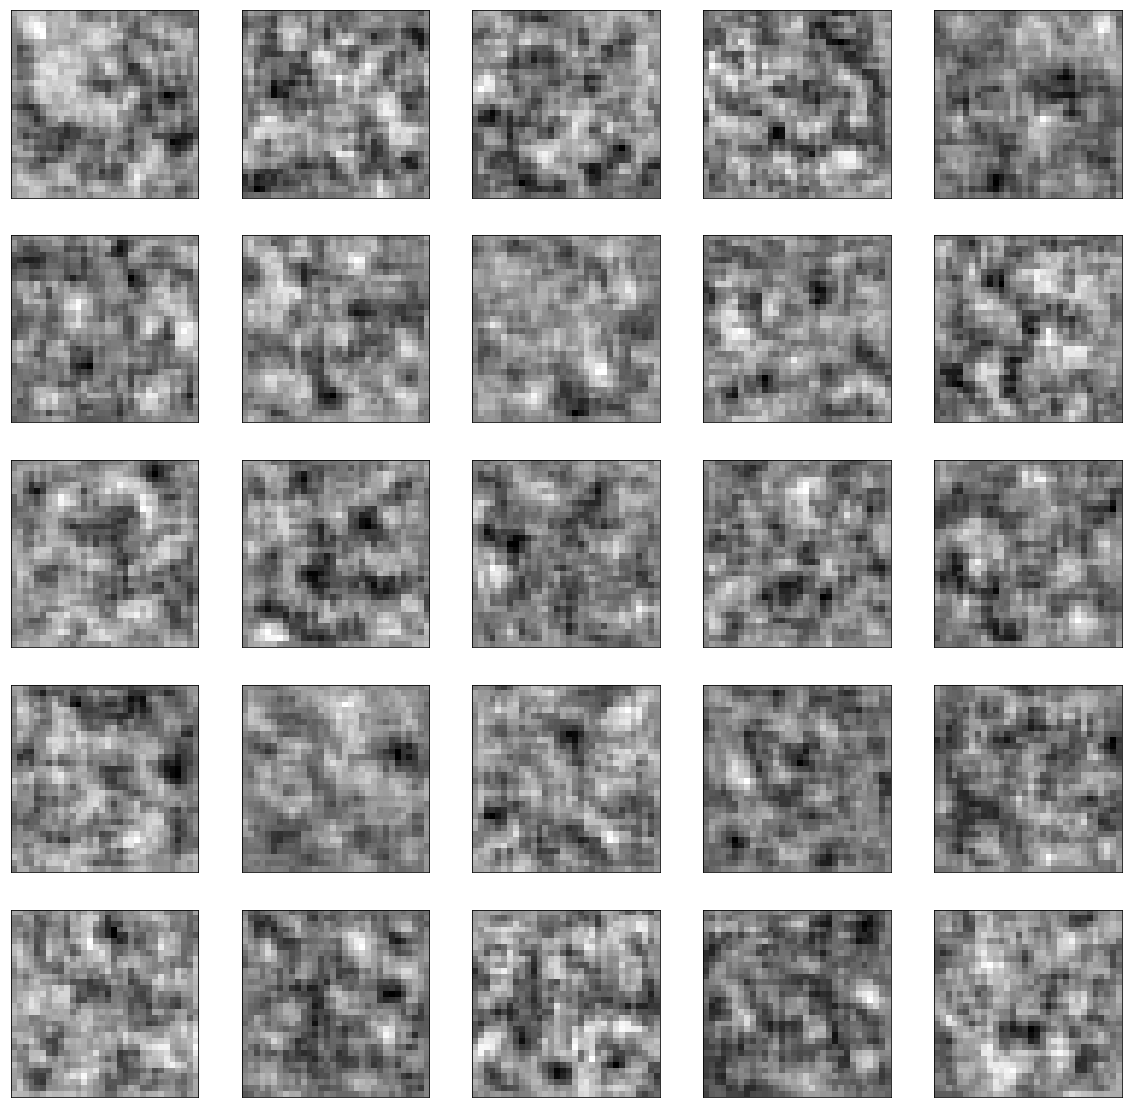

[Epoch 0/10] [Batch 1/938] [Generator loss: 0.713215] [Discriminator loss: 0.692099]
[Epoch 0/10] [Batch 2/938] [Generator loss: 0.712623] [Discriminator loss: 0.690916]
[Epoch 0/10] [Batch 3/938] [Generator loss: 0.711384] [Discriminator loss: 0.689122]
[Epoch 0/10] [Batch 4/938] [Generator loss: 0.710850] [Discriminator loss: 0.687846]
[Epoch 0/10] [Batch 5/938] [Generator loss: 0.709512] [Discriminator loss: 0.686269]
[Epoch 0/10] [Batch 6/938] [Generator loss: 0.708404] [Discriminator loss: 0.685677]
[Epoch 0/10] [Batch 7/938] [Generator loss: 0.707618] [Discriminator loss: 0.683697]
[Epoch 0/10] [Batch 8/938] [Generator loss: 0.706446] [Discriminator loss: 0.681517]
[Epoch 0/10] [Batch 9/938] [Generator loss: 0.706263] [Discriminator loss: 0.678790]
[Epoch 0/10] [Batch 10/938] [Generator loss: 0.703073] [Discriminator loss: 0.676480]
[Epoch 0/10] [Batch 11/938] [Generator loss: 0.701768] [Discriminator loss: 0.675771]
[Epoch 0/10] [Batch 12/938] [Generator loss: 0.700409] [Discrim

[Epoch 0/10] [Batch 102/938] [Generator loss: 0.666357] [Discriminator loss: 0.673946]
[Epoch 0/10] [Batch 103/938] [Generator loss: 0.678721] [Discriminator loss: 0.689655]
[Epoch 0/10] [Batch 104/938] [Generator loss: 0.688603] [Discriminator loss: 0.698180]
[Epoch 0/10] [Batch 105/938] [Generator loss: 0.691106] [Discriminator loss: 0.673845]
[Epoch 0/10] [Batch 106/938] [Generator loss: 0.688575] [Discriminator loss: 0.684180]
[Epoch 0/10] [Batch 107/938] [Generator loss: 0.678729] [Discriminator loss: 0.681866]
[Epoch 0/10] [Batch 108/938] [Generator loss: 0.684173] [Discriminator loss: 0.689181]
[Epoch 0/10] [Batch 109/938] [Generator loss: 0.691089] [Discriminator loss: 0.697805]
[Epoch 0/10] [Batch 110/938] [Generator loss: 0.695683] [Discriminator loss: 0.692796]
[Epoch 0/10] [Batch 111/938] [Generator loss: 0.699578] [Discriminator loss: 0.695466]
[Epoch 0/10] [Batch 112/938] [Generator loss: 0.701093] [Discriminator loss: 0.675131]
[Epoch 0/10] [Batch 113/938] [Generator los

[Epoch 0/10] [Batch 204/938] [Generator loss: 0.701251] [Discriminator loss: 0.707269]
[Epoch 0/10] [Batch 205/938] [Generator loss: 0.713221] [Discriminator loss: 0.700967]
[Epoch 0/10] [Batch 206/938] [Generator loss: 0.707924] [Discriminator loss: 0.692246]
[Epoch 0/10] [Batch 207/938] [Generator loss: 0.707520] [Discriminator loss: 0.690921]
[Epoch 0/10] [Batch 208/938] [Generator loss: 0.692656] [Discriminator loss: 0.696463]
[Epoch 0/10] [Batch 209/938] [Generator loss: 0.681911] [Discriminator loss: 0.712102]
[Epoch 0/10] [Batch 210/938] [Generator loss: 0.700909] [Discriminator loss: 0.696059]
[Epoch 0/10] [Batch 211/938] [Generator loss: 0.690310] [Discriminator loss: 0.693760]
[Epoch 0/10] [Batch 212/938] [Generator loss: 0.703252] [Discriminator loss: 0.693045]
[Epoch 0/10] [Batch 213/938] [Generator loss: 0.696043] [Discriminator loss: 0.702394]
[Epoch 0/10] [Batch 214/938] [Generator loss: 0.687811] [Discriminator loss: 0.692250]
[Epoch 0/10] [Batch 215/938] [Generator los

[Epoch 0/10] [Batch 302/938] [Generator loss: 0.678439] [Discriminator loss: 0.685709]
[Epoch 0/10] [Batch 303/938] [Generator loss: 0.662980] [Discriminator loss: 0.698981]
[Epoch 0/10] [Batch 304/938] [Generator loss: 0.687207] [Discriminator loss: 0.682132]
[Epoch 0/10] [Batch 305/938] [Generator loss: 0.674344] [Discriminator loss: 0.699773]
[Epoch 0/10] [Batch 306/938] [Generator loss: 0.673468] [Discriminator loss: 0.693143]
[Epoch 0/10] [Batch 307/938] [Generator loss: 0.673606] [Discriminator loss: 0.699247]
[Epoch 0/10] [Batch 308/938] [Generator loss: 0.685080] [Discriminator loss: 0.691752]
[Epoch 0/10] [Batch 309/938] [Generator loss: 0.667024] [Discriminator loss: 0.698815]
[Epoch 0/10] [Batch 310/938] [Generator loss: 0.689736] [Discriminator loss: 0.697559]
[Epoch 0/10] [Batch 311/938] [Generator loss: 0.705208] [Discriminator loss: 0.690365]
[Epoch 0/10] [Batch 312/938] [Generator loss: 0.708944] [Discriminator loss: 0.690267]
[Epoch 0/10] [Batch 313/938] [Generator los

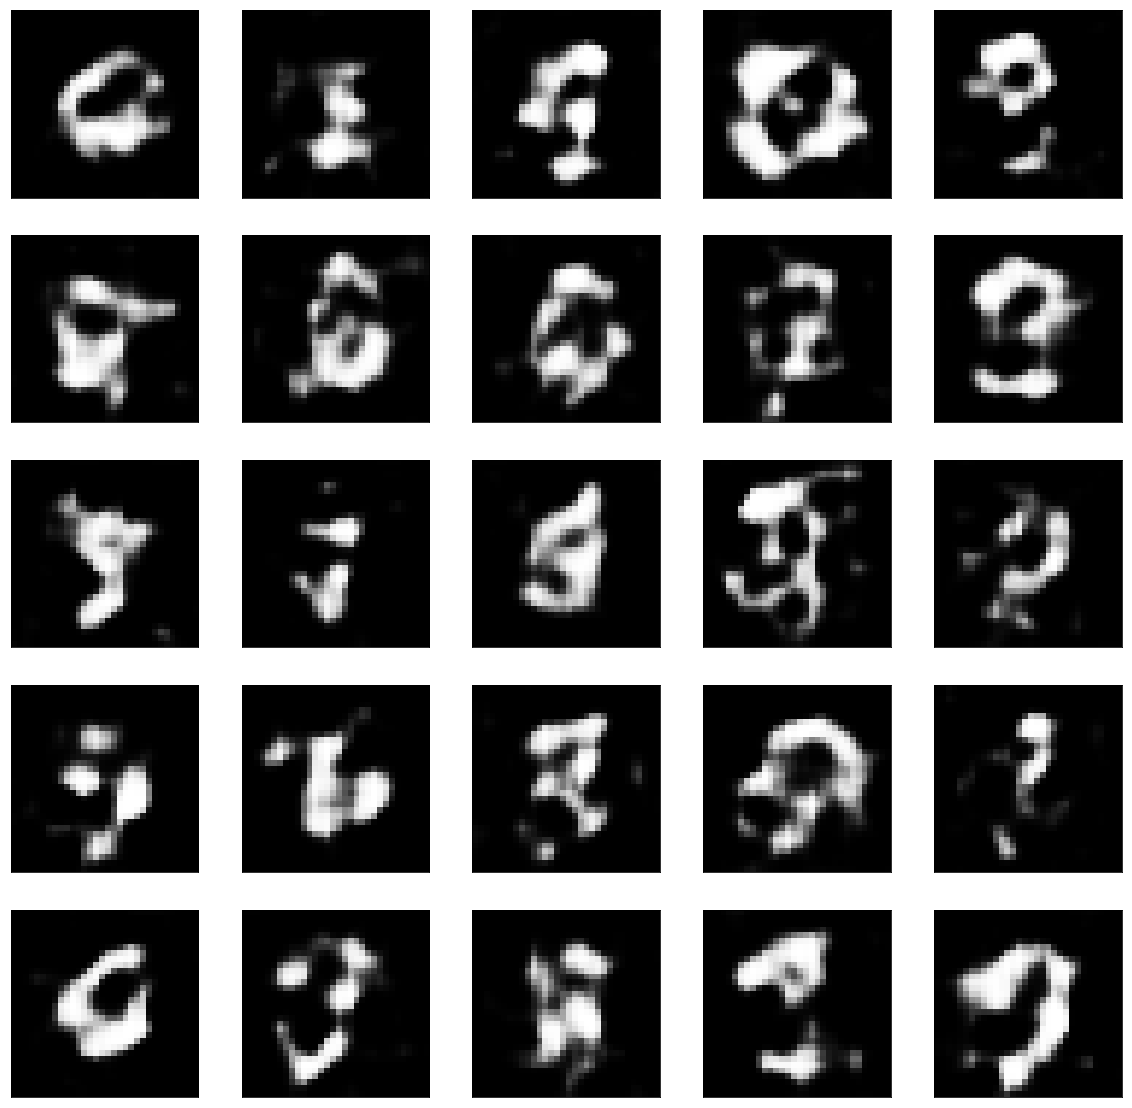

[Epoch 0/10] [Batch 401/938] [Generator loss: 0.701988] [Discriminator loss: 0.689811]
[Epoch 0/10] [Batch 402/938] [Generator loss: 0.703004] [Discriminator loss: 0.693392]
[Epoch 0/10] [Batch 403/938] [Generator loss: 0.694672] [Discriminator loss: 0.692621]
[Epoch 0/10] [Batch 404/938] [Generator loss: 0.707719] [Discriminator loss: 0.688110]
[Epoch 0/10] [Batch 405/938] [Generator loss: 0.691043] [Discriminator loss: 0.689549]
[Epoch 0/10] [Batch 406/938] [Generator loss: 0.694349] [Discriminator loss: 0.693154]
[Epoch 0/10] [Batch 407/938] [Generator loss: 0.683055] [Discriminator loss: 0.691869]
[Epoch 0/10] [Batch 408/938] [Generator loss: 0.695598] [Discriminator loss: 0.696489]
[Epoch 0/10] [Batch 409/938] [Generator loss: 0.695668] [Discriminator loss: 0.695055]
[Epoch 0/10] [Batch 410/938] [Generator loss: 0.689090] [Discriminator loss: 0.689831]
[Epoch 0/10] [Batch 411/938] [Generator loss: 0.701654] [Discriminator loss: 0.692951]
[Epoch 0/10] [Batch 412/938] [Generator los

[Epoch 0/10] [Batch 497/938] [Generator loss: 0.705522] [Discriminator loss: 0.698738]
[Epoch 0/10] [Batch 498/938] [Generator loss: 0.696983] [Discriminator loss: 0.693199]
[Epoch 0/10] [Batch 499/938] [Generator loss: 0.691081] [Discriminator loss: 0.690462]
[Epoch 0/10] [Batch 500/938] [Generator loss: 0.694954] [Discriminator loss: 0.681595]
[Epoch 0/10] [Batch 501/938] [Generator loss: 0.678849] [Discriminator loss: 0.692049]
[Epoch 0/10] [Batch 502/938] [Generator loss: 0.678188] [Discriminator loss: 0.693649]
[Epoch 0/10] [Batch 503/938] [Generator loss: 0.670121] [Discriminator loss: 0.692611]
[Epoch 0/10] [Batch 504/938] [Generator loss: 0.673082] [Discriminator loss: 0.688443]
[Epoch 0/10] [Batch 505/938] [Generator loss: 0.679016] [Discriminator loss: 0.693506]
[Epoch 0/10] [Batch 506/938] [Generator loss: 0.683043] [Discriminator loss: 0.699049]
[Epoch 0/10] [Batch 507/938] [Generator loss: 0.701575] [Discriminator loss: 0.687773]
[Epoch 0/10] [Batch 508/938] [Generator los

[Epoch 0/10] [Batch 598/938] [Generator loss: 0.705571] [Discriminator loss: 0.696166]
[Epoch 0/10] [Batch 599/938] [Generator loss: 0.721942] [Discriminator loss: 0.697751]
[Epoch 0/10] [Batch 600/938] [Generator loss: 0.719625] [Discriminator loss: 0.699369]
[Epoch 0/10] [Batch 601/938] [Generator loss: 0.723379] [Discriminator loss: 0.697020]
[Epoch 0/10] [Batch 602/938] [Generator loss: 0.710375] [Discriminator loss: 0.697346]
[Epoch 0/10] [Batch 603/938] [Generator loss: 0.722953] [Discriminator loss: 0.693077]
[Epoch 0/10] [Batch 604/938] [Generator loss: 0.723342] [Discriminator loss: 0.693378]
[Epoch 0/10] [Batch 605/938] [Generator loss: 0.721748] [Discriminator loss: 0.692180]
[Epoch 0/10] [Batch 606/938] [Generator loss: 0.707683] [Discriminator loss: 0.699293]
[Epoch 0/10] [Batch 607/938] [Generator loss: 0.703617] [Discriminator loss: 0.691395]
[Epoch 0/10] [Batch 608/938] [Generator loss: 0.710612] [Discriminator loss: 0.683015]
[Epoch 0/10] [Batch 609/938] [Generator los

[Epoch 0/10] [Batch 696/938] [Generator loss: 0.673057] [Discriminator loss: 0.690785]
[Epoch 0/10] [Batch 697/938] [Generator loss: 0.687143] [Discriminator loss: 0.696642]
[Epoch 0/10] [Batch 698/938] [Generator loss: 0.686640] [Discriminator loss: 0.690264]
[Epoch 0/10] [Batch 699/938] [Generator loss: 0.691438] [Discriminator loss: 0.685554]
[Epoch 0/10] [Batch 700/938] [Generator loss: 0.689208] [Discriminator loss: 0.684702]
[Epoch 0/10] [Batch 701/938] [Generator loss: 0.697418] [Discriminator loss: 0.686474]
[Epoch 0/10] [Batch 702/938] [Generator loss: 0.694722] [Discriminator loss: 0.690987]
[Epoch 0/10] [Batch 703/938] [Generator loss: 0.679879] [Discriminator loss: 0.701628]
[Epoch 0/10] [Batch 704/938] [Generator loss: 0.696200] [Discriminator loss: 0.699200]
[Epoch 0/10] [Batch 705/938] [Generator loss: 0.676060] [Discriminator loss: 0.699027]
[Epoch 0/10] [Batch 706/938] [Generator loss: 0.674186] [Discriminator loss: 0.694756]
[Epoch 0/10] [Batch 707/938] [Generator los

[Epoch 0/10] [Batch 793/938] [Generator loss: 0.684066] [Discriminator loss: 0.687479]
[Epoch 0/10] [Batch 794/938] [Generator loss: 0.679537] [Discriminator loss: 0.688589]
[Epoch 0/10] [Batch 795/938] [Generator loss: 0.684423] [Discriminator loss: 0.686519]
[Epoch 0/10] [Batch 796/938] [Generator loss: 0.701907] [Discriminator loss: 0.693372]
[Epoch 0/10] [Batch 797/938] [Generator loss: 0.714055] [Discriminator loss: 0.694514]
[Epoch 0/10] [Batch 798/938] [Generator loss: 0.723323] [Discriminator loss: 0.687490]
[Epoch 0/10] [Batch 799/938] [Generator loss: 0.724705] [Discriminator loss: 0.687601]
[Epoch 0/10] [Batch 800/938] [Generator loss: 0.723099] [Discriminator loss: 0.685594]


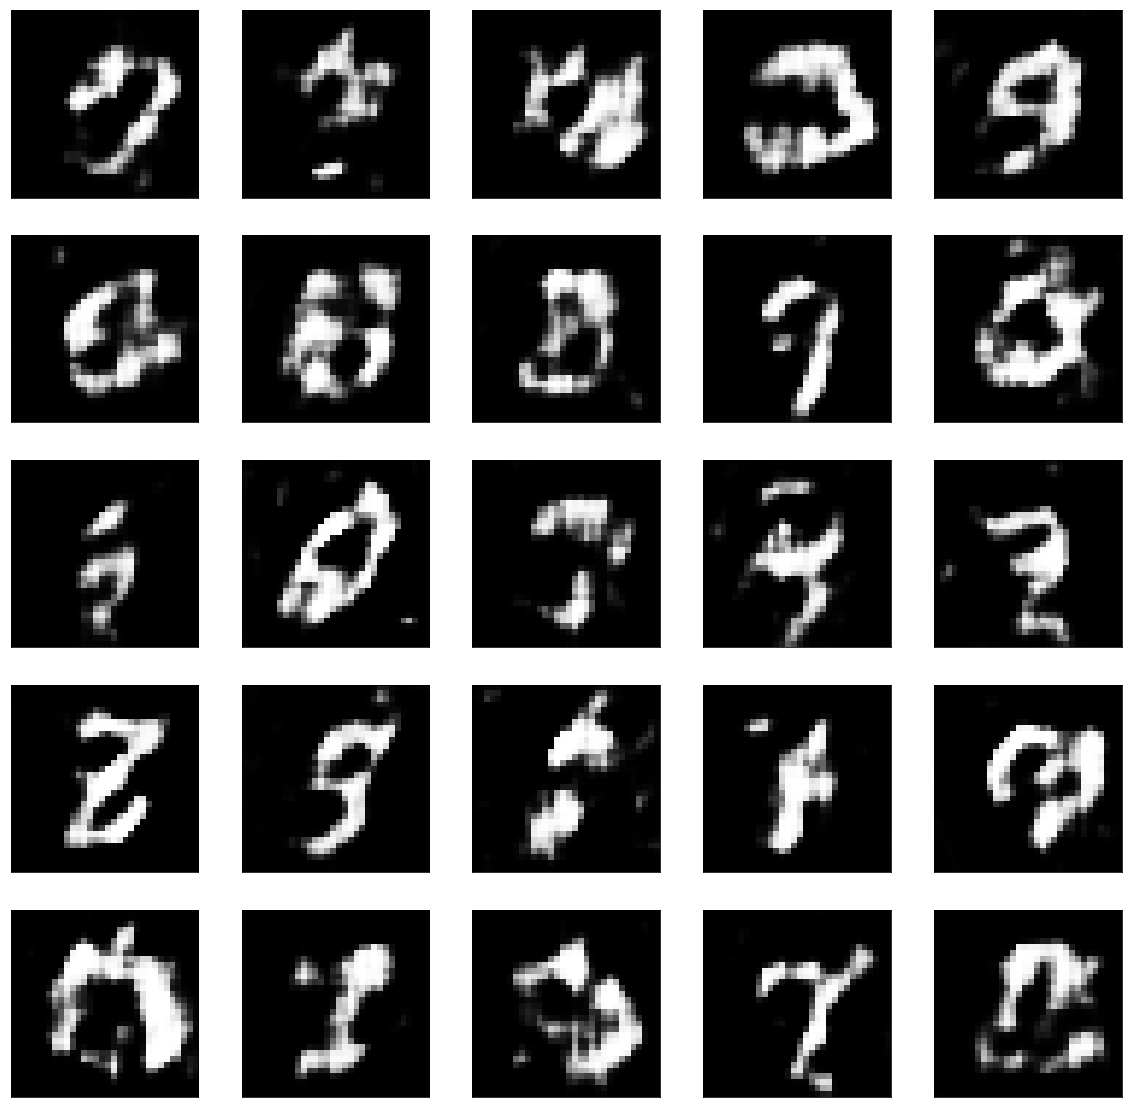

[Epoch 0/10] [Batch 801/938] [Generator loss: 0.710526] [Discriminator loss: 0.689481]
[Epoch 0/10] [Batch 802/938] [Generator loss: 0.728184] [Discriminator loss: 0.685920]
[Epoch 0/10] [Batch 803/938] [Generator loss: 0.727127] [Discriminator loss: 0.689391]
[Epoch 0/10] [Batch 804/938] [Generator loss: 0.730429] [Discriminator loss: 0.674865]
[Epoch 0/10] [Batch 805/938] [Generator loss: 0.715416] [Discriminator loss: 0.683111]
[Epoch 0/10] [Batch 806/938] [Generator loss: 0.709647] [Discriminator loss: 0.683758]
[Epoch 0/10] [Batch 807/938] [Generator loss: 0.713220] [Discriminator loss: 0.684901]
[Epoch 0/10] [Batch 808/938] [Generator loss: 0.706120] [Discriminator loss: 0.688050]
[Epoch 0/10] [Batch 809/938] [Generator loss: 0.714501] [Discriminator loss: 0.681291]
[Epoch 0/10] [Batch 810/938] [Generator loss: 0.732501] [Discriminator loss: 0.682161]
[Epoch 0/10] [Batch 811/938] [Generator loss: 0.719155] [Discriminator loss: 0.699277]
[Epoch 0/10] [Batch 812/938] [Generator los

[Epoch 0/10] [Batch 896/938] [Generator loss: 0.707719] [Discriminator loss: 0.678643]
[Epoch 0/10] [Batch 897/938] [Generator loss: 0.700303] [Discriminator loss: 0.680545]
[Epoch 0/10] [Batch 898/938] [Generator loss: 0.700774] [Discriminator loss: 0.675728]
[Epoch 0/10] [Batch 899/938] [Generator loss: 0.674220] [Discriminator loss: 0.700247]
[Epoch 0/10] [Batch 900/938] [Generator loss: 0.698163] [Discriminator loss: 0.684763]
[Epoch 0/10] [Batch 901/938] [Generator loss: 0.687189] [Discriminator loss: 0.680041]
[Epoch 0/10] [Batch 902/938] [Generator loss: 0.679535] [Discriminator loss: 0.688295]
[Epoch 0/10] [Batch 903/938] [Generator loss: 0.680255] [Discriminator loss: 0.676504]
[Epoch 0/10] [Batch 904/938] [Generator loss: 0.675631] [Discriminator loss: 0.682580]
[Epoch 0/10] [Batch 905/938] [Generator loss: 0.684320] [Discriminator loss: 0.677637]
[Epoch 0/10] [Batch 906/938] [Generator loss: 0.680753] [Discriminator loss: 0.679215]
[Epoch 0/10] [Batch 907/938] [Generator los

[Epoch 1/10] [Batch 53/938] [Generator loss: 0.652154] [Discriminator loss: 0.664845]
[Epoch 1/10] [Batch 54/938] [Generator loss: 0.698063] [Discriminator loss: 0.675718]
[Epoch 1/10] [Batch 55/938] [Generator loss: 0.688653] [Discriminator loss: 0.660346]
[Epoch 1/10] [Batch 56/938] [Generator loss: 0.704361] [Discriminator loss: 0.664819]
[Epoch 1/10] [Batch 57/938] [Generator loss: 0.669800] [Discriminator loss: 0.678808]
[Epoch 1/10] [Batch 58/938] [Generator loss: 0.669551] [Discriminator loss: 0.678939]
[Epoch 1/10] [Batch 59/938] [Generator loss: 0.712872] [Discriminator loss: 0.671558]
[Epoch 1/10] [Batch 60/938] [Generator loss: 0.622087] [Discriminator loss: 0.681511]
[Epoch 1/10] [Batch 61/938] [Generator loss: 0.670622] [Discriminator loss: 0.661708]
[Epoch 1/10] [Batch 62/938] [Generator loss: 0.677790] [Discriminator loss: 0.696363]
[Epoch 1/10] [Batch 63/938] [Generator loss: 0.684116] [Discriminator loss: 0.689777]
[Epoch 1/10] [Batch 64/938] [Generator loss: 0.683834]

[Epoch 1/10] [Batch 148/938] [Generator loss: 0.749980] [Discriminator loss: 0.672488]
[Epoch 1/10] [Batch 149/938] [Generator loss: 0.759150] [Discriminator loss: 0.655419]
[Epoch 1/10] [Batch 150/938] [Generator loss: 0.736889] [Discriminator loss: 0.665539]
[Epoch 1/10] [Batch 151/938] [Generator loss: 0.742487] [Discriminator loss: 0.669557]
[Epoch 1/10] [Batch 152/938] [Generator loss: 0.718128] [Discriminator loss: 0.677819]
[Epoch 1/10] [Batch 153/938] [Generator loss: 0.729230] [Discriminator loss: 0.680049]
[Epoch 1/10] [Batch 154/938] [Generator loss: 0.778145] [Discriminator loss: 0.656564]
[Epoch 1/10] [Batch 155/938] [Generator loss: 0.736419] [Discriminator loss: 0.637470]
[Epoch 1/10] [Batch 156/938] [Generator loss: 0.728598] [Discriminator loss: 0.644413]
[Epoch 1/10] [Batch 157/938] [Generator loss: 0.683873] [Discriminator loss: 0.659694]
[Epoch 1/10] [Batch 158/938] [Generator loss: 0.712481] [Discriminator loss: 0.666153]
[Epoch 1/10] [Batch 159/938] [Generator los

[Epoch 1/10] [Batch 246/938] [Generator loss: 0.736115] [Discriminator loss: 0.640670]
[Epoch 1/10] [Batch 247/938] [Generator loss: 0.735028] [Discriminator loss: 0.630602]
[Epoch 1/10] [Batch 248/938] [Generator loss: 0.682457] [Discriminator loss: 0.660282]
[Epoch 1/10] [Batch 249/938] [Generator loss: 0.709036] [Discriminator loss: 0.675202]
[Epoch 1/10] [Batch 250/938] [Generator loss: 0.697550] [Discriminator loss: 0.682817]
[Epoch 1/10] [Batch 251/938] [Generator loss: 0.739148] [Discriminator loss: 0.635356]
[Epoch 1/10] [Batch 252/938] [Generator loss: 0.756436] [Discriminator loss: 0.655910]
[Epoch 1/10] [Batch 253/938] [Generator loss: 0.787184] [Discriminator loss: 0.675340]
[Epoch 1/10] [Batch 254/938] [Generator loss: 0.760448] [Discriminator loss: 0.659192]
[Epoch 1/10] [Batch 255/938] [Generator loss: 0.736681] [Discriminator loss: 0.670019]
[Epoch 1/10] [Batch 256/938] [Generator loss: 0.693099] [Discriminator loss: 0.638065]
[Epoch 1/10] [Batch 257/938] [Generator los

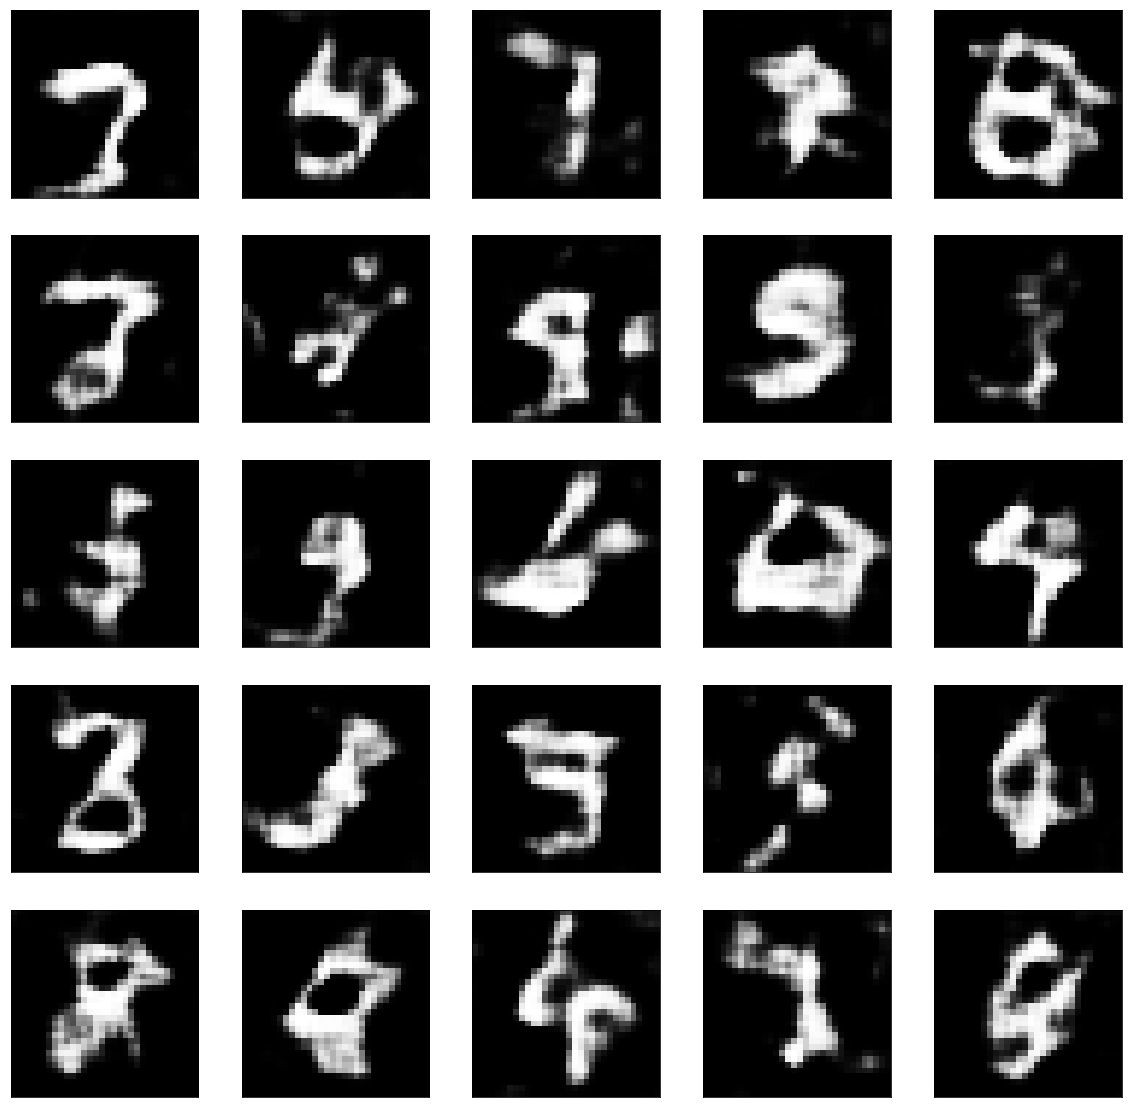

[Epoch 1/10] [Batch 263/938] [Generator loss: 0.674171] [Discriminator loss: 0.693259]
[Epoch 1/10] [Batch 264/938] [Generator loss: 0.827663] [Discriminator loss: 0.653087]
[Epoch 1/10] [Batch 265/938] [Generator loss: 0.803875] [Discriminator loss: 0.653499]
[Epoch 1/10] [Batch 266/938] [Generator loss: 0.728444] [Discriminator loss: 0.693742]
[Epoch 1/10] [Batch 267/938] [Generator loss: 0.808944] [Discriminator loss: 0.625926]
[Epoch 1/10] [Batch 268/938] [Generator loss: 0.794196] [Discriminator loss: 0.680624]
[Epoch 1/10] [Batch 269/938] [Generator loss: 0.749696] [Discriminator loss: 0.675585]
[Epoch 1/10] [Batch 270/938] [Generator loss: 0.751785] [Discriminator loss: 0.664691]
[Epoch 1/10] [Batch 271/938] [Generator loss: 0.743414] [Discriminator loss: 0.662751]
[Epoch 1/10] [Batch 272/938] [Generator loss: 0.775763] [Discriminator loss: 0.654251]
[Epoch 1/10] [Batch 273/938] [Generator loss: 0.750638] [Discriminator loss: 0.654446]
[Epoch 1/10] [Batch 274/938] [Generator los

[Epoch 1/10] [Batch 365/938] [Generator loss: 0.804870] [Discriminator loss: 0.639479]
[Epoch 1/10] [Batch 366/938] [Generator loss: 0.725860] [Discriminator loss: 0.656358]
[Epoch 1/10] [Batch 367/938] [Generator loss: 0.809111] [Discriminator loss: 0.629176]
[Epoch 1/10] [Batch 368/938] [Generator loss: 0.781447] [Discriminator loss: 0.637897]
[Epoch 1/10] [Batch 369/938] [Generator loss: 0.707804] [Discriminator loss: 0.708073]
[Epoch 1/10] [Batch 370/938] [Generator loss: 0.799432] [Discriminator loss: 0.677373]
[Epoch 1/10] [Batch 371/938] [Generator loss: 0.819024] [Discriminator loss: 0.637102]
[Epoch 1/10] [Batch 372/938] [Generator loss: 0.798195] [Discriminator loss: 0.662648]
[Epoch 1/10] [Batch 373/938] [Generator loss: 0.786447] [Discriminator loss: 0.642778]
[Epoch 1/10] [Batch 374/938] [Generator loss: 0.746038] [Discriminator loss: 0.683326]
[Epoch 1/10] [Batch 375/938] [Generator loss: 0.699624] [Discriminator loss: 0.626982]
[Epoch 1/10] [Batch 376/938] [Generator los

[Epoch 1/10] [Batch 460/938] [Generator loss: 0.786338] [Discriminator loss: 0.711629]
[Epoch 1/10] [Batch 461/938] [Generator loss: 0.881564] [Discriminator loss: 0.611756]
[Epoch 1/10] [Batch 462/938] [Generator loss: 0.801436] [Discriminator loss: 0.651336]
[Epoch 1/10] [Batch 463/938] [Generator loss: 0.756718] [Discriminator loss: 0.695134]
[Epoch 1/10] [Batch 464/938] [Generator loss: 0.724425] [Discriminator loss: 0.676793]
[Epoch 1/10] [Batch 465/938] [Generator loss: 0.752834] [Discriminator loss: 0.652648]
[Epoch 1/10] [Batch 466/938] [Generator loss: 0.719693] [Discriminator loss: 0.659737]
[Epoch 1/10] [Batch 467/938] [Generator loss: 0.768695] [Discriminator loss: 0.659641]
[Epoch 1/10] [Batch 468/938] [Generator loss: 0.771359] [Discriminator loss: 0.670282]
[Epoch 1/10] [Batch 469/938] [Generator loss: 0.766841] [Discriminator loss: 0.658245]
[Epoch 1/10] [Batch 470/938] [Generator loss: 0.725771] [Discriminator loss: 0.683409]
[Epoch 1/10] [Batch 471/938] [Generator los

[Epoch 1/10] [Batch 557/938] [Generator loss: 0.747186] [Discriminator loss: 0.649500]
[Epoch 1/10] [Batch 558/938] [Generator loss: 0.744011] [Discriminator loss: 0.670873]
[Epoch 1/10] [Batch 559/938] [Generator loss: 0.774657] [Discriminator loss: 0.626417]
[Epoch 1/10] [Batch 560/938] [Generator loss: 0.760332] [Discriminator loss: 0.624100]
[Epoch 1/10] [Batch 561/938] [Generator loss: 0.785317] [Discriminator loss: 0.671216]
[Epoch 1/10] [Batch 562/938] [Generator loss: 0.756353] [Discriminator loss: 0.647016]
[Epoch 1/10] [Batch 563/938] [Generator loss: 0.833175] [Discriminator loss: 0.692096]
[Epoch 1/10] [Batch 564/938] [Generator loss: 0.777455] [Discriminator loss: 0.673044]
[Epoch 1/10] [Batch 565/938] [Generator loss: 0.787705] [Discriminator loss: 0.617509]
[Epoch 1/10] [Batch 566/938] [Generator loss: 0.772951] [Discriminator loss: 0.644629]
[Epoch 1/10] [Batch 567/938] [Generator loss: 0.767032] [Discriminator loss: 0.671723]
[Epoch 1/10] [Batch 568/938] [Generator los

[Epoch 1/10] [Batch 657/938] [Generator loss: 0.747028] [Discriminator loss: 0.673369]
[Epoch 1/10] [Batch 658/938] [Generator loss: 0.803468] [Discriminator loss: 0.667042]
[Epoch 1/10] [Batch 659/938] [Generator loss: 0.839434] [Discriminator loss: 0.672920]
[Epoch 1/10] [Batch 660/938] [Generator loss: 0.766524] [Discriminator loss: 0.636458]
[Epoch 1/10] [Batch 661/938] [Generator loss: 0.690483] [Discriminator loss: 0.640750]
[Epoch 1/10] [Batch 662/938] [Generator loss: 0.720873] [Discriminator loss: 0.626010]


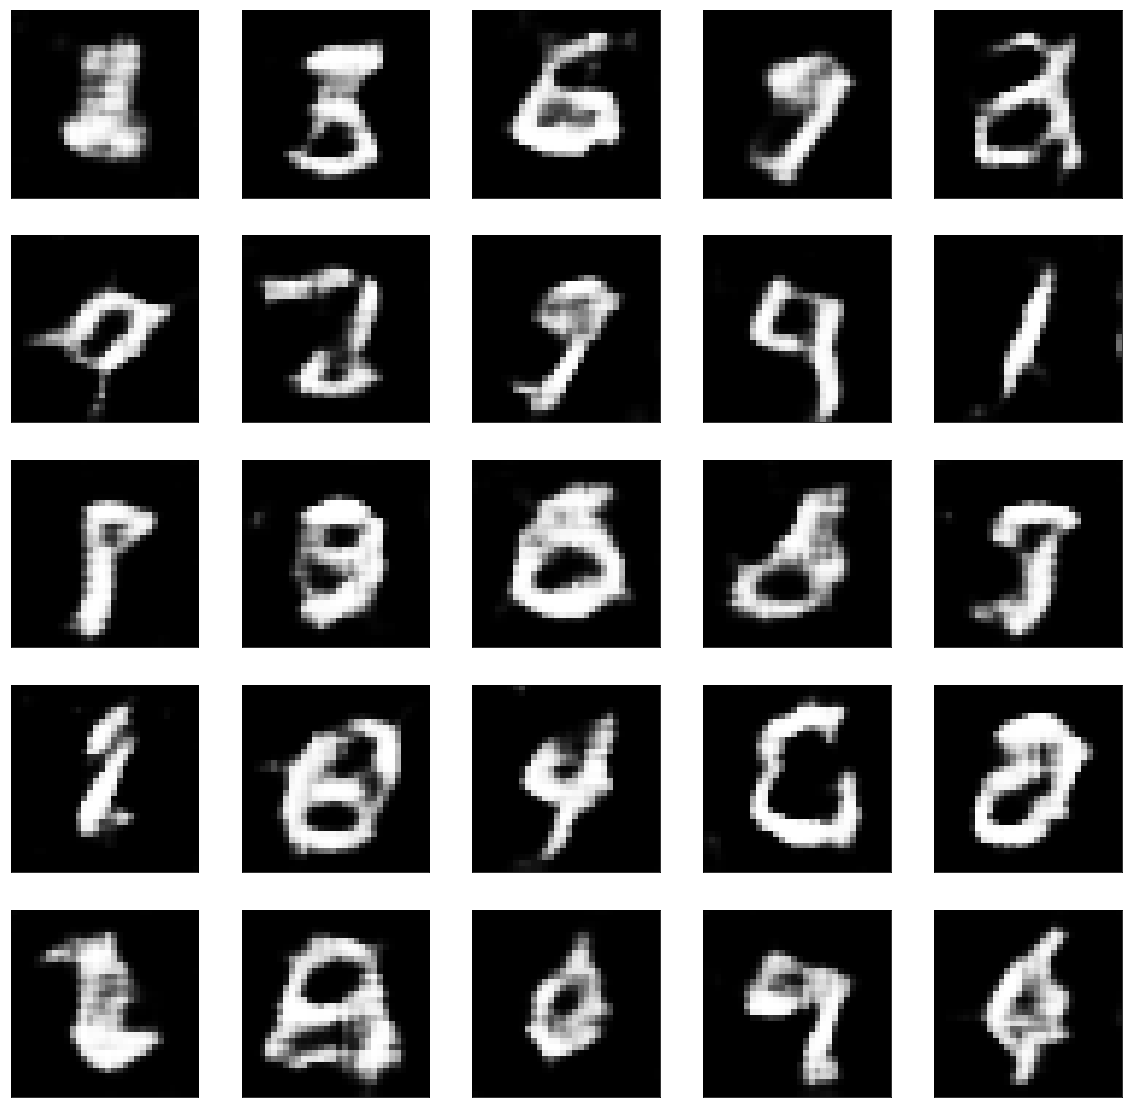

[Epoch 1/10] [Batch 663/938] [Generator loss: 0.710417] [Discriminator loss: 0.623373]
[Epoch 1/10] [Batch 664/938] [Generator loss: 0.786958] [Discriminator loss: 0.621123]
[Epoch 1/10] [Batch 665/938] [Generator loss: 0.765786] [Discriminator loss: 0.640677]
[Epoch 1/10] [Batch 666/938] [Generator loss: 0.792335] [Discriminator loss: 0.658420]
[Epoch 1/10] [Batch 667/938] [Generator loss: 0.816182] [Discriminator loss: 0.648080]
[Epoch 1/10] [Batch 668/938] [Generator loss: 0.686800] [Discriminator loss: 0.663269]
[Epoch 1/10] [Batch 669/938] [Generator loss: 0.795914] [Discriminator loss: 0.644853]
[Epoch 1/10] [Batch 670/938] [Generator loss: 0.760892] [Discriminator loss: 0.611458]
[Epoch 1/10] [Batch 671/938] [Generator loss: 0.754292] [Discriminator loss: 0.660987]
[Epoch 1/10] [Batch 672/938] [Generator loss: 0.746828] [Discriminator loss: 0.674037]
[Epoch 1/10] [Batch 673/938] [Generator loss: 0.939013] [Discriminator loss: 0.626478]
[Epoch 1/10] [Batch 674/938] [Generator los

[Epoch 1/10] [Batch 763/938] [Generator loss: 0.865282] [Discriminator loss: 0.663832]
[Epoch 1/10] [Batch 764/938] [Generator loss: 0.806492] [Discriminator loss: 0.617542]
[Epoch 1/10] [Batch 765/938] [Generator loss: 0.765512] [Discriminator loss: 0.596787]
[Epoch 1/10] [Batch 766/938] [Generator loss: 0.774275] [Discriminator loss: 0.675749]
[Epoch 1/10] [Batch 767/938] [Generator loss: 0.752763] [Discriminator loss: 0.646953]
[Epoch 1/10] [Batch 768/938] [Generator loss: 0.715557] [Discriminator loss: 0.611575]
[Epoch 1/10] [Batch 769/938] [Generator loss: 0.805233] [Discriminator loss: 0.641096]
[Epoch 1/10] [Batch 770/938] [Generator loss: 0.733063] [Discriminator loss: 0.663710]
[Epoch 1/10] [Batch 771/938] [Generator loss: 0.903684] [Discriminator loss: 0.594927]
[Epoch 1/10] [Batch 772/938] [Generator loss: 0.822075] [Discriminator loss: 0.637829]
[Epoch 1/10] [Batch 773/938] [Generator loss: 0.643089] [Discriminator loss: 0.698710]
[Epoch 1/10] [Batch 774/938] [Generator los

[Epoch 1/10] [Batch 860/938] [Generator loss: 0.800753] [Discriminator loss: 0.662808]
[Epoch 1/10] [Batch 861/938] [Generator loss: 0.758994] [Discriminator loss: 0.605552]
[Epoch 1/10] [Batch 862/938] [Generator loss: 0.739508] [Discriminator loss: 0.689241]
[Epoch 1/10] [Batch 863/938] [Generator loss: 0.818886] [Discriminator loss: 0.673155]
[Epoch 1/10] [Batch 864/938] [Generator loss: 0.793300] [Discriminator loss: 0.588406]
[Epoch 1/10] [Batch 865/938] [Generator loss: 0.731857] [Discriminator loss: 0.628922]
[Epoch 1/10] [Batch 866/938] [Generator loss: 0.716481] [Discriminator loss: 0.680065]
[Epoch 1/10] [Batch 867/938] [Generator loss: 0.814369] [Discriminator loss: 0.598960]
[Epoch 1/10] [Batch 868/938] [Generator loss: 0.845117] [Discriminator loss: 0.699104]
[Epoch 1/10] [Batch 869/938] [Generator loss: 0.778967] [Discriminator loss: 0.590219]
[Epoch 1/10] [Batch 870/938] [Generator loss: 0.756370] [Discriminator loss: 0.682525]
[Epoch 1/10] [Batch 871/938] [Generator los

[Epoch 2/10] [Batch 20/938] [Generator loss: 0.780529] [Discriminator loss: 0.664645]
[Epoch 2/10] [Batch 21/938] [Generator loss: 0.797445] [Discriminator loss: 0.634737]
[Epoch 2/10] [Batch 22/938] [Generator loss: 0.813444] [Discriminator loss: 0.631347]
[Epoch 2/10] [Batch 23/938] [Generator loss: 0.726969] [Discriminator loss: 0.617434]
[Epoch 2/10] [Batch 24/938] [Generator loss: 0.706718] [Discriminator loss: 0.618338]
[Epoch 2/10] [Batch 25/938] [Generator loss: 0.761225] [Discriminator loss: 0.633265]
[Epoch 2/10] [Batch 26/938] [Generator loss: 0.719968] [Discriminator loss: 0.648790]
[Epoch 2/10] [Batch 27/938] [Generator loss: 0.849905] [Discriminator loss: 0.653484]
[Epoch 2/10] [Batch 28/938] [Generator loss: 0.744882] [Discriminator loss: 0.650672]
[Epoch 2/10] [Batch 29/938] [Generator loss: 0.759016] [Discriminator loss: 0.678879]
[Epoch 2/10] [Batch 30/938] [Generator loss: 0.854713] [Discriminator loss: 0.621426]
[Epoch 2/10] [Batch 31/938] [Generator loss: 0.893320]

[Epoch 2/10] [Batch 120/938] [Generator loss: 0.860144] [Discriminator loss: 0.590990]
[Epoch 2/10] [Batch 121/938] [Generator loss: 0.772428] [Discriminator loss: 0.575683]
[Epoch 2/10] [Batch 122/938] [Generator loss: 0.779928] [Discriminator loss: 0.632433]
[Epoch 2/10] [Batch 123/938] [Generator loss: 0.781945] [Discriminator loss: 0.668520]
[Epoch 2/10] [Batch 124/938] [Generator loss: 0.774608] [Discriminator loss: 0.711196]


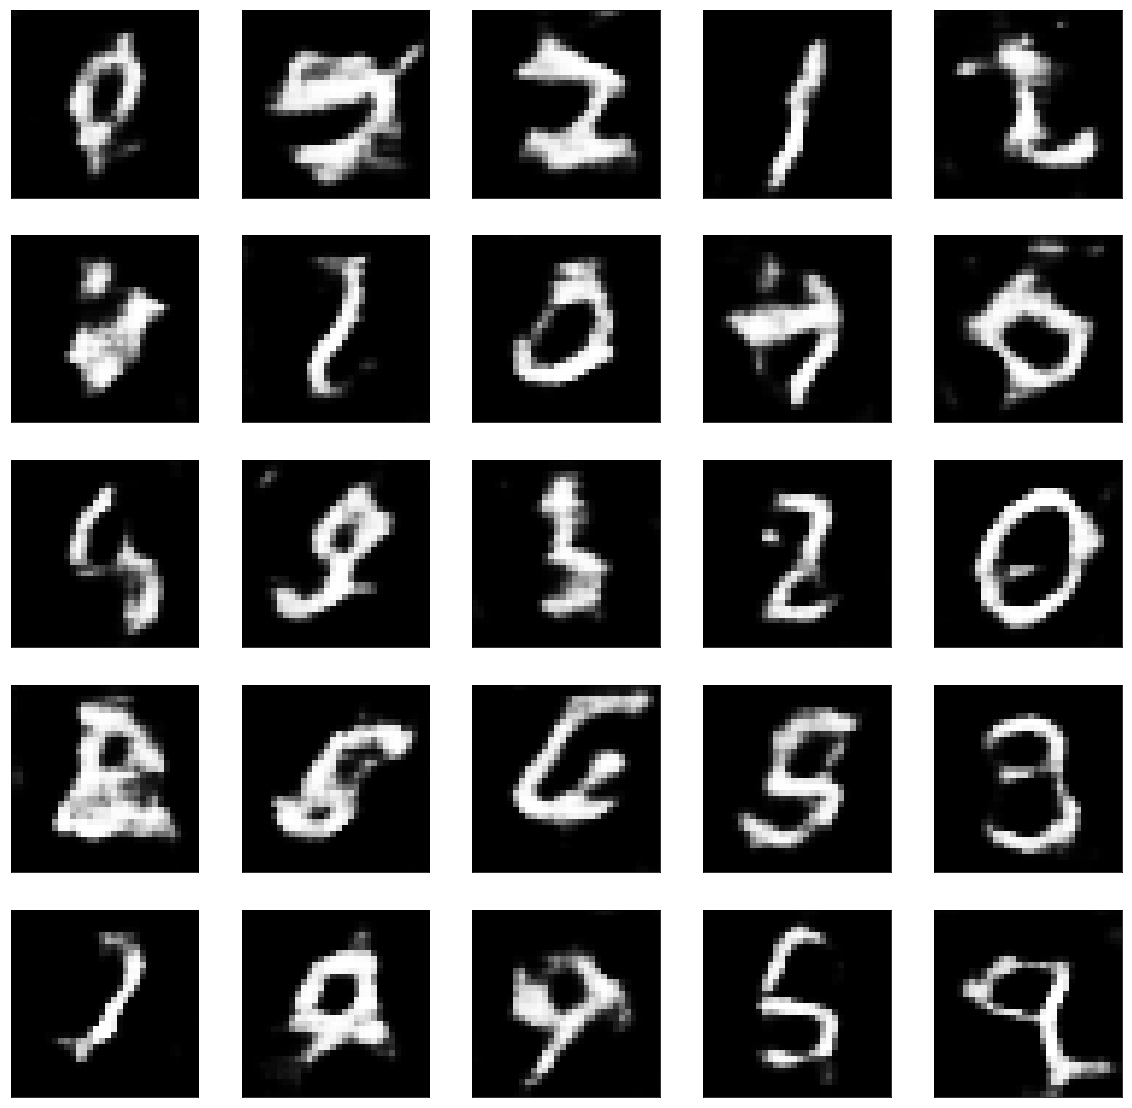

[Epoch 2/10] [Batch 125/938] [Generator loss: 0.750708] [Discriminator loss: 0.635663]
[Epoch 2/10] [Batch 126/938] [Generator loss: 0.754936] [Discriminator loss: 0.691418]
[Epoch 2/10] [Batch 127/938] [Generator loss: 0.670023] [Discriminator loss: 0.716316]
[Epoch 2/10] [Batch 128/938] [Generator loss: 0.878418] [Discriminator loss: 0.621249]
[Epoch 2/10] [Batch 129/938] [Generator loss: 0.917157] [Discriminator loss: 0.601035]
[Epoch 2/10] [Batch 130/938] [Generator loss: 0.791216] [Discriminator loss: 0.626756]
[Epoch 2/10] [Batch 131/938] [Generator loss: 0.740806] [Discriminator loss: 0.604672]
[Epoch 2/10] [Batch 132/938] [Generator loss: 0.748912] [Discriminator loss: 0.678034]
[Epoch 2/10] [Batch 133/938] [Generator loss: 0.823078] [Discriminator loss: 0.615595]
[Epoch 2/10] [Batch 134/938] [Generator loss: 0.740086] [Discriminator loss: 0.571656]
[Epoch 2/10] [Batch 135/938] [Generator loss: 0.741039] [Discriminator loss: 0.663885]
[Epoch 2/10] [Batch 136/938] [Generator los

[Epoch 2/10] [Batch 225/938] [Generator loss: 0.844891] [Discriminator loss: 0.644660]
[Epoch 2/10] [Batch 226/938] [Generator loss: 0.807883] [Discriminator loss: 0.624111]
[Epoch 2/10] [Batch 227/938] [Generator loss: 0.791544] [Discriminator loss: 0.656284]
[Epoch 2/10] [Batch 228/938] [Generator loss: 0.844248] [Discriminator loss: 0.649196]
[Epoch 2/10] [Batch 229/938] [Generator loss: 0.986032] [Discriminator loss: 0.614095]
[Epoch 2/10] [Batch 230/938] [Generator loss: 0.842475] [Discriminator loss: 0.633847]
[Epoch 2/10] [Batch 231/938] [Generator loss: 0.790824] [Discriminator loss: 0.634629]
[Epoch 2/10] [Batch 232/938] [Generator loss: 0.721123] [Discriminator loss: 0.632743]
[Epoch 2/10] [Batch 233/938] [Generator loss: 0.699673] [Discriminator loss: 0.607702]
[Epoch 2/10] [Batch 234/938] [Generator loss: 0.734255] [Discriminator loss: 0.609752]
[Epoch 2/10] [Batch 235/938] [Generator loss: 0.737593] [Discriminator loss: 0.681936]
[Epoch 2/10] [Batch 236/938] [Generator los

[Epoch 2/10] [Batch 320/938] [Generator loss: 0.747084] [Discriminator loss: 0.618244]
[Epoch 2/10] [Batch 321/938] [Generator loss: 0.803780] [Discriminator loss: 0.587835]
[Epoch 2/10] [Batch 322/938] [Generator loss: 0.698290] [Discriminator loss: 0.650579]
[Epoch 2/10] [Batch 323/938] [Generator loss: 0.714513] [Discriminator loss: 0.579622]
[Epoch 2/10] [Batch 324/938] [Generator loss: 0.866799] [Discriminator loss: 0.573520]
[Epoch 2/10] [Batch 325/938] [Generator loss: 0.799330] [Discriminator loss: 0.661454]
[Epoch 2/10] [Batch 326/938] [Generator loss: 0.842505] [Discriminator loss: 0.648939]
[Epoch 2/10] [Batch 327/938] [Generator loss: 0.908268] [Discriminator loss: 0.634415]
[Epoch 2/10] [Batch 328/938] [Generator loss: 0.804996] [Discriminator loss: 0.600051]
[Epoch 2/10] [Batch 329/938] [Generator loss: 0.814345] [Discriminator loss: 0.628564]
[Epoch 2/10] [Batch 330/938] [Generator loss: 0.723544] [Discriminator loss: 0.644077]
[Epoch 2/10] [Batch 331/938] [Generator los

[Epoch 2/10] [Batch 415/938] [Generator loss: 0.706528] [Discriminator loss: 0.650070]
[Epoch 2/10] [Batch 416/938] [Generator loss: 0.708036] [Discriminator loss: 0.630183]
[Epoch 2/10] [Batch 417/938] [Generator loss: 0.830242] [Discriminator loss: 0.683311]
[Epoch 2/10] [Batch 418/938] [Generator loss: 0.843327] [Discriminator loss: 0.577263]
[Epoch 2/10] [Batch 419/938] [Generator loss: 0.792174] [Discriminator loss: 0.683391]
[Epoch 2/10] [Batch 420/938] [Generator loss: 0.915860] [Discriminator loss: 0.630036]
[Epoch 2/10] [Batch 421/938] [Generator loss: 0.931616] [Discriminator loss: 0.628967]
[Epoch 2/10] [Batch 422/938] [Generator loss: 0.809179] [Discriminator loss: 0.610365]
[Epoch 2/10] [Batch 423/938] [Generator loss: 0.928954] [Discriminator loss: 0.572095]
[Epoch 2/10] [Batch 424/938] [Generator loss: 0.825254] [Discriminator loss: 0.678215]
[Epoch 2/10] [Batch 425/938] [Generator loss: 0.824647] [Discriminator loss: 0.610893]
[Epoch 2/10] [Batch 426/938] [Generator los

[Epoch 2/10] [Batch 510/938] [Generator loss: 0.689306] [Discriminator loss: 0.665544]
[Epoch 2/10] [Batch 511/938] [Generator loss: 0.663679] [Discriminator loss: 0.614971]
[Epoch 2/10] [Batch 512/938] [Generator loss: 0.763880] [Discriminator loss: 0.656914]
[Epoch 2/10] [Batch 513/938] [Generator loss: 0.704016] [Discriminator loss: 0.628866]
[Epoch 2/10] [Batch 514/938] [Generator loss: 0.958326] [Discriminator loss: 0.604334]
[Epoch 2/10] [Batch 515/938] [Generator loss: 0.879259] [Discriminator loss: 0.616796]
[Epoch 2/10] [Batch 516/938] [Generator loss: 0.776230] [Discriminator loss: 0.587311]
[Epoch 2/10] [Batch 517/938] [Generator loss: 0.827298] [Discriminator loss: 0.632537]
[Epoch 2/10] [Batch 518/938] [Generator loss: 0.823805] [Discriminator loss: 0.590836]
[Epoch 2/10] [Batch 519/938] [Generator loss: 0.698619] [Discriminator loss: 0.555737]
[Epoch 2/10] [Batch 520/938] [Generator loss: 0.882823] [Discriminator loss: 0.621672]
[Epoch 2/10] [Batch 521/938] [Generator los

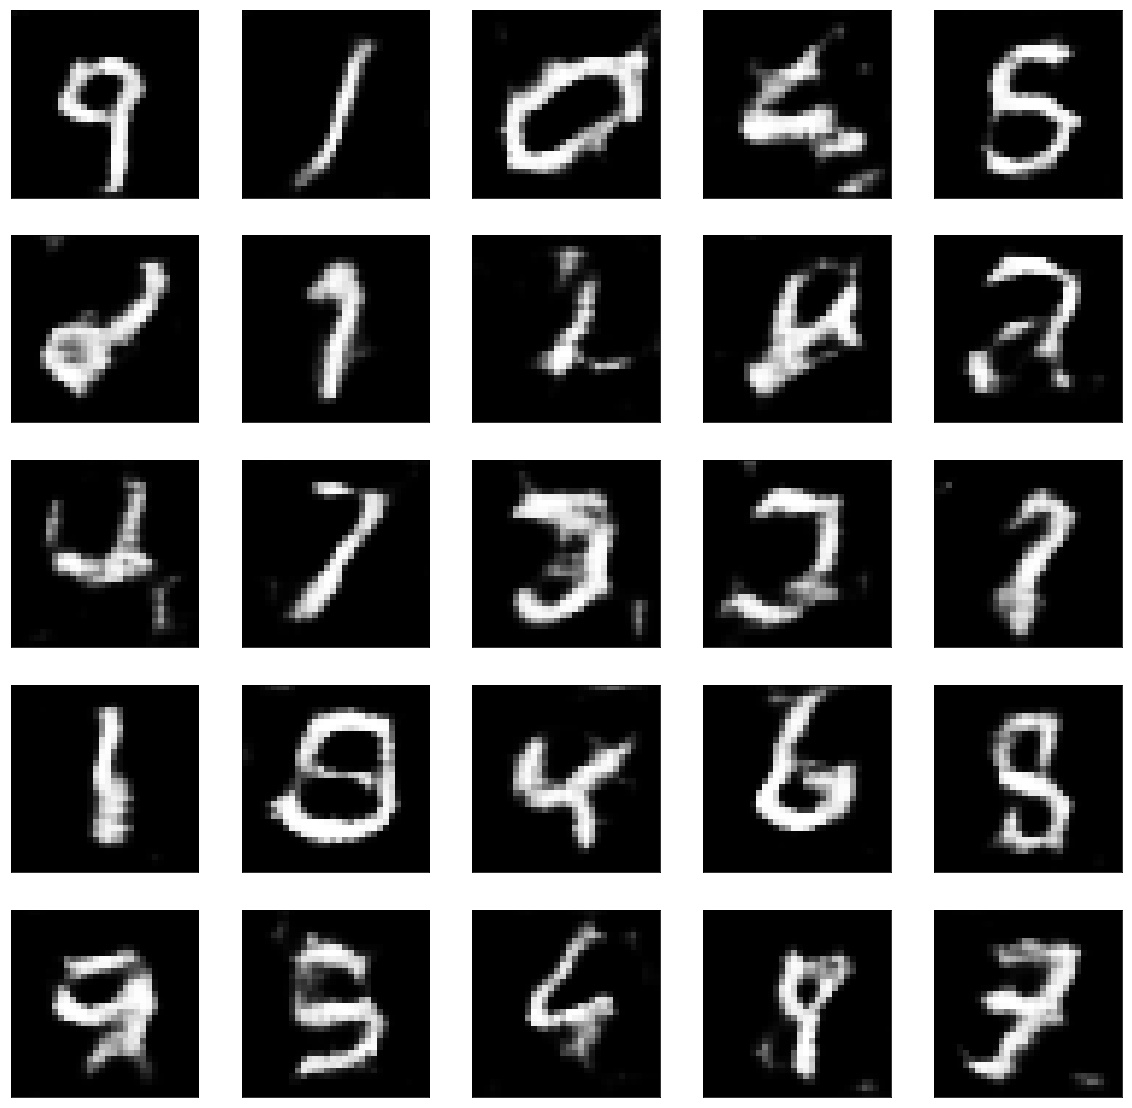

[Epoch 2/10] [Batch 525/938] [Generator loss: 0.723618] [Discriminator loss: 0.667935]
[Epoch 2/10] [Batch 526/938] [Generator loss: 0.871152] [Discriminator loss: 0.570562]
[Epoch 2/10] [Batch 527/938] [Generator loss: 0.873754] [Discriminator loss: 0.627134]
[Epoch 2/10] [Batch 528/938] [Generator loss: 0.835006] [Discriminator loss: 0.638162]
[Epoch 2/10] [Batch 529/938] [Generator loss: 0.873095] [Discriminator loss: 0.637433]
[Epoch 2/10] [Batch 530/938] [Generator loss: 0.746380] [Discriminator loss: 0.603174]
[Epoch 2/10] [Batch 531/938] [Generator loss: 0.841383] [Discriminator loss: 0.611075]
[Epoch 2/10] [Batch 532/938] [Generator loss: 0.818695] [Discriminator loss: 0.690970]
[Epoch 2/10] [Batch 533/938] [Generator loss: 0.937712] [Discriminator loss: 0.577191]
[Epoch 2/10] [Batch 534/938] [Generator loss: 0.785054] [Discriminator loss: 0.597285]
[Epoch 2/10] [Batch 535/938] [Generator loss: 0.807560] [Discriminator loss: 0.575901]
[Epoch 2/10] [Batch 536/938] [Generator los

[Epoch 2/10] [Batch 625/938] [Generator loss: 0.875117] [Discriminator loss: 0.659568]
[Epoch 2/10] [Batch 626/938] [Generator loss: 0.892380] [Discriminator loss: 0.644166]
[Epoch 2/10] [Batch 627/938] [Generator loss: 0.726879] [Discriminator loss: 0.615171]
[Epoch 2/10] [Batch 628/938] [Generator loss: 0.829439] [Discriminator loss: 0.616135]
[Epoch 2/10] [Batch 629/938] [Generator loss: 0.835618] [Discriminator loss: 0.613145]
[Epoch 2/10] [Batch 630/938] [Generator loss: 0.906162] [Discriminator loss: 0.589972]
[Epoch 2/10] [Batch 631/938] [Generator loss: 0.963718] [Discriminator loss: 0.595145]
[Epoch 2/10] [Batch 632/938] [Generator loss: 0.773832] [Discriminator loss: 0.669143]
[Epoch 2/10] [Batch 633/938] [Generator loss: 0.958111] [Discriminator loss: 0.593735]
[Epoch 2/10] [Batch 634/938] [Generator loss: 0.776145] [Discriminator loss: 0.616080]
[Epoch 2/10] [Batch 635/938] [Generator loss: 0.864646] [Discriminator loss: 0.633616]
[Epoch 2/10] [Batch 636/938] [Generator los

[Epoch 2/10] [Batch 722/938] [Generator loss: 0.829186] [Discriminator loss: 0.572198]
[Epoch 2/10] [Batch 723/938] [Generator loss: 0.677732] [Discriminator loss: 0.634006]
[Epoch 2/10] [Batch 724/938] [Generator loss: 0.740937] [Discriminator loss: 0.713001]
[Epoch 2/10] [Batch 725/938] [Generator loss: 0.992567] [Discriminator loss: 0.550072]
[Epoch 2/10] [Batch 726/938] [Generator loss: 0.725744] [Discriminator loss: 0.621311]
[Epoch 2/10] [Batch 727/938] [Generator loss: 0.853116] [Discriminator loss: 0.602989]
[Epoch 2/10] [Batch 728/938] [Generator loss: 0.739488] [Discriminator loss: 0.640344]
[Epoch 2/10] [Batch 729/938] [Generator loss: 0.718282] [Discriminator loss: 0.575154]
[Epoch 2/10] [Batch 730/938] [Generator loss: 0.916934] [Discriminator loss: 0.664595]
[Epoch 2/10] [Batch 731/938] [Generator loss: 0.931250] [Discriminator loss: 0.596604]
[Epoch 2/10] [Batch 732/938] [Generator loss: 0.878990] [Discriminator loss: 0.641225]
[Epoch 2/10] [Batch 733/938] [Generator los

[Epoch 2/10] [Batch 819/938] [Generator loss: 0.867719] [Discriminator loss: 0.705286]
[Epoch 2/10] [Batch 820/938] [Generator loss: 0.868243] [Discriminator loss: 0.666909]
[Epoch 2/10] [Batch 821/938] [Generator loss: 0.864645] [Discriminator loss: 0.619959]
[Epoch 2/10] [Batch 822/938] [Generator loss: 0.955902] [Discriminator loss: 0.601005]
[Epoch 2/10] [Batch 823/938] [Generator loss: 0.889288] [Discriminator loss: 0.621838]
[Epoch 2/10] [Batch 824/938] [Generator loss: 0.753672] [Discriminator loss: 0.598794]
[Epoch 2/10] [Batch 825/938] [Generator loss: 0.887855] [Discriminator loss: 0.686093]
[Epoch 2/10] [Batch 826/938] [Generator loss: 0.853201] [Discriminator loss: 0.612457]
[Epoch 2/10] [Batch 827/938] [Generator loss: 0.789584] [Discriminator loss: 0.630850]
[Epoch 2/10] [Batch 828/938] [Generator loss: 0.799329] [Discriminator loss: 0.643298]
[Epoch 2/10] [Batch 829/938] [Generator loss: 0.767868] [Discriminator loss: 0.643316]
[Epoch 2/10] [Batch 830/938] [Generator los

[Epoch 2/10] [Batch 920/938] [Generator loss: 0.752677] [Discriminator loss: 0.656492]
[Epoch 2/10] [Batch 921/938] [Generator loss: 0.976730] [Discriminator loss: 0.603399]
[Epoch 2/10] [Batch 922/938] [Generator loss: 0.956368] [Discriminator loss: 0.610478]
[Epoch 2/10] [Batch 923/938] [Generator loss: 0.715019] [Discriminator loss: 0.602231]
[Epoch 2/10] [Batch 924/938] [Generator loss: 0.825025] [Discriminator loss: 0.574243]


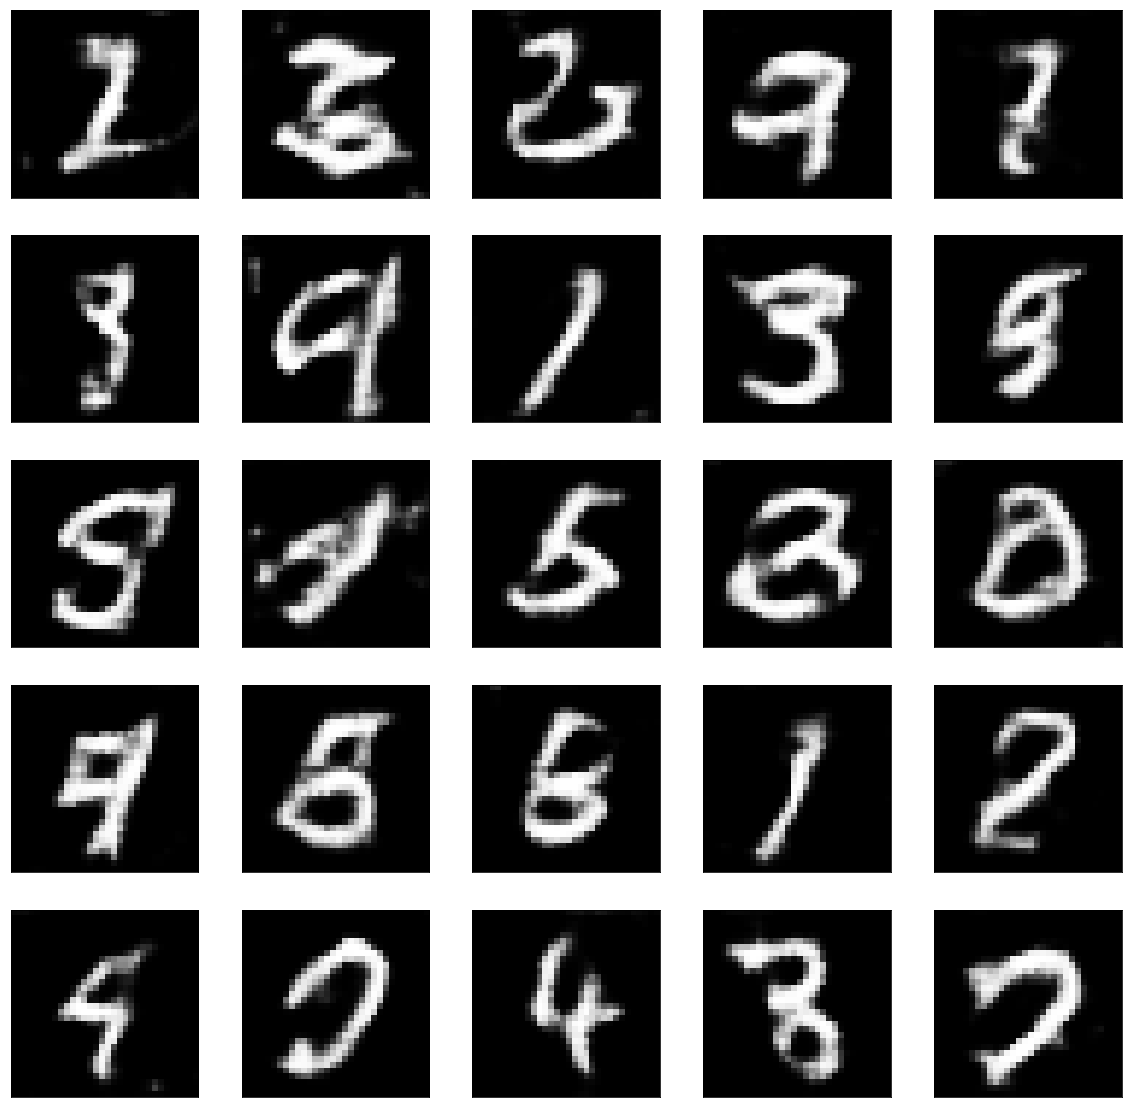

[Epoch 2/10] [Batch 925/938] [Generator loss: 0.840363] [Discriminator loss: 0.619063]
[Epoch 2/10] [Batch 926/938] [Generator loss: 0.897202] [Discriminator loss: 0.696551]
[Epoch 2/10] [Batch 927/938] [Generator loss: 0.762076] [Discriminator loss: 0.594588]
[Epoch 2/10] [Batch 928/938] [Generator loss: 0.633824] [Discriminator loss: 0.608868]
[Epoch 2/10] [Batch 929/938] [Generator loss: 1.050988] [Discriminator loss: 0.558213]
[Epoch 2/10] [Batch 930/938] [Generator loss: 0.970233] [Discriminator loss: 0.602160]
[Epoch 2/10] [Batch 931/938] [Generator loss: 0.829268] [Discriminator loss: 0.605913]
[Epoch 2/10] [Batch 932/938] [Generator loss: 0.720173] [Discriminator loss: 0.664936]
[Epoch 2/10] [Batch 933/938] [Generator loss: 1.069034] [Discriminator loss: 0.596052]
[Epoch 2/10] [Batch 934/938] [Generator loss: 0.801578] [Discriminator loss: 0.629911]
[Epoch 2/10] [Batch 935/938] [Generator loss: 0.834428] [Discriminator loss: 0.605911]
[Epoch 2/10] [Batch 936/938] [Generator los

[Epoch 3/10] [Batch 86/938] [Generator loss: 0.742672] [Discriminator loss: 0.632182]
[Epoch 3/10] [Batch 87/938] [Generator loss: 0.812672] [Discriminator loss: 0.561548]
[Epoch 3/10] [Batch 88/938] [Generator loss: 0.926248] [Discriminator loss: 0.613667]
[Epoch 3/10] [Batch 89/938] [Generator loss: 0.834072] [Discriminator loss: 0.549008]
[Epoch 3/10] [Batch 90/938] [Generator loss: 0.712126] [Discriminator loss: 0.558142]
[Epoch 3/10] [Batch 91/938] [Generator loss: 0.902735] [Discriminator loss: 0.668999]
[Epoch 3/10] [Batch 92/938] [Generator loss: 0.749090] [Discriminator loss: 0.566542]
[Epoch 3/10] [Batch 93/938] [Generator loss: 0.782729] [Discriminator loss: 0.622587]
[Epoch 3/10] [Batch 94/938] [Generator loss: 1.066194] [Discriminator loss: 0.629452]
[Epoch 3/10] [Batch 95/938] [Generator loss: 0.905835] [Discriminator loss: 0.620674]
[Epoch 3/10] [Batch 96/938] [Generator loss: 0.851238] [Discriminator loss: 0.638528]
[Epoch 3/10] [Batch 97/938] [Generator loss: 0.770123]

[Epoch 3/10] [Batch 185/938] [Generator loss: 0.828944] [Discriminator loss: 0.601326]
[Epoch 3/10] [Batch 186/938] [Generator loss: 0.860455] [Discriminator loss: 0.588729]
[Epoch 3/10] [Batch 187/938] [Generator loss: 0.973283] [Discriminator loss: 0.765029]
[Epoch 3/10] [Batch 188/938] [Generator loss: 0.954534] [Discriminator loss: 0.622133]
[Epoch 3/10] [Batch 189/938] [Generator loss: 0.802718] [Discriminator loss: 0.652089]
[Epoch 3/10] [Batch 190/938] [Generator loss: 0.687072] [Discriminator loss: 0.578039]
[Epoch 3/10] [Batch 191/938] [Generator loss: 0.686083] [Discriminator loss: 0.676926]
[Epoch 3/10] [Batch 192/938] [Generator loss: 0.946863] [Discriminator loss: 0.628085]
[Epoch 3/10] [Batch 193/938] [Generator loss: 0.883296] [Discriminator loss: 0.584892]
[Epoch 3/10] [Batch 194/938] [Generator loss: 0.956353] [Discriminator loss: 0.596645]
[Epoch 3/10] [Batch 195/938] [Generator loss: 1.031566] [Discriminator loss: 0.670783]
[Epoch 3/10] [Batch 196/938] [Generator los

[Epoch 3/10] [Batch 283/938] [Generator loss: 0.919696] [Discriminator loss: 0.612806]
[Epoch 3/10] [Batch 284/938] [Generator loss: 0.831379] [Discriminator loss: 0.625692]
[Epoch 3/10] [Batch 285/938] [Generator loss: 0.905773] [Discriminator loss: 0.540607]
[Epoch 3/10] [Batch 286/938] [Generator loss: 0.774957] [Discriminator loss: 0.505490]
[Epoch 3/10] [Batch 287/938] [Generator loss: 0.770057] [Discriminator loss: 0.614527]
[Epoch 3/10] [Batch 288/938] [Generator loss: 0.874703] [Discriminator loss: 0.655503]
[Epoch 3/10] [Batch 289/938] [Generator loss: 1.210836] [Discriminator loss: 0.678388]
[Epoch 3/10] [Batch 290/938] [Generator loss: 0.808113] [Discriminator loss: 0.553924]
[Epoch 3/10] [Batch 291/938] [Generator loss: 0.701775] [Discriminator loss: 0.634931]
[Epoch 3/10] [Batch 292/938] [Generator loss: 0.904716] [Discriminator loss: 0.572857]
[Epoch 3/10] [Batch 293/938] [Generator loss: 0.848076] [Discriminator loss: 0.575046]
[Epoch 3/10] [Batch 294/938] [Generator los

[Epoch 3/10] [Batch 380/938] [Generator loss: 0.968761] [Discriminator loss: 0.579284]
[Epoch 3/10] [Batch 381/938] [Generator loss: 0.781587] [Discriminator loss: 0.605283]
[Epoch 3/10] [Batch 382/938] [Generator loss: 0.725612] [Discriminator loss: 0.635313]
[Epoch 3/10] [Batch 383/938] [Generator loss: 0.795488] [Discriminator loss: 0.578554]
[Epoch 3/10] [Batch 384/938] [Generator loss: 0.779846] [Discriminator loss: 0.540533]
[Epoch 3/10] [Batch 385/938] [Generator loss: 0.777377] [Discriminator loss: 0.562306]
[Epoch 3/10] [Batch 386/938] [Generator loss: 1.130429] [Discriminator loss: 0.564537]


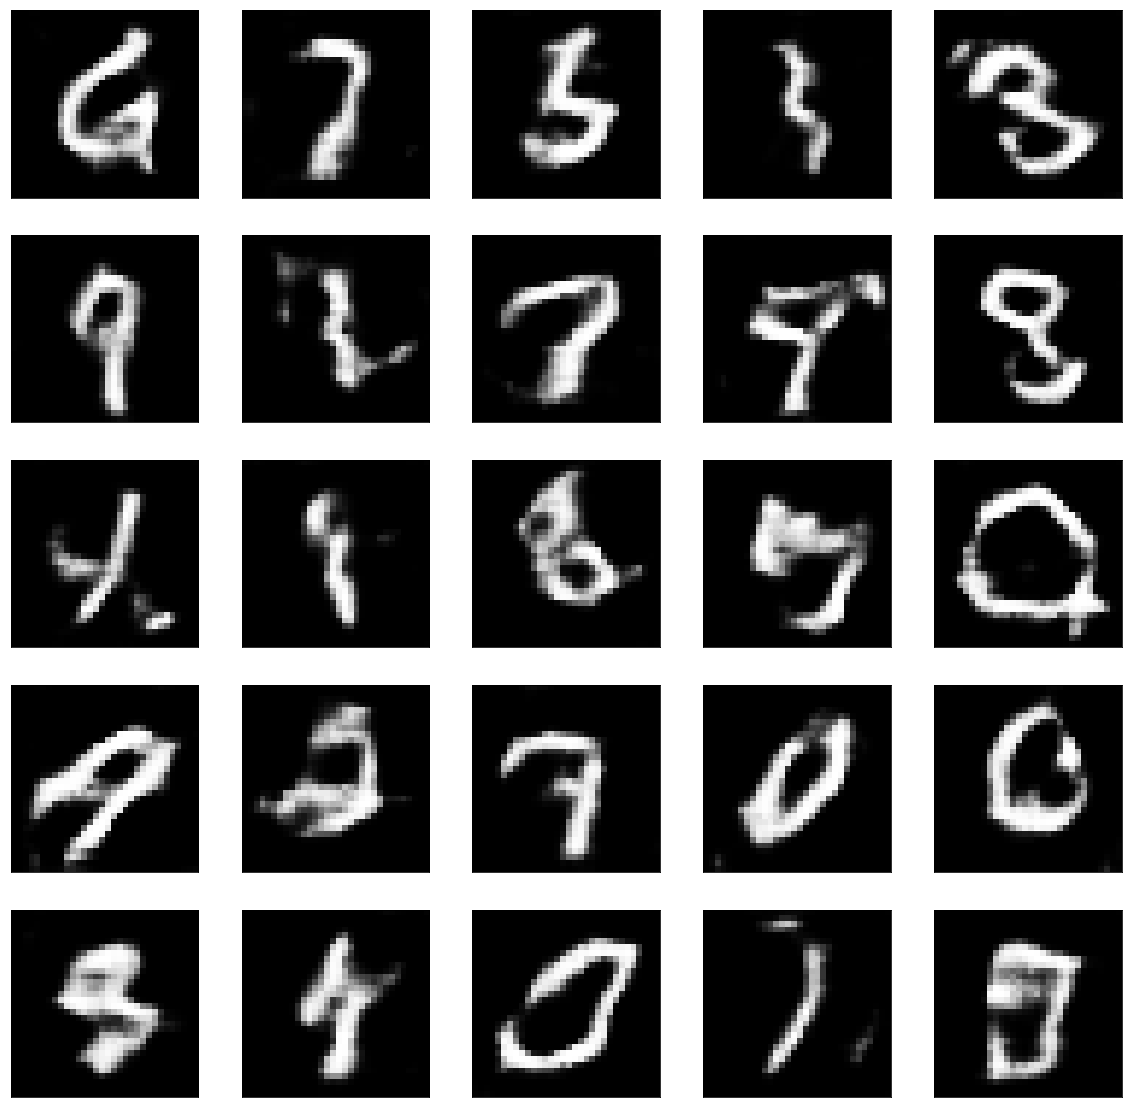

[Epoch 3/10] [Batch 387/938] [Generator loss: 0.882436] [Discriminator loss: 0.614628]
[Epoch 3/10] [Batch 388/938] [Generator loss: 0.718728] [Discriminator loss: 0.615410]
[Epoch 3/10] [Batch 389/938] [Generator loss: 0.651499] [Discriminator loss: 0.664025]
[Epoch 3/10] [Batch 390/938] [Generator loss: 0.856379] [Discriminator loss: 0.575538]
[Epoch 3/10] [Batch 391/938] [Generator loss: 1.024319] [Discriminator loss: 0.621931]
[Epoch 3/10] [Batch 392/938] [Generator loss: 0.576674] [Discriminator loss: 0.607654]
[Epoch 3/10] [Batch 393/938] [Generator loss: 0.844219] [Discriminator loss: 0.570553]
[Epoch 3/10] [Batch 394/938] [Generator loss: 0.883314] [Discriminator loss: 0.640328]
[Epoch 3/10] [Batch 395/938] [Generator loss: 0.834090] [Discriminator loss: 0.580127]
[Epoch 3/10] [Batch 396/938] [Generator loss: 1.029514] [Discriminator loss: 0.664890]
[Epoch 3/10] [Batch 397/938] [Generator loss: 0.661652] [Discriminator loss: 0.652894]
[Epoch 3/10] [Batch 398/938] [Generator los

[Epoch 3/10] [Batch 484/938] [Generator loss: 0.971081] [Discriminator loss: 0.603496]
[Epoch 3/10] [Batch 485/938] [Generator loss: 0.963885] [Discriminator loss: 0.571248]
[Epoch 3/10] [Batch 486/938] [Generator loss: 0.920334] [Discriminator loss: 0.635887]
[Epoch 3/10] [Batch 487/938] [Generator loss: 0.848142] [Discriminator loss: 0.620261]
[Epoch 3/10] [Batch 488/938] [Generator loss: 0.726535] [Discriminator loss: 0.643440]
[Epoch 3/10] [Batch 489/938] [Generator loss: 1.052006] [Discriminator loss: 0.525648]
[Epoch 3/10] [Batch 490/938] [Generator loss: 0.873748] [Discriminator loss: 0.594906]
[Epoch 3/10] [Batch 491/938] [Generator loss: 0.988962] [Discriminator loss: 0.602293]
[Epoch 3/10] [Batch 492/938] [Generator loss: 0.935394] [Discriminator loss: 0.577237]
[Epoch 3/10] [Batch 493/938] [Generator loss: 0.706146] [Discriminator loss: 0.719105]
[Epoch 3/10] [Batch 494/938] [Generator loss: 0.777903] [Discriminator loss: 0.660585]
[Epoch 3/10] [Batch 495/938] [Generator los

[Epoch 3/10] [Batch 581/938] [Generator loss: 0.940585] [Discriminator loss: 0.594751]
[Epoch 3/10] [Batch 582/938] [Generator loss: 0.756595] [Discriminator loss: 0.681861]
[Epoch 3/10] [Batch 583/938] [Generator loss: 0.968684] [Discriminator loss: 0.564106]
[Epoch 3/10] [Batch 584/938] [Generator loss: 0.730108] [Discriminator loss: 0.622563]
[Epoch 3/10] [Batch 585/938] [Generator loss: 0.782466] [Discriminator loss: 0.601136]
[Epoch 3/10] [Batch 586/938] [Generator loss: 0.889651] [Discriminator loss: 0.604465]
[Epoch 3/10] [Batch 587/938] [Generator loss: 0.928350] [Discriminator loss: 0.634484]
[Epoch 3/10] [Batch 588/938] [Generator loss: 0.923092] [Discriminator loss: 0.542588]
[Epoch 3/10] [Batch 589/938] [Generator loss: 0.751101] [Discriminator loss: 0.786160]
[Epoch 3/10] [Batch 590/938] [Generator loss: 0.962708] [Discriminator loss: 0.567517]
[Epoch 3/10] [Batch 591/938] [Generator loss: 0.758684] [Discriminator loss: 0.635957]
[Epoch 3/10] [Batch 592/938] [Generator los

[Epoch 3/10] [Batch 677/938] [Generator loss: 0.977657] [Discriminator loss: 0.550959]
[Epoch 3/10] [Batch 678/938] [Generator loss: 0.828610] [Discriminator loss: 0.644637]
[Epoch 3/10] [Batch 679/938] [Generator loss: 0.829676] [Discriminator loss: 0.595424]
[Epoch 3/10] [Batch 680/938] [Generator loss: 0.884427] [Discriminator loss: 0.555327]
[Epoch 3/10] [Batch 681/938] [Generator loss: 1.101946] [Discriminator loss: 0.596651]
[Epoch 3/10] [Batch 682/938] [Generator loss: 1.104460] [Discriminator loss: 0.493612]
[Epoch 3/10] [Batch 683/938] [Generator loss: 1.358267] [Discriminator loss: 0.554455]
[Epoch 3/10] [Batch 684/938] [Generator loss: 0.966061] [Discriminator loss: 0.571596]
[Epoch 3/10] [Batch 685/938] [Generator loss: 0.941475] [Discriminator loss: 0.635273]
[Epoch 3/10] [Batch 686/938] [Generator loss: 1.057404] [Discriminator loss: 0.677376]
[Epoch 3/10] [Batch 687/938] [Generator loss: 1.082370] [Discriminator loss: 0.599942]
[Epoch 3/10] [Batch 688/938] [Generator los

[Epoch 3/10] [Batch 780/938] [Generator loss: 0.748094] [Discriminator loss: 0.635767]
[Epoch 3/10] [Batch 781/938] [Generator loss: 0.784992] [Discriminator loss: 0.551342]
[Epoch 3/10] [Batch 782/938] [Generator loss: 0.803757] [Discriminator loss: 0.560402]
[Epoch 3/10] [Batch 783/938] [Generator loss: 1.012843] [Discriminator loss: 0.612891]
[Epoch 3/10] [Batch 784/938] [Generator loss: 0.917023] [Discriminator loss: 0.529809]
[Epoch 3/10] [Batch 785/938] [Generator loss: 0.828490] [Discriminator loss: 0.546268]
[Epoch 3/10] [Batch 786/938] [Generator loss: 1.044114] [Discriminator loss: 0.650833]


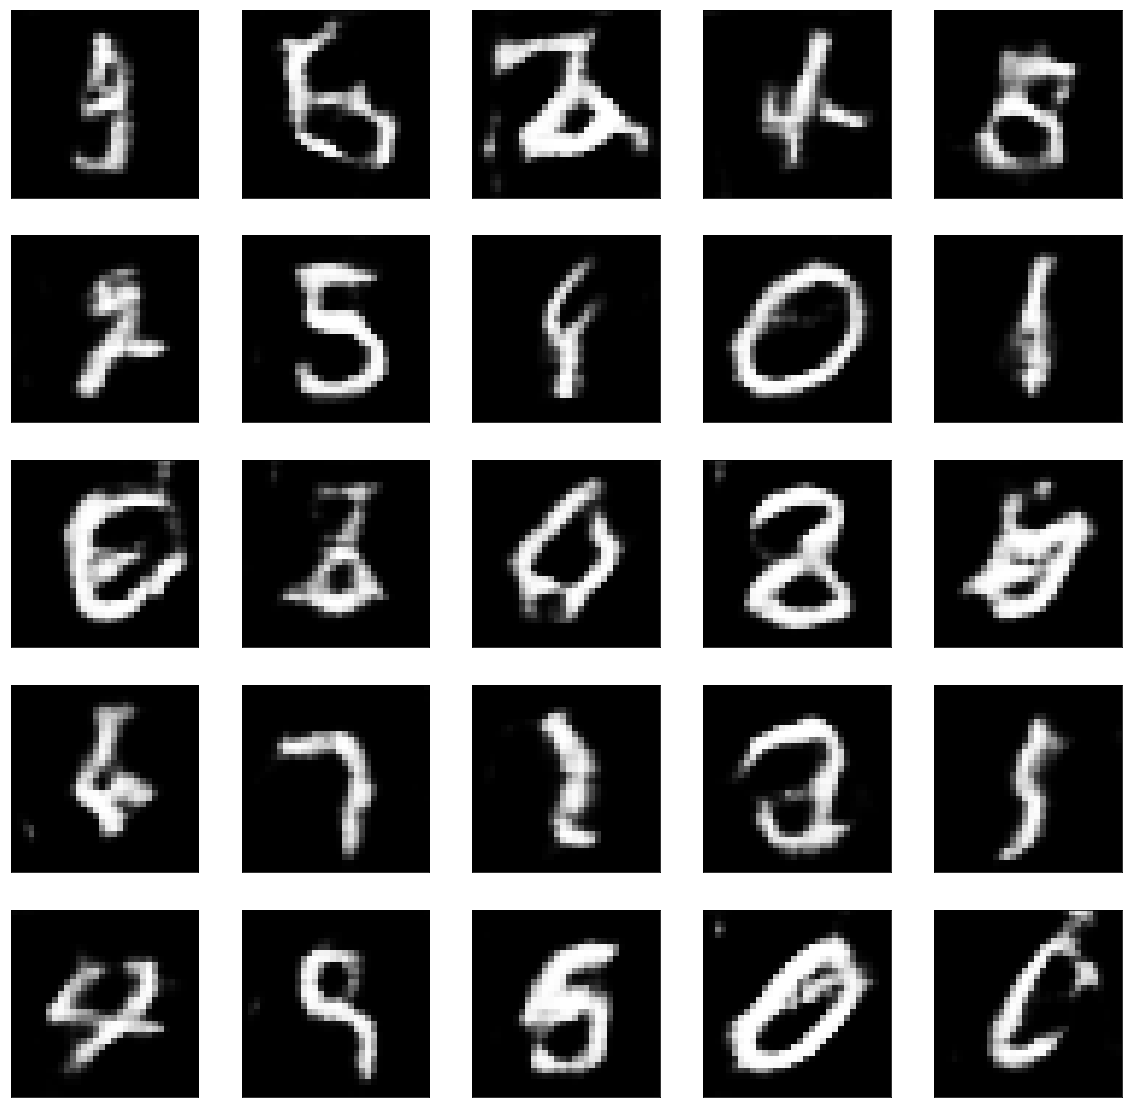

[Epoch 3/10] [Batch 787/938] [Generator loss: 0.837262] [Discriminator loss: 0.600679]
[Epoch 3/10] [Batch 788/938] [Generator loss: 1.003255] [Discriminator loss: 0.653167]
[Epoch 3/10] [Batch 789/938] [Generator loss: 0.939973] [Discriminator loss: 0.607405]
[Epoch 3/10] [Batch 790/938] [Generator loss: 0.928271] [Discriminator loss: 0.473572]
[Epoch 3/10] [Batch 791/938] [Generator loss: 0.975780] [Discriminator loss: 0.634353]
[Epoch 3/10] [Batch 792/938] [Generator loss: 1.079274] [Discriminator loss: 0.550956]
[Epoch 3/10] [Batch 793/938] [Generator loss: 0.986210] [Discriminator loss: 0.540610]
[Epoch 3/10] [Batch 794/938] [Generator loss: 0.878986] [Discriminator loss: 0.604534]
[Epoch 3/10] [Batch 795/938] [Generator loss: 0.712389] [Discriminator loss: 0.561365]
[Epoch 3/10] [Batch 796/938] [Generator loss: 1.019804] [Discriminator loss: 0.581896]
[Epoch 3/10] [Batch 797/938] [Generator loss: 0.968215] [Discriminator loss: 0.576699]
[Epoch 3/10] [Batch 798/938] [Generator los

[Epoch 3/10] [Batch 886/938] [Generator loss: 1.190924] [Discriminator loss: 0.586726]
[Epoch 3/10] [Batch 887/938] [Generator loss: 0.919350] [Discriminator loss: 0.604740]
[Epoch 3/10] [Batch 888/938] [Generator loss: 0.931391] [Discriminator loss: 0.537138]
[Epoch 3/10] [Batch 889/938] [Generator loss: 0.954620] [Discriminator loss: 0.555850]
[Epoch 3/10] [Batch 890/938] [Generator loss: 0.858336] [Discriminator loss: 0.558943]
[Epoch 3/10] [Batch 891/938] [Generator loss: 0.873447] [Discriminator loss: 0.562117]
[Epoch 3/10] [Batch 892/938] [Generator loss: 1.107772] [Discriminator loss: 0.532475]
[Epoch 3/10] [Batch 893/938] [Generator loss: 0.837630] [Discriminator loss: 0.526312]
[Epoch 3/10] [Batch 894/938] [Generator loss: 0.852518] [Discriminator loss: 0.592739]
[Epoch 3/10] [Batch 895/938] [Generator loss: 0.800297] [Discriminator loss: 0.472979]
[Epoch 3/10] [Batch 896/938] [Generator loss: 0.883161] [Discriminator loss: 0.543098]
[Epoch 3/10] [Batch 897/938] [Generator los

[Epoch 4/10] [Batch 44/938] [Generator loss: 1.066756] [Discriminator loss: 0.608881]
[Epoch 4/10] [Batch 45/938] [Generator loss: 0.850365] [Discriminator loss: 0.522761]
[Epoch 4/10] [Batch 46/938] [Generator loss: 1.120835] [Discriminator loss: 0.520995]
[Epoch 4/10] [Batch 47/938] [Generator loss: 0.695131] [Discriminator loss: 0.562988]
[Epoch 4/10] [Batch 48/938] [Generator loss: 0.920316] [Discriminator loss: 0.580116]
[Epoch 4/10] [Batch 49/938] [Generator loss: 0.816532] [Discriminator loss: 0.563652]
[Epoch 4/10] [Batch 50/938] [Generator loss: 0.865450] [Discriminator loss: 0.621366]
[Epoch 4/10] [Batch 51/938] [Generator loss: 1.057325] [Discriminator loss: 0.544821]
[Epoch 4/10] [Batch 52/938] [Generator loss: 0.950593] [Discriminator loss: 0.592787]
[Epoch 4/10] [Batch 53/938] [Generator loss: 0.739263] [Discriminator loss: 0.645168]
[Epoch 4/10] [Batch 54/938] [Generator loss: 1.084131] [Discriminator loss: 0.564193]
[Epoch 4/10] [Batch 55/938] [Generator loss: 1.005543]

[Epoch 4/10] [Batch 141/938] [Generator loss: 1.038228] [Discriminator loss: 0.569217]
[Epoch 4/10] [Batch 142/938] [Generator loss: 0.917278] [Discriminator loss: 0.632485]
[Epoch 4/10] [Batch 143/938] [Generator loss: 1.101236] [Discriminator loss: 0.433729]
[Epoch 4/10] [Batch 144/938] [Generator loss: 0.835928] [Discriminator loss: 0.568738]
[Epoch 4/10] [Batch 145/938] [Generator loss: 0.869614] [Discriminator loss: 0.659759]
[Epoch 4/10] [Batch 146/938] [Generator loss: 0.954416] [Discriminator loss: 0.615265]
[Epoch 4/10] [Batch 147/938] [Generator loss: 0.808779] [Discriminator loss: 0.550215]
[Epoch 4/10] [Batch 148/938] [Generator loss: 0.784189] [Discriminator loss: 0.795312]
[Epoch 4/10] [Batch 149/938] [Generator loss: 1.097862] [Discriminator loss: 0.652183]
[Epoch 4/10] [Batch 150/938] [Generator loss: 1.110739] [Discriminator loss: 0.507338]
[Epoch 4/10] [Batch 151/938] [Generator loss: 0.958481] [Discriminator loss: 0.440913]
[Epoch 4/10] [Batch 152/938] [Generator los

[Epoch 4/10] [Batch 242/938] [Generator loss: 1.288420] [Discriminator loss: 0.658141]
[Epoch 4/10] [Batch 243/938] [Generator loss: 1.067399] [Discriminator loss: 0.535125]
[Epoch 4/10] [Batch 244/938] [Generator loss: 0.891220] [Discriminator loss: 0.598572]
[Epoch 4/10] [Batch 245/938] [Generator loss: 0.989830] [Discriminator loss: 0.695775]
[Epoch 4/10] [Batch 246/938] [Generator loss: 0.843531] [Discriminator loss: 0.499835]
[Epoch 4/10] [Batch 247/938] [Generator loss: 0.916755] [Discriminator loss: 0.628826]
[Epoch 4/10] [Batch 248/938] [Generator loss: 0.731848] [Discriminator loss: 0.563463]


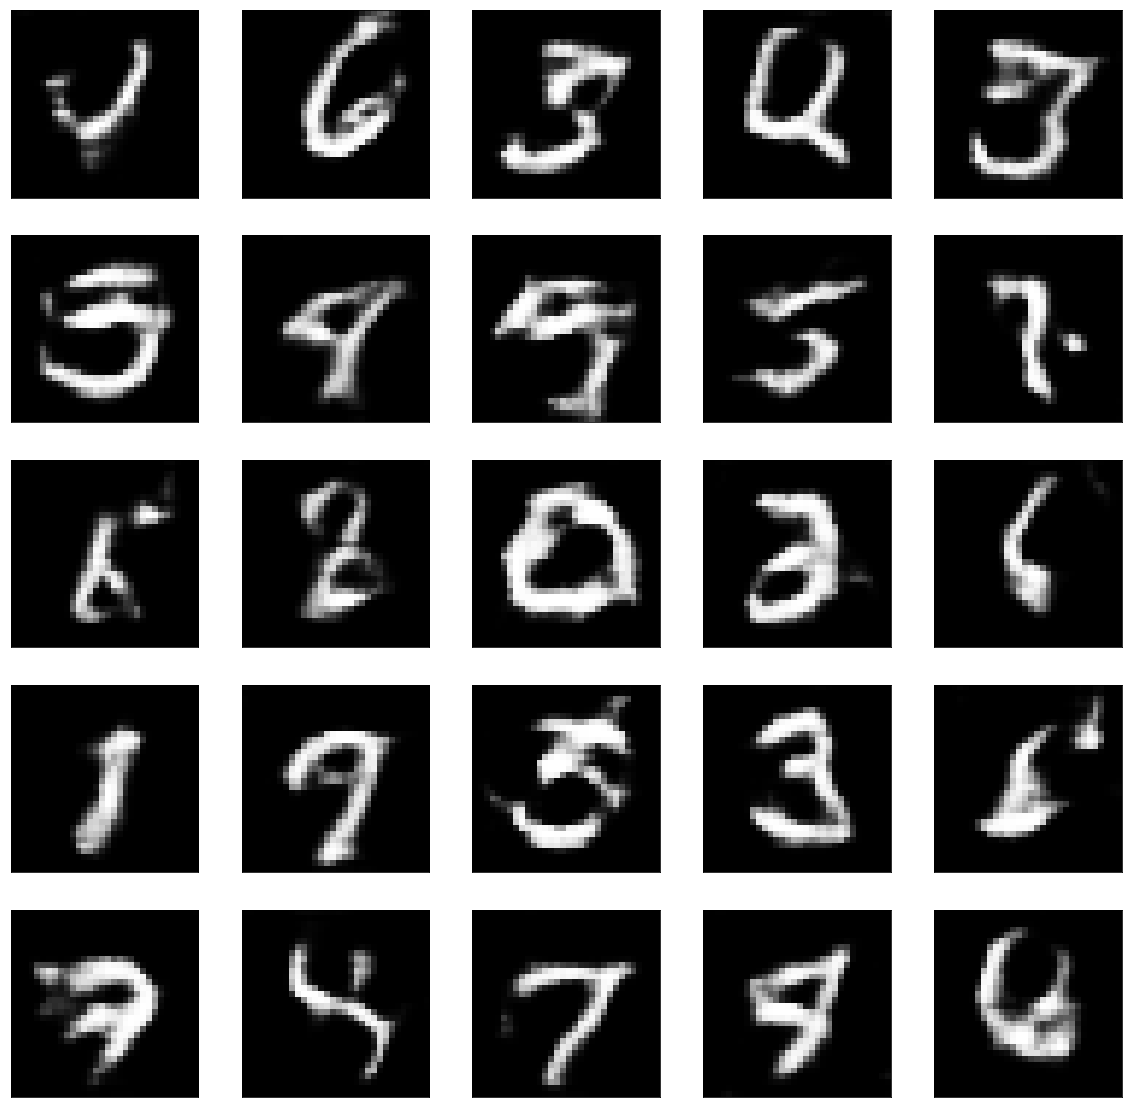

[Epoch 4/10] [Batch 249/938] [Generator loss: 0.894222] [Discriminator loss: 0.468053]
[Epoch 4/10] [Batch 250/938] [Generator loss: 0.599815] [Discriminator loss: 0.662595]
[Epoch 4/10] [Batch 251/938] [Generator loss: 0.564504] [Discriminator loss: 0.612695]
[Epoch 4/10] [Batch 252/938] [Generator loss: 1.220167] [Discriminator loss: 0.593905]
[Epoch 4/10] [Batch 253/938] [Generator loss: 0.771242] [Discriminator loss: 0.732527]
[Epoch 4/10] [Batch 254/938] [Generator loss: 1.232311] [Discriminator loss: 0.542586]
[Epoch 4/10] [Batch 255/938] [Generator loss: 0.753865] [Discriminator loss: 0.521316]
[Epoch 4/10] [Batch 256/938] [Generator loss: 0.626126] [Discriminator loss: 0.645522]
[Epoch 4/10] [Batch 257/938] [Generator loss: 0.765824] [Discriminator loss: 0.591498]
[Epoch 4/10] [Batch 258/938] [Generator loss: 0.656457] [Discriminator loss: 0.616773]
[Epoch 4/10] [Batch 259/938] [Generator loss: 1.129850] [Discriminator loss: 0.740997]
[Epoch 4/10] [Batch 260/938] [Generator los

[Epoch 4/10] [Batch 352/938] [Generator loss: 0.809674] [Discriminator loss: 0.457956]
[Epoch 4/10] [Batch 353/938] [Generator loss: 0.897596] [Discriminator loss: 0.677566]
[Epoch 4/10] [Batch 354/938] [Generator loss: 0.838630] [Discriminator loss: 0.707895]
[Epoch 4/10] [Batch 355/938] [Generator loss: 1.229900] [Discriminator loss: 0.539161]
[Epoch 4/10] [Batch 356/938] [Generator loss: 0.915703] [Discriminator loss: 0.533738]
[Epoch 4/10] [Batch 357/938] [Generator loss: 0.956858] [Discriminator loss: 0.530967]
[Epoch 4/10] [Batch 358/938] [Generator loss: 1.306497] [Discriminator loss: 0.527041]
[Epoch 4/10] [Batch 359/938] [Generator loss: 1.001588] [Discriminator loss: 0.554353]
[Epoch 4/10] [Batch 360/938] [Generator loss: 1.034301] [Discriminator loss: 0.483414]
[Epoch 4/10] [Batch 361/938] [Generator loss: 0.675762] [Discriminator loss: 0.585938]
[Epoch 4/10] [Batch 362/938] [Generator loss: 0.608388] [Discriminator loss: 0.638336]
[Epoch 4/10] [Batch 363/938] [Generator los

[Epoch 4/10] [Batch 454/938] [Generator loss: 0.622349] [Discriminator loss: 0.478889]
[Epoch 4/10] [Batch 455/938] [Generator loss: 0.871570] [Discriminator loss: 0.525836]
[Epoch 4/10] [Batch 456/938] [Generator loss: 0.902435] [Discriminator loss: 0.461406]
[Epoch 4/10] [Batch 457/938] [Generator loss: 0.911216] [Discriminator loss: 0.544431]
[Epoch 4/10] [Batch 458/938] [Generator loss: 0.862882] [Discriminator loss: 0.648198]
[Epoch 4/10] [Batch 459/938] [Generator loss: 1.035832] [Discriminator loss: 0.582902]
[Epoch 4/10] [Batch 460/938] [Generator loss: 1.078858] [Discriminator loss: 0.666415]
[Epoch 4/10] [Batch 461/938] [Generator loss: 1.012706] [Discriminator loss: 0.552423]
[Epoch 4/10] [Batch 462/938] [Generator loss: 0.757416] [Discriminator loss: 0.617638]
[Epoch 4/10] [Batch 463/938] [Generator loss: 0.833626] [Discriminator loss: 0.603286]
[Epoch 4/10] [Batch 464/938] [Generator loss: 1.143566] [Discriminator loss: 0.546210]
[Epoch 4/10] [Batch 465/938] [Generator los

[Epoch 4/10] [Batch 553/938] [Generator loss: 0.654231] [Discriminator loss: 0.545799]
[Epoch 4/10] [Batch 554/938] [Generator loss: 1.072277] [Discriminator loss: 0.418744]
[Epoch 4/10] [Batch 555/938] [Generator loss: 0.812784] [Discriminator loss: 0.652783]
[Epoch 4/10] [Batch 556/938] [Generator loss: 1.065643] [Discriminator loss: 0.600223]
[Epoch 4/10] [Batch 557/938] [Generator loss: 1.127972] [Discriminator loss: 0.480453]
[Epoch 4/10] [Batch 558/938] [Generator loss: 0.781983] [Discriminator loss: 0.544359]
[Epoch 4/10] [Batch 559/938] [Generator loss: 0.893212] [Discriminator loss: 0.647735]
[Epoch 4/10] [Batch 560/938] [Generator loss: 0.572264] [Discriminator loss: 0.722599]
[Epoch 4/10] [Batch 561/938] [Generator loss: 0.754161] [Discriminator loss: 0.557978]
[Epoch 4/10] [Batch 562/938] [Generator loss: 1.200817] [Discriminator loss: 0.552228]
[Epoch 4/10] [Batch 563/938] [Generator loss: 0.840976] [Discriminator loss: 0.661892]
[Epoch 4/10] [Batch 564/938] [Generator los

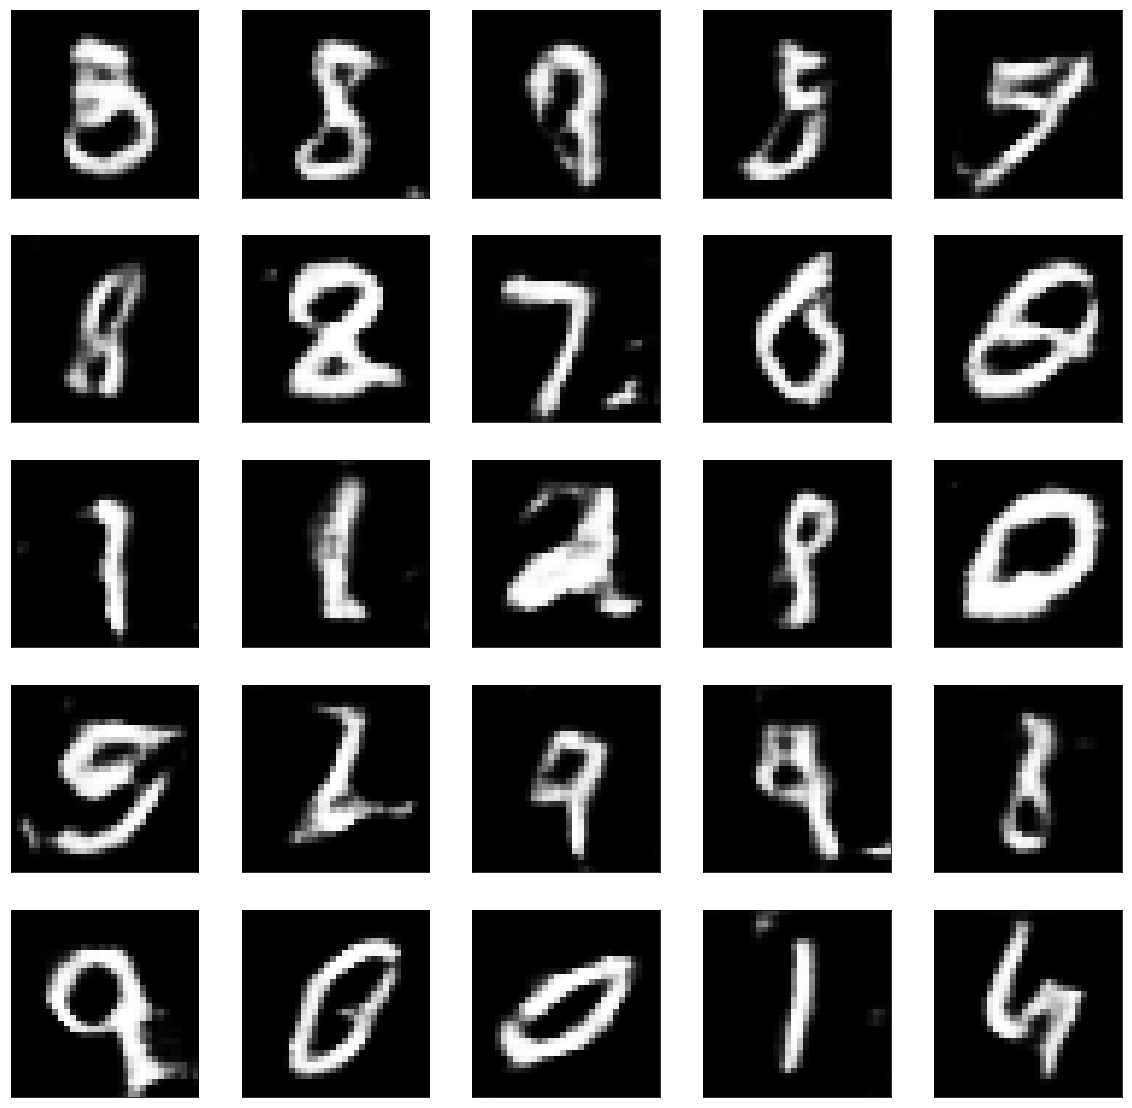

[Epoch 4/10] [Batch 649/938] [Generator loss: 1.107284] [Discriminator loss: 0.604022]
[Epoch 4/10] [Batch 650/938] [Generator loss: 0.943301] [Discriminator loss: 0.445237]
[Epoch 4/10] [Batch 651/938] [Generator loss: 0.803324] [Discriminator loss: 0.437901]
[Epoch 4/10] [Batch 652/938] [Generator loss: 1.035738] [Discriminator loss: 0.631996]
[Epoch 4/10] [Batch 653/938] [Generator loss: 0.987999] [Discriminator loss: 0.620557]
[Epoch 4/10] [Batch 654/938] [Generator loss: 0.815761] [Discriminator loss: 0.537531]
[Epoch 4/10] [Batch 655/938] [Generator loss: 0.754659] [Discriminator loss: 0.475436]
[Epoch 4/10] [Batch 656/938] [Generator loss: 0.903243] [Discriminator loss: 0.495624]
[Epoch 4/10] [Batch 657/938] [Generator loss: 1.109844] [Discriminator loss: 0.432052]
[Epoch 4/10] [Batch 658/938] [Generator loss: 0.962696] [Discriminator loss: 0.471236]
[Epoch 4/10] [Batch 659/938] [Generator loss: 1.241096] [Discriminator loss: 0.548859]
[Epoch 4/10] [Batch 660/938] [Generator los

[Epoch 4/10] [Batch 744/938] [Generator loss: 0.773735] [Discriminator loss: 0.620020]
[Epoch 4/10] [Batch 745/938] [Generator loss: 0.930909] [Discriminator loss: 0.626309]
[Epoch 4/10] [Batch 746/938] [Generator loss: 1.214955] [Discriminator loss: 0.534076]
[Epoch 4/10] [Batch 747/938] [Generator loss: 1.286852] [Discriminator loss: 0.508924]
[Epoch 4/10] [Batch 748/938] [Generator loss: 0.797903] [Discriminator loss: 0.494538]
[Epoch 4/10] [Batch 749/938] [Generator loss: 0.620622] [Discriminator loss: 0.491386]
[Epoch 4/10] [Batch 750/938] [Generator loss: 0.824715] [Discriminator loss: 0.501995]
[Epoch 4/10] [Batch 751/938] [Generator loss: 1.035442] [Discriminator loss: 0.563091]
[Epoch 4/10] [Batch 752/938] [Generator loss: 0.793857] [Discriminator loss: 0.537016]
[Epoch 4/10] [Batch 753/938] [Generator loss: 0.983121] [Discriminator loss: 0.567944]
[Epoch 4/10] [Batch 754/938] [Generator loss: 1.070922] [Discriminator loss: 0.611398]
[Epoch 4/10] [Batch 755/938] [Generator los

[Epoch 4/10] [Batch 841/938] [Generator loss: 1.175865] [Discriminator loss: 0.583496]
[Epoch 4/10] [Batch 842/938] [Generator loss: 0.925340] [Discriminator loss: 0.500035]
[Epoch 4/10] [Batch 843/938] [Generator loss: 0.734077] [Discriminator loss: 0.615492]
[Epoch 4/10] [Batch 844/938] [Generator loss: 1.102015] [Discriminator loss: 0.597863]
[Epoch 4/10] [Batch 845/938] [Generator loss: 1.103901] [Discriminator loss: 0.541396]
[Epoch 4/10] [Batch 846/938] [Generator loss: 1.166510] [Discriminator loss: 0.609746]
[Epoch 4/10] [Batch 847/938] [Generator loss: 0.723815] [Discriminator loss: 0.559008]
[Epoch 4/10] [Batch 848/938] [Generator loss: 0.901706] [Discriminator loss: 0.654602]
[Epoch 4/10] [Batch 849/938] [Generator loss: 0.829686] [Discriminator loss: 0.578351]
[Epoch 4/10] [Batch 850/938] [Generator loss: 0.921757] [Discriminator loss: 0.554869]
[Epoch 4/10] [Batch 851/938] [Generator loss: 0.910122] [Discriminator loss: 0.631950]
[Epoch 4/10] [Batch 852/938] [Generator los

[Epoch 4/10] [Batch 936/938] [Generator loss: 1.394219] [Discriminator loss: 0.617947]
[Epoch 4/10] [Batch 937/938] [Generator loss: 1.766038] [Discriminator loss: 0.369098]
[Epoch 5/10] [Batch 0/938] [Generator loss: 1.075917] [Discriminator loss: 0.580229]
[Epoch 5/10] [Batch 1/938] [Generator loss: 1.019362] [Discriminator loss: 0.580674]
[Epoch 5/10] [Batch 2/938] [Generator loss: 0.652986] [Discriminator loss: 0.433845]
[Epoch 5/10] [Batch 3/938] [Generator loss: 1.007832] [Discriminator loss: 0.508052]
[Epoch 5/10] [Batch 4/938] [Generator loss: 1.100592] [Discriminator loss: 0.507039]
[Epoch 5/10] [Batch 5/938] [Generator loss: 1.290818] [Discriminator loss: 0.601865]
[Epoch 5/10] [Batch 6/938] [Generator loss: 1.386964] [Discriminator loss: 0.456607]
[Epoch 5/10] [Batch 7/938] [Generator loss: 0.658761] [Discriminator loss: 0.717997]
[Epoch 5/10] [Batch 8/938] [Generator loss: 0.648205] [Discriminator loss: 0.538946]
[Epoch 5/10] [Batch 9/938] [Generator loss: 0.947934] [Discri

[Epoch 5/10] [Batch 97/938] [Generator loss: 0.981838] [Discriminator loss: 0.626092]
[Epoch 5/10] [Batch 98/938] [Generator loss: 0.848441] [Discriminator loss: 0.373153]
[Epoch 5/10] [Batch 99/938] [Generator loss: 0.973544] [Discriminator loss: 0.543540]
[Epoch 5/10] [Batch 100/938] [Generator loss: 1.055716] [Discriminator loss: 0.510219]
[Epoch 5/10] [Batch 101/938] [Generator loss: 0.888344] [Discriminator loss: 0.606111]
[Epoch 5/10] [Batch 102/938] [Generator loss: 1.005433] [Discriminator loss: 0.521516]
[Epoch 5/10] [Batch 103/938] [Generator loss: 0.928283] [Discriminator loss: 0.512353]
[Epoch 5/10] [Batch 104/938] [Generator loss: 0.708543] [Discriminator loss: 0.464378]
[Epoch 5/10] [Batch 105/938] [Generator loss: 0.840143] [Discriminator loss: 0.380247]
[Epoch 5/10] [Batch 106/938] [Generator loss: 1.147243] [Discriminator loss: 0.579914]
[Epoch 5/10] [Batch 107/938] [Generator loss: 1.217095] [Discriminator loss: 0.482605]
[Epoch 5/10] [Batch 108/938] [Generator loss: 

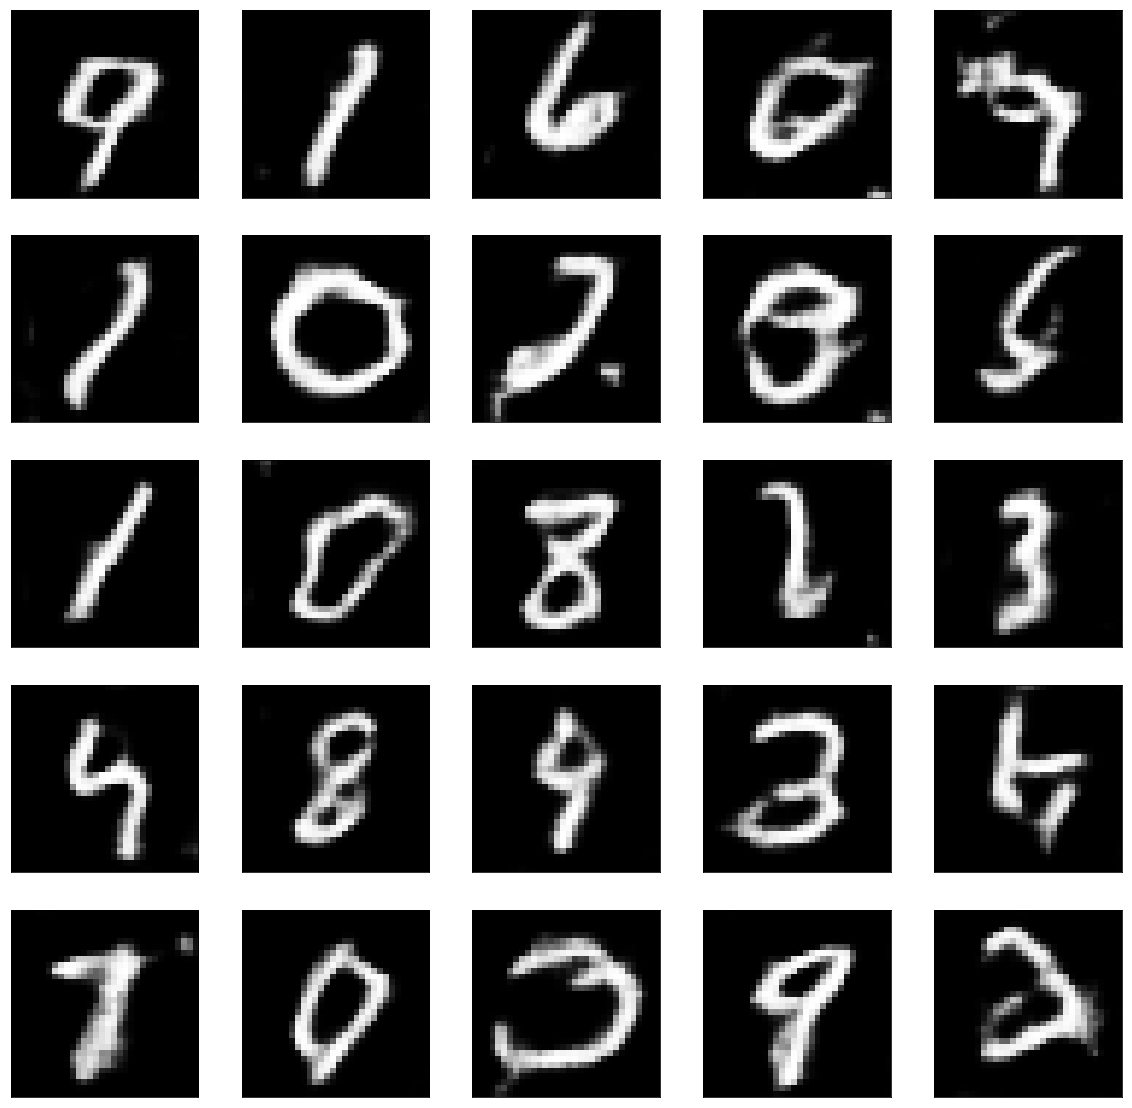

[Epoch 5/10] [Batch 111/938] [Generator loss: 0.831480] [Discriminator loss: 0.639080]
[Epoch 5/10] [Batch 112/938] [Generator loss: 1.093049] [Discriminator loss: 0.597437]
[Epoch 5/10] [Batch 113/938] [Generator loss: 0.822421] [Discriminator loss: 0.439042]
[Epoch 5/10] [Batch 114/938] [Generator loss: 1.060669] [Discriminator loss: 0.398226]
[Epoch 5/10] [Batch 115/938] [Generator loss: 0.672649] [Discriminator loss: 0.462307]
[Epoch 5/10] [Batch 116/938] [Generator loss: 0.913201] [Discriminator loss: 0.476622]
[Epoch 5/10] [Batch 117/938] [Generator loss: 0.861783] [Discriminator loss: 0.641333]
[Epoch 5/10] [Batch 118/938] [Generator loss: 0.799371] [Discriminator loss: 0.509315]
[Epoch 5/10] [Batch 119/938] [Generator loss: 1.244887] [Discriminator loss: 0.480339]
[Epoch 5/10] [Batch 120/938] [Generator loss: 0.875932] [Discriminator loss: 0.514198]
[Epoch 5/10] [Batch 121/938] [Generator loss: 0.999665] [Discriminator loss: 0.605770]
[Epoch 5/10] [Batch 122/938] [Generator los

[Epoch 5/10] [Batch 213/938] [Generator loss: 0.772587] [Discriminator loss: 0.691510]
[Epoch 5/10] [Batch 214/938] [Generator loss: 0.857915] [Discriminator loss: 0.456214]
[Epoch 5/10] [Batch 215/938] [Generator loss: 1.306881] [Discriminator loss: 0.560308]
[Epoch 5/10] [Batch 216/938] [Generator loss: 0.995499] [Discriminator loss: 0.557941]
[Epoch 5/10] [Batch 217/938] [Generator loss: 1.124608] [Discriminator loss: 0.456142]
[Epoch 5/10] [Batch 218/938] [Generator loss: 0.933650] [Discriminator loss: 0.715146]
[Epoch 5/10] [Batch 219/938] [Generator loss: 0.756614] [Discriminator loss: 0.709656]
[Epoch 5/10] [Batch 220/938] [Generator loss: 0.770957] [Discriminator loss: 0.640756]
[Epoch 5/10] [Batch 221/938] [Generator loss: 0.598095] [Discriminator loss: 0.527128]
[Epoch 5/10] [Batch 222/938] [Generator loss: 0.890420] [Discriminator loss: 0.484609]
[Epoch 5/10] [Batch 223/938] [Generator loss: 0.965648] [Discriminator loss: 0.711033]
[Epoch 5/10] [Batch 224/938] [Generator los

[Epoch 5/10] [Batch 313/938] [Generator loss: 0.799537] [Discriminator loss: 0.589559]
[Epoch 5/10] [Batch 314/938] [Generator loss: 1.432509] [Discriminator loss: 0.547124]
[Epoch 5/10] [Batch 315/938] [Generator loss: 0.837599] [Discriminator loss: 0.500910]
[Epoch 5/10] [Batch 316/938] [Generator loss: 0.987188] [Discriminator loss: 0.556099]
[Epoch 5/10] [Batch 317/938] [Generator loss: 0.644612] [Discriminator loss: 0.669919]
[Epoch 5/10] [Batch 318/938] [Generator loss: 1.076986] [Discriminator loss: 0.516957]
[Epoch 5/10] [Batch 319/938] [Generator loss: 1.040981] [Discriminator loss: 0.539093]
[Epoch 5/10] [Batch 320/938] [Generator loss: 1.163014] [Discriminator loss: 0.553854]
[Epoch 5/10] [Batch 321/938] [Generator loss: 0.971008] [Discriminator loss: 0.522450]
[Epoch 5/10] [Batch 322/938] [Generator loss: 1.096949] [Discriminator loss: 0.599792]
[Epoch 5/10] [Batch 323/938] [Generator loss: 1.049941] [Discriminator loss: 0.595181]
[Epoch 5/10] [Batch 324/938] [Generator los

[Epoch 5/10] [Batch 412/938] [Generator loss: 0.587302] [Discriminator loss: 0.543724]
[Epoch 5/10] [Batch 413/938] [Generator loss: 0.896472] [Discriminator loss: 0.592150]
[Epoch 5/10] [Batch 414/938] [Generator loss: 0.903749] [Discriminator loss: 0.633440]
[Epoch 5/10] [Batch 415/938] [Generator loss: 1.099154] [Discriminator loss: 0.498499]
[Epoch 5/10] [Batch 416/938] [Generator loss: 1.649651] [Discriminator loss: 0.400242]
[Epoch 5/10] [Batch 417/938] [Generator loss: 1.317340] [Discriminator loss: 0.402677]
[Epoch 5/10] [Batch 418/938] [Generator loss: 1.039910] [Discriminator loss: 0.494244]
[Epoch 5/10] [Batch 419/938] [Generator loss: 0.804198] [Discriminator loss: 0.683442]
[Epoch 5/10] [Batch 420/938] [Generator loss: 0.921020] [Discriminator loss: 0.560236]
[Epoch 5/10] [Batch 421/938] [Generator loss: 0.896273] [Discriminator loss: 0.443814]
[Epoch 5/10] [Batch 422/938] [Generator loss: 1.009638] [Discriminator loss: 0.493953]
[Epoch 5/10] [Batch 423/938] [Generator los

[Epoch 5/10] [Batch 509/938] [Generator loss: 1.218276] [Discriminator loss: 0.539871]
[Epoch 5/10] [Batch 510/938] [Generator loss: 0.789024] [Discriminator loss: 0.558083]


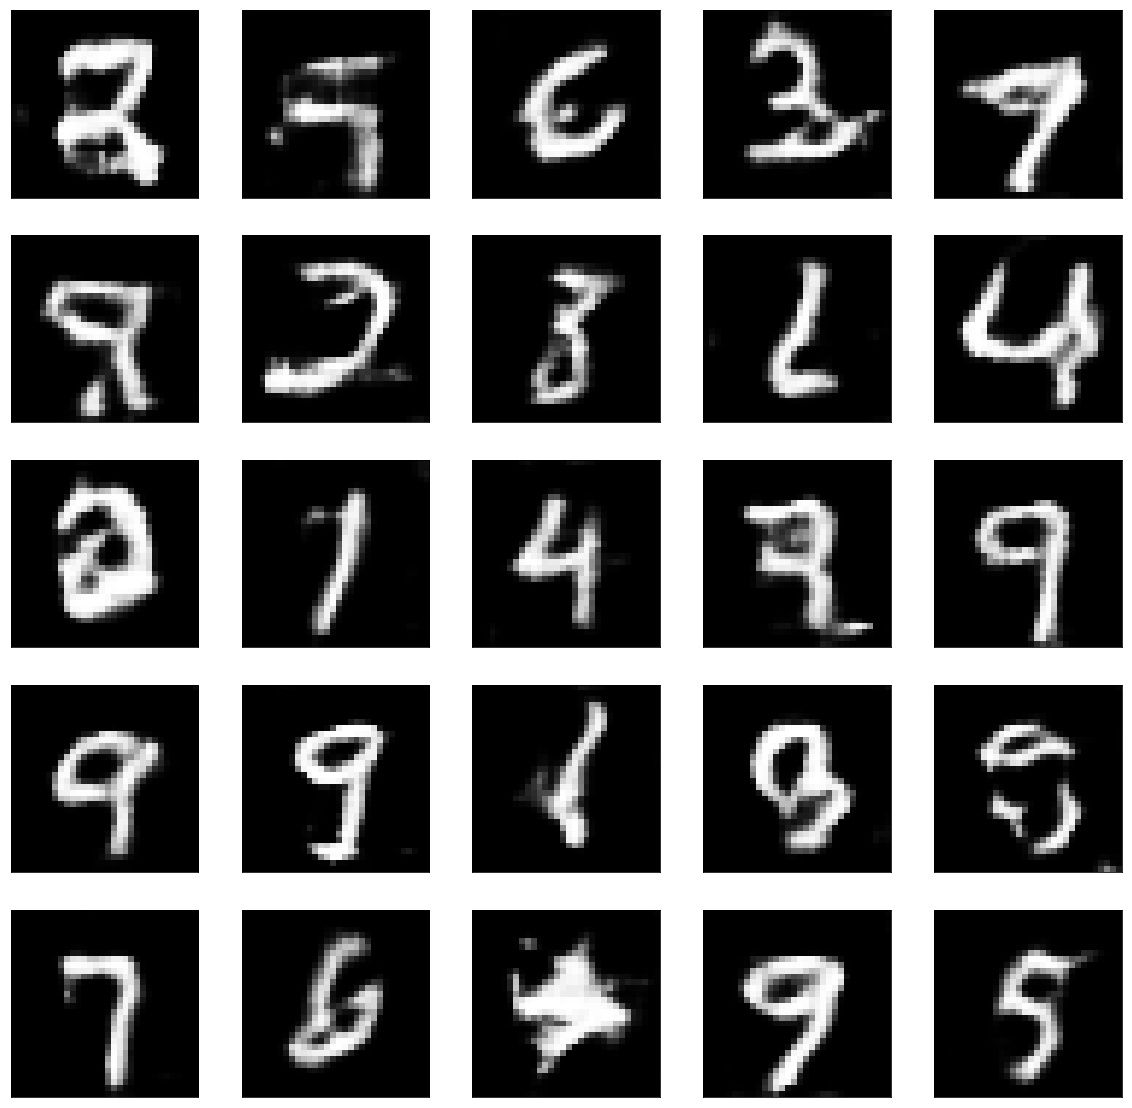

[Epoch 5/10] [Batch 511/938] [Generator loss: 1.098034] [Discriminator loss: 0.445622]
[Epoch 5/10] [Batch 512/938] [Generator loss: 0.992696] [Discriminator loss: 0.785601]
[Epoch 5/10] [Batch 513/938] [Generator loss: 1.176086] [Discriminator loss: 0.427429]
[Epoch 5/10] [Batch 514/938] [Generator loss: 0.755899] [Discriminator loss: 0.563136]
[Epoch 5/10] [Batch 515/938] [Generator loss: 1.030502] [Discriminator loss: 0.545884]
[Epoch 5/10] [Batch 516/938] [Generator loss: 0.806148] [Discriminator loss: 0.611788]
[Epoch 5/10] [Batch 517/938] [Generator loss: 1.353364] [Discriminator loss: 0.587200]
[Epoch 5/10] [Batch 518/938] [Generator loss: 1.466171] [Discriminator loss: 0.582820]
[Epoch 5/10] [Batch 519/938] [Generator loss: 1.009040] [Discriminator loss: 0.383679]
[Epoch 5/10] [Batch 520/938] [Generator loss: 0.815272] [Discriminator loss: 0.652372]
[Epoch 5/10] [Batch 521/938] [Generator loss: 1.149006] [Discriminator loss: 0.590435]
[Epoch 5/10] [Batch 522/938] [Generator los

[Epoch 5/10] [Batch 606/938] [Generator loss: 0.593481] [Discriminator loss: 0.553936]
[Epoch 5/10] [Batch 607/938] [Generator loss: 1.268337] [Discriminator loss: 0.494935]
[Epoch 5/10] [Batch 608/938] [Generator loss: 1.452577] [Discriminator loss: 0.782037]
[Epoch 5/10] [Batch 609/938] [Generator loss: 0.598236] [Discriminator loss: 0.413913]
[Epoch 5/10] [Batch 610/938] [Generator loss: 0.952321] [Discriminator loss: 0.563883]
[Epoch 5/10] [Batch 611/938] [Generator loss: 1.041798] [Discriminator loss: 0.448442]
[Epoch 5/10] [Batch 612/938] [Generator loss: 0.549088] [Discriminator loss: 0.531839]
[Epoch 5/10] [Batch 613/938] [Generator loss: 1.071244] [Discriminator loss: 0.557005]
[Epoch 5/10] [Batch 614/938] [Generator loss: 0.992411] [Discriminator loss: 0.495317]
[Epoch 5/10] [Batch 615/938] [Generator loss: 1.482794] [Discriminator loss: 0.582448]
[Epoch 5/10] [Batch 616/938] [Generator loss: 0.944618] [Discriminator loss: 0.522328]
[Epoch 5/10] [Batch 617/938] [Generator los

[Epoch 5/10] [Batch 706/938] [Generator loss: 1.386904] [Discriminator loss: 0.762600]
[Epoch 5/10] [Batch 707/938] [Generator loss: 1.015752] [Discriminator loss: 0.485195]
[Epoch 5/10] [Batch 708/938] [Generator loss: 1.161422] [Discriminator loss: 0.794610]
[Epoch 5/10] [Batch 709/938] [Generator loss: 0.693700] [Discriminator loss: 0.597925]
[Epoch 5/10] [Batch 710/938] [Generator loss: 0.944288] [Discriminator loss: 0.472674]
[Epoch 5/10] [Batch 711/938] [Generator loss: 0.835842] [Discriminator loss: 0.469710]
[Epoch 5/10] [Batch 712/938] [Generator loss: 1.297020] [Discriminator loss: 0.562935]
[Epoch 5/10] [Batch 713/938] [Generator loss: 1.012888] [Discriminator loss: 0.557642]
[Epoch 5/10] [Batch 714/938] [Generator loss: 1.235071] [Discriminator loss: 0.553044]
[Epoch 5/10] [Batch 715/938] [Generator loss: 0.693752] [Discriminator loss: 0.591688]
[Epoch 5/10] [Batch 716/938] [Generator loss: 0.943609] [Discriminator loss: 0.545872]
[Epoch 5/10] [Batch 717/938] [Generator los

[Epoch 5/10] [Batch 805/938] [Generator loss: 0.690130] [Discriminator loss: 0.576388]
[Epoch 5/10] [Batch 806/938] [Generator loss: 0.838637] [Discriminator loss: 0.368421]
[Epoch 5/10] [Batch 807/938] [Generator loss: 0.934822] [Discriminator loss: 0.435387]
[Epoch 5/10] [Batch 808/938] [Generator loss: 1.000101] [Discriminator loss: 0.391948]
[Epoch 5/10] [Batch 809/938] [Generator loss: 0.763155] [Discriminator loss: 0.723503]
[Epoch 5/10] [Batch 810/938] [Generator loss: 0.750210] [Discriminator loss: 0.536923]
[Epoch 5/10] [Batch 811/938] [Generator loss: 1.281784] [Discriminator loss: 0.389276]
[Epoch 5/10] [Batch 812/938] [Generator loss: 0.859488] [Discriminator loss: 0.696651]
[Epoch 5/10] [Batch 813/938] [Generator loss: 1.088071] [Discriminator loss: 0.592999]
[Epoch 5/10] [Batch 814/938] [Generator loss: 0.818741] [Discriminator loss: 0.654864]
[Epoch 5/10] [Batch 815/938] [Generator loss: 1.175356] [Discriminator loss: 0.451580]
[Epoch 5/10] [Batch 816/938] [Generator los

[Epoch 5/10] [Batch 905/938] [Generator loss: 0.820863] [Discriminator loss: 0.423117]
[Epoch 5/10] [Batch 906/938] [Generator loss: 0.655888] [Discriminator loss: 0.502413]
[Epoch 5/10] [Batch 907/938] [Generator loss: 0.775904] [Discriminator loss: 0.504081]
[Epoch 5/10] [Batch 908/938] [Generator loss: 1.337041] [Discriminator loss: 0.511564]
[Epoch 5/10] [Batch 909/938] [Generator loss: 1.472869] [Discriminator loss: 0.478026]
[Epoch 5/10] [Batch 910/938] [Generator loss: 1.610890] [Discriminator loss: 0.487559]


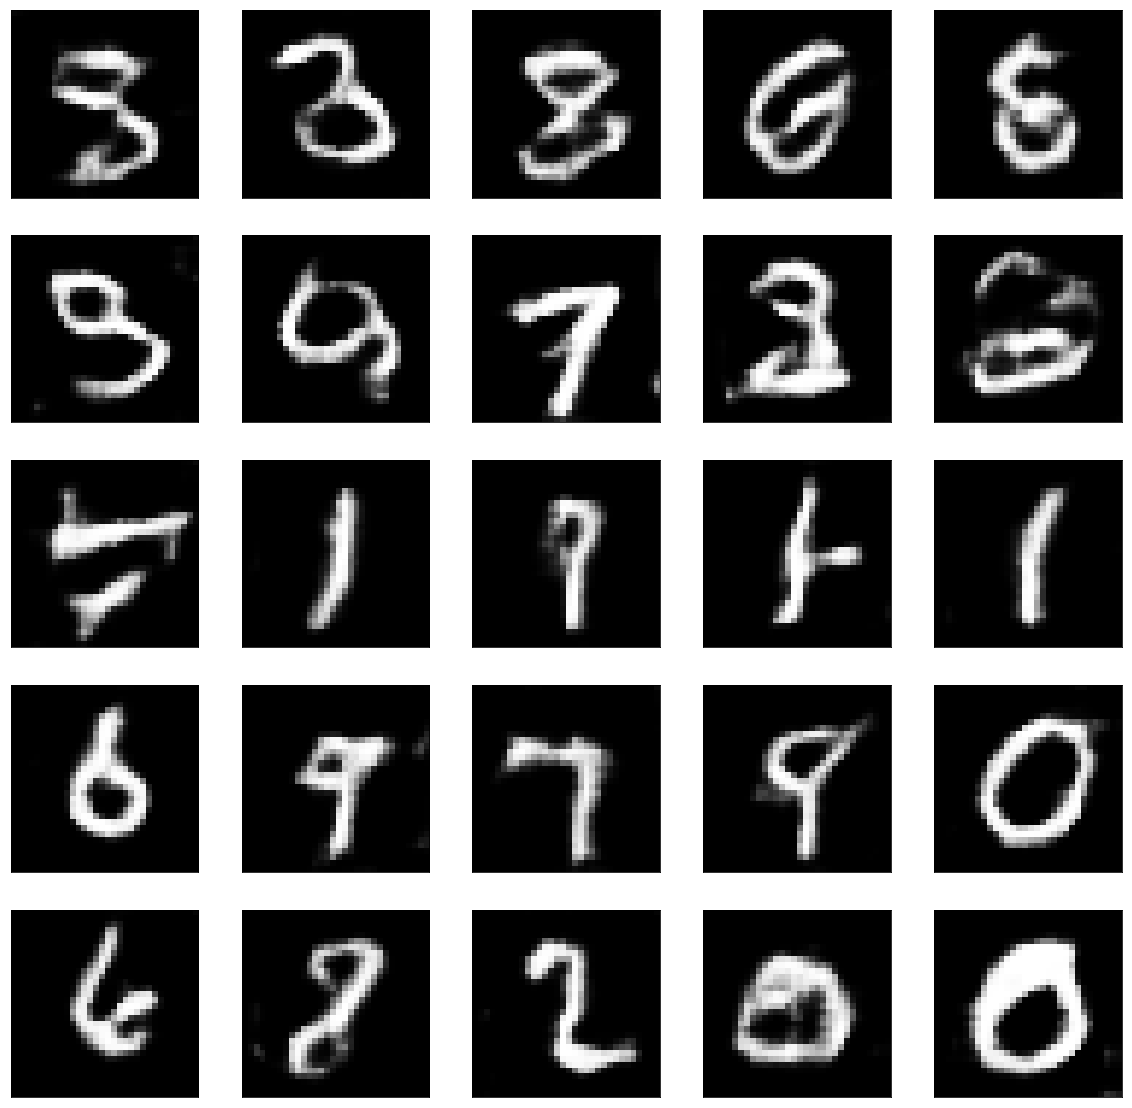

[Epoch 5/10] [Batch 911/938] [Generator loss: 0.767083] [Discriminator loss: 0.421388]
[Epoch 5/10] [Batch 912/938] [Generator loss: 0.512910] [Discriminator loss: 0.668717]
[Epoch 5/10] [Batch 913/938] [Generator loss: 0.728492] [Discriminator loss: 0.580280]
[Epoch 5/10] [Batch 914/938] [Generator loss: 0.511342] [Discriminator loss: 0.520751]
[Epoch 5/10] [Batch 915/938] [Generator loss: 1.302270] [Discriminator loss: 0.433626]
[Epoch 5/10] [Batch 916/938] [Generator loss: 1.031457] [Discriminator loss: 0.671380]
[Epoch 5/10] [Batch 917/938] [Generator loss: 0.551261] [Discriminator loss: 0.642642]
[Epoch 5/10] [Batch 918/938] [Generator loss: 0.796315] [Discriminator loss: 0.566199]
[Epoch 5/10] [Batch 919/938] [Generator loss: 1.036881] [Discriminator loss: 0.656410]
[Epoch 5/10] [Batch 920/938] [Generator loss: 1.204099] [Discriminator loss: 0.481489]
[Epoch 5/10] [Batch 921/938] [Generator loss: 1.127922] [Discriminator loss: 0.475951]
[Epoch 5/10] [Batch 922/938] [Generator los

[Epoch 6/10] [Batch 69/938] [Generator loss: 1.175599] [Discriminator loss: 0.476956]
[Epoch 6/10] [Batch 70/938] [Generator loss: 1.434887] [Discriminator loss: 0.589048]
[Epoch 6/10] [Batch 71/938] [Generator loss: 1.042289] [Discriminator loss: 0.654931]
[Epoch 6/10] [Batch 72/938] [Generator loss: 0.583183] [Discriminator loss: 0.570209]
[Epoch 6/10] [Batch 73/938] [Generator loss: 0.962077] [Discriminator loss: 0.515319]
[Epoch 6/10] [Batch 74/938] [Generator loss: 0.857297] [Discriminator loss: 0.527111]
[Epoch 6/10] [Batch 75/938] [Generator loss: 1.142501] [Discriminator loss: 0.470663]
[Epoch 6/10] [Batch 76/938] [Generator loss: 0.831199] [Discriminator loss: 0.522897]
[Epoch 6/10] [Batch 77/938] [Generator loss: 0.881780] [Discriminator loss: 0.638056]
[Epoch 6/10] [Batch 78/938] [Generator loss: 0.713139] [Discriminator loss: 0.505311]
[Epoch 6/10] [Batch 79/938] [Generator loss: 1.080656] [Discriminator loss: 0.461832]
[Epoch 6/10] [Batch 80/938] [Generator loss: 1.234728]

[Epoch 6/10] [Batch 167/938] [Generator loss: 1.193384] [Discriminator loss: 0.413444]
[Epoch 6/10] [Batch 168/938] [Generator loss: 1.653438] [Discriminator loss: 0.704287]
[Epoch 6/10] [Batch 169/938] [Generator loss: 1.363530] [Discriminator loss: 0.504830]
[Epoch 6/10] [Batch 170/938] [Generator loss: 0.991058] [Discriminator loss: 0.488603]
[Epoch 6/10] [Batch 171/938] [Generator loss: 0.612908] [Discriminator loss: 0.619510]
[Epoch 6/10] [Batch 172/938] [Generator loss: 0.873944] [Discriminator loss: 0.732337]
[Epoch 6/10] [Batch 173/938] [Generator loss: 1.683479] [Discriminator loss: 0.623740]
[Epoch 6/10] [Batch 174/938] [Generator loss: 1.135678] [Discriminator loss: 0.591983]
[Epoch 6/10] [Batch 175/938] [Generator loss: 1.666596] [Discriminator loss: 0.430437]
[Epoch 6/10] [Batch 176/938] [Generator loss: 0.660116] [Discriminator loss: 0.548679]
[Epoch 6/10] [Batch 177/938] [Generator loss: 0.755865] [Discriminator loss: 0.534124]
[Epoch 6/10] [Batch 178/938] [Generator los

[Epoch 6/10] [Batch 266/938] [Generator loss: 0.972821] [Discriminator loss: 0.592884]
[Epoch 6/10] [Batch 267/938] [Generator loss: 0.748914] [Discriminator loss: 0.543937]
[Epoch 6/10] [Batch 268/938] [Generator loss: 0.745420] [Discriminator loss: 0.547345]
[Epoch 6/10] [Batch 269/938] [Generator loss: 0.861846] [Discriminator loss: 0.430968]
[Epoch 6/10] [Batch 270/938] [Generator loss: 1.177017] [Discriminator loss: 0.474767]
[Epoch 6/10] [Batch 271/938] [Generator loss: 0.710725] [Discriminator loss: 0.491211]
[Epoch 6/10] [Batch 272/938] [Generator loss: 1.187485] [Discriminator loss: 0.539922]
[Epoch 6/10] [Batch 273/938] [Generator loss: 1.117221] [Discriminator loss: 0.432562]
[Epoch 6/10] [Batch 274/938] [Generator loss: 1.118218] [Discriminator loss: 0.436984]
[Epoch 6/10] [Batch 275/938] [Generator loss: 1.639370] [Discriminator loss: 0.515185]
[Epoch 6/10] [Batch 276/938] [Generator loss: 1.295457] [Discriminator loss: 0.534014]
[Epoch 6/10] [Batch 277/938] [Generator los

[Epoch 6/10] [Batch 369/938] [Generator loss: 1.739731] [Discriminator loss: 0.762644]
[Epoch 6/10] [Batch 370/938] [Generator loss: 1.278280] [Discriminator loss: 0.691251]
[Epoch 6/10] [Batch 371/938] [Generator loss: 1.272528] [Discriminator loss: 0.574955]
[Epoch 6/10] [Batch 372/938] [Generator loss: 0.306600] [Discriminator loss: 0.742642]


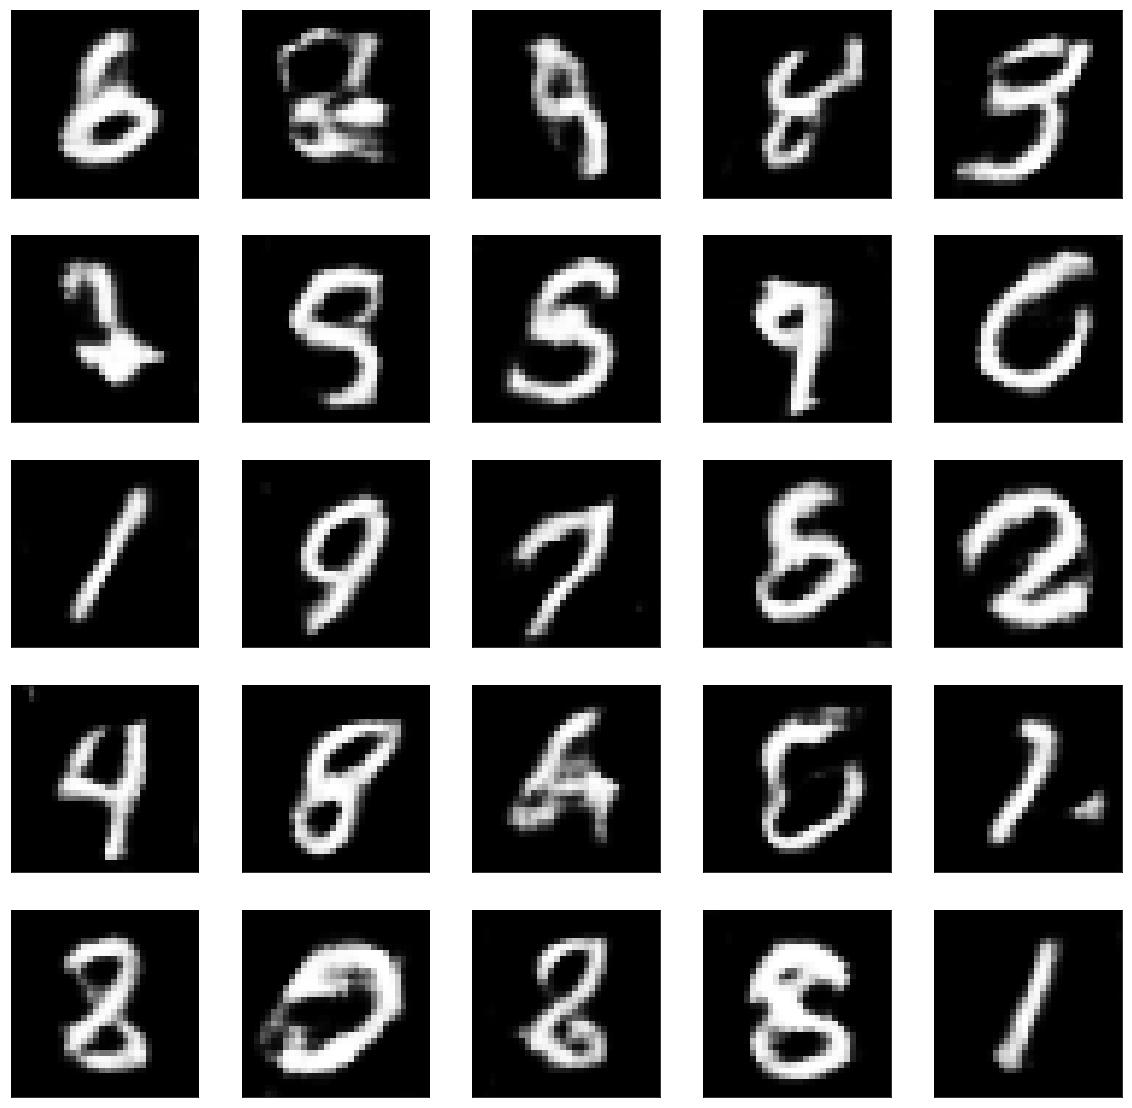

[Epoch 6/10] [Batch 373/938] [Generator loss: 0.910101] [Discriminator loss: 0.575853]
[Epoch 6/10] [Batch 374/938] [Generator loss: 1.463015] [Discriminator loss: 0.506211]
[Epoch 6/10] [Batch 375/938] [Generator loss: 0.844909] [Discriminator loss: 0.510070]
[Epoch 6/10] [Batch 376/938] [Generator loss: 1.184762] [Discriminator loss: 0.433223]
[Epoch 6/10] [Batch 377/938] [Generator loss: 0.807021] [Discriminator loss: 0.519649]
[Epoch 6/10] [Batch 378/938] [Generator loss: 1.529218] [Discriminator loss: 0.621133]
[Epoch 6/10] [Batch 379/938] [Generator loss: 1.339774] [Discriminator loss: 0.432049]
[Epoch 6/10] [Batch 380/938] [Generator loss: 1.306358] [Discriminator loss: 0.554707]
[Epoch 6/10] [Batch 381/938] [Generator loss: 1.311163] [Discriminator loss: 0.614024]
[Epoch 6/10] [Batch 382/938] [Generator loss: 0.802376] [Discriminator loss: 0.769622]
[Epoch 6/10] [Batch 383/938] [Generator loss: 1.044116] [Discriminator loss: 0.789039]
[Epoch 6/10] [Batch 384/938] [Generator los

[Epoch 6/10] [Batch 475/938] [Generator loss: 1.184338] [Discriminator loss: 0.376789]
[Epoch 6/10] [Batch 476/938] [Generator loss: 1.475987] [Discriminator loss: 0.640354]
[Epoch 6/10] [Batch 477/938] [Generator loss: 0.985348] [Discriminator loss: 0.445140]
[Epoch 6/10] [Batch 478/938] [Generator loss: 0.838505] [Discriminator loss: 0.491706]
[Epoch 6/10] [Batch 479/938] [Generator loss: 0.882967] [Discriminator loss: 0.636194]
[Epoch 6/10] [Batch 480/938] [Generator loss: 1.022452] [Discriminator loss: 0.574675]
[Epoch 6/10] [Batch 481/938] [Generator loss: 1.291157] [Discriminator loss: 0.695464]
[Epoch 6/10] [Batch 482/938] [Generator loss: 0.883686] [Discriminator loss: 0.420120]
[Epoch 6/10] [Batch 483/938] [Generator loss: 0.994304] [Discriminator loss: 0.405519]
[Epoch 6/10] [Batch 484/938] [Generator loss: 0.885269] [Discriminator loss: 0.456887]
[Epoch 6/10] [Batch 485/938] [Generator loss: 0.603563] [Discriminator loss: 0.447305]
[Epoch 6/10] [Batch 486/938] [Generator los

[Epoch 6/10] [Batch 570/938] [Generator loss: 1.283858] [Discriminator loss: 0.641752]
[Epoch 6/10] [Batch 571/938] [Generator loss: 1.156661] [Discriminator loss: 0.654737]
[Epoch 6/10] [Batch 572/938] [Generator loss: 1.033959] [Discriminator loss: 0.513731]
[Epoch 6/10] [Batch 573/938] [Generator loss: 0.870377] [Discriminator loss: 0.591871]
[Epoch 6/10] [Batch 574/938] [Generator loss: 1.131614] [Discriminator loss: 0.315889]
[Epoch 6/10] [Batch 575/938] [Generator loss: 1.453975] [Discriminator loss: 0.451375]
[Epoch 6/10] [Batch 576/938] [Generator loss: 1.021106] [Discriminator loss: 0.456538]
[Epoch 6/10] [Batch 577/938] [Generator loss: 1.116356] [Discriminator loss: 0.441591]
[Epoch 6/10] [Batch 578/938] [Generator loss: 0.814469] [Discriminator loss: 0.462466]
[Epoch 6/10] [Batch 579/938] [Generator loss: 0.818840] [Discriminator loss: 0.491029]
[Epoch 6/10] [Batch 580/938] [Generator loss: 0.910762] [Discriminator loss: 0.461820]
[Epoch 6/10] [Batch 581/938] [Generator los

[Epoch 6/10] [Batch 665/938] [Generator loss: 1.059223] [Discriminator loss: 0.455972]
[Epoch 6/10] [Batch 666/938] [Generator loss: 1.116621] [Discriminator loss: 0.517731]
[Epoch 6/10] [Batch 667/938] [Generator loss: 1.347984] [Discriminator loss: 0.664019]
[Epoch 6/10] [Batch 668/938] [Generator loss: 1.429212] [Discriminator loss: 0.532689]
[Epoch 6/10] [Batch 669/938] [Generator loss: 1.216022] [Discriminator loss: 0.829145]
[Epoch 6/10] [Batch 670/938] [Generator loss: 1.095861] [Discriminator loss: 0.665766]
[Epoch 6/10] [Batch 671/938] [Generator loss: 0.692650] [Discriminator loss: 0.520334]
[Epoch 6/10] [Batch 672/938] [Generator loss: 1.094394] [Discriminator loss: 0.408135]
[Epoch 6/10] [Batch 673/938] [Generator loss: 0.860362] [Discriminator loss: 0.496825]
[Epoch 6/10] [Batch 674/938] [Generator loss: 1.063724] [Discriminator loss: 0.676104]
[Epoch 6/10] [Batch 675/938] [Generator loss: 0.975728] [Discriminator loss: 0.617170]
[Epoch 6/10] [Batch 676/938] [Generator los

[Epoch 6/10] [Batch 766/938] [Generator loss: 0.998237] [Discriminator loss: 0.453052]
[Epoch 6/10] [Batch 767/938] [Generator loss: 0.809670] [Discriminator loss: 0.464500]
[Epoch 6/10] [Batch 768/938] [Generator loss: 1.202825] [Discriminator loss: 0.633753]
[Epoch 6/10] [Batch 769/938] [Generator loss: 1.378741] [Discriminator loss: 0.608401]
[Epoch 6/10] [Batch 770/938] [Generator loss: 1.025253] [Discriminator loss: 0.599388]
[Epoch 6/10] [Batch 771/938] [Generator loss: 0.998865] [Discriminator loss: 0.662124]
[Epoch 6/10] [Batch 772/938] [Generator loss: 0.825327] [Discriminator loss: 0.381404]


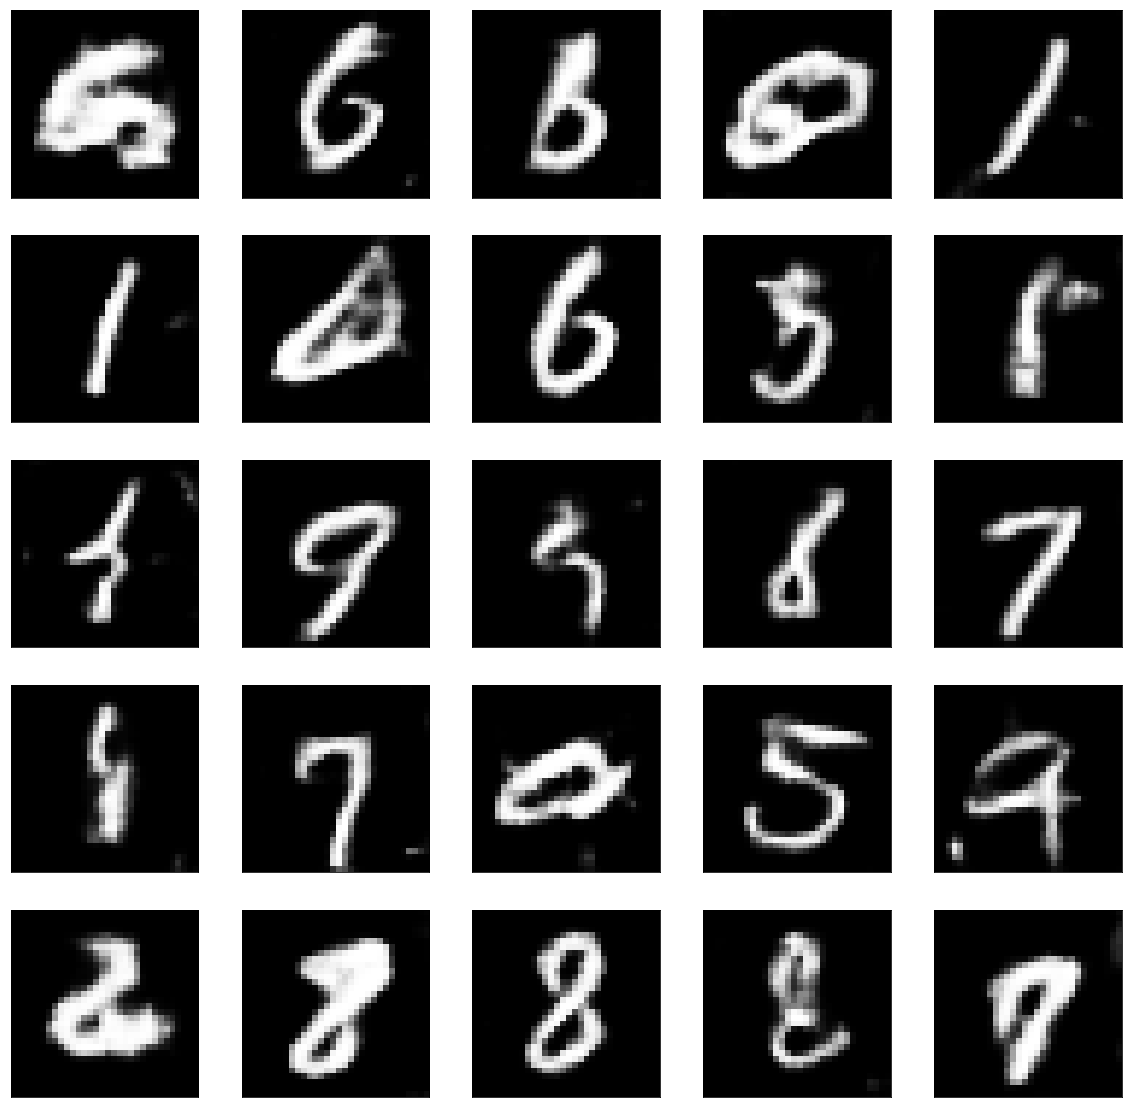

[Epoch 6/10] [Batch 773/938] [Generator loss: 1.259278] [Discriminator loss: 0.448293]
[Epoch 6/10] [Batch 774/938] [Generator loss: 0.911546] [Discriminator loss: 0.680949]
[Epoch 6/10] [Batch 775/938] [Generator loss: 0.847757] [Discriminator loss: 0.422531]
[Epoch 6/10] [Batch 776/938] [Generator loss: 0.797542] [Discriminator loss: 0.641690]
[Epoch 6/10] [Batch 777/938] [Generator loss: 0.888323] [Discriminator loss: 0.612740]
[Epoch 6/10] [Batch 778/938] [Generator loss: 1.283777] [Discriminator loss: 0.548678]
[Epoch 6/10] [Batch 779/938] [Generator loss: 0.790873] [Discriminator loss: 0.544604]
[Epoch 6/10] [Batch 780/938] [Generator loss: 0.540045] [Discriminator loss: 0.588625]
[Epoch 6/10] [Batch 781/938] [Generator loss: 1.062291] [Discriminator loss: 0.668185]
[Epoch 6/10] [Batch 782/938] [Generator loss: 1.028469] [Discriminator loss: 0.532171]
[Epoch 6/10] [Batch 783/938] [Generator loss: 0.920766] [Discriminator loss: 0.488965]
[Epoch 6/10] [Batch 784/938] [Generator los

[Epoch 6/10] [Batch 875/938] [Generator loss: 0.993074] [Discriminator loss: 0.523440]
[Epoch 6/10] [Batch 876/938] [Generator loss: 1.124377] [Discriminator loss: 0.630862]
[Epoch 6/10] [Batch 877/938] [Generator loss: 1.185054] [Discriminator loss: 0.475550]
[Epoch 6/10] [Batch 878/938] [Generator loss: 1.189615] [Discriminator loss: 0.443665]
[Epoch 6/10] [Batch 879/938] [Generator loss: 1.215813] [Discriminator loss: 0.392553]
[Epoch 6/10] [Batch 880/938] [Generator loss: 1.287422] [Discriminator loss: 0.507596]
[Epoch 6/10] [Batch 881/938] [Generator loss: 0.788832] [Discriminator loss: 0.484436]
[Epoch 6/10] [Batch 882/938] [Generator loss: 1.077487] [Discriminator loss: 0.503389]
[Epoch 6/10] [Batch 883/938] [Generator loss: 0.605909] [Discriminator loss: 0.570426]
[Epoch 6/10] [Batch 884/938] [Generator loss: 0.622061] [Discriminator loss: 0.580975]
[Epoch 6/10] [Batch 885/938] [Generator loss: 0.764819] [Discriminator loss: 0.376595]
[Epoch 6/10] [Batch 886/938] [Generator los

[Epoch 7/10] [Batch 36/938] [Generator loss: 1.195704] [Discriminator loss: 0.416547]
[Epoch 7/10] [Batch 37/938] [Generator loss: 1.448688] [Discriminator loss: 0.680601]
[Epoch 7/10] [Batch 38/938] [Generator loss: 1.478567] [Discriminator loss: 0.440606]
[Epoch 7/10] [Batch 39/938] [Generator loss: 0.524384] [Discriminator loss: 0.602615]
[Epoch 7/10] [Batch 40/938] [Generator loss: 1.133888] [Discriminator loss: 0.720595]
[Epoch 7/10] [Batch 41/938] [Generator loss: 0.807199] [Discriminator loss: 0.717470]
[Epoch 7/10] [Batch 42/938] [Generator loss: 0.744243] [Discriminator loss: 0.550479]
[Epoch 7/10] [Batch 43/938] [Generator loss: 1.171457] [Discriminator loss: 0.591546]
[Epoch 7/10] [Batch 44/938] [Generator loss: 1.121629] [Discriminator loss: 0.482652]
[Epoch 7/10] [Batch 45/938] [Generator loss: 1.322615] [Discriminator loss: 0.473413]
[Epoch 7/10] [Batch 46/938] [Generator loss: 1.198239] [Discriminator loss: 0.680679]
[Epoch 7/10] [Batch 47/938] [Generator loss: 1.158898]

[Epoch 7/10] [Batch 135/938] [Generator loss: 0.593981] [Discriminator loss: 0.541350]
[Epoch 7/10] [Batch 136/938] [Generator loss: 1.245755] [Discriminator loss: 0.496239]
[Epoch 7/10] [Batch 137/938] [Generator loss: 0.799746] [Discriminator loss: 0.560510]
[Epoch 7/10] [Batch 138/938] [Generator loss: 0.970044] [Discriminator loss: 0.643288]
[Epoch 7/10] [Batch 139/938] [Generator loss: 0.739891] [Discriminator loss: 0.391863]
[Epoch 7/10] [Batch 140/938] [Generator loss: 0.777671] [Discriminator loss: 0.307030]
[Epoch 7/10] [Batch 141/938] [Generator loss: 0.993206] [Discriminator loss: 0.408074]
[Epoch 7/10] [Batch 142/938] [Generator loss: 1.374249] [Discriminator loss: 0.563219]
[Epoch 7/10] [Batch 143/938] [Generator loss: 1.002563] [Discriminator loss: 0.714667]
[Epoch 7/10] [Batch 144/938] [Generator loss: 0.910622] [Discriminator loss: 0.514158]
[Epoch 7/10] [Batch 145/938] [Generator loss: 1.139125] [Discriminator loss: 0.550846]
[Epoch 7/10] [Batch 146/938] [Generator los

[Epoch 7/10] [Batch 230/938] [Generator loss: 1.021066] [Discriminator loss: 0.574512]
[Epoch 7/10] [Batch 231/938] [Generator loss: 1.262166] [Discriminator loss: 0.472436]
[Epoch 7/10] [Batch 232/938] [Generator loss: 0.964742] [Discriminator loss: 0.608286]
[Epoch 7/10] [Batch 233/938] [Generator loss: 1.366909] [Discriminator loss: 0.497214]
[Epoch 7/10] [Batch 234/938] [Generator loss: 1.942673] [Discriminator loss: 0.437895]


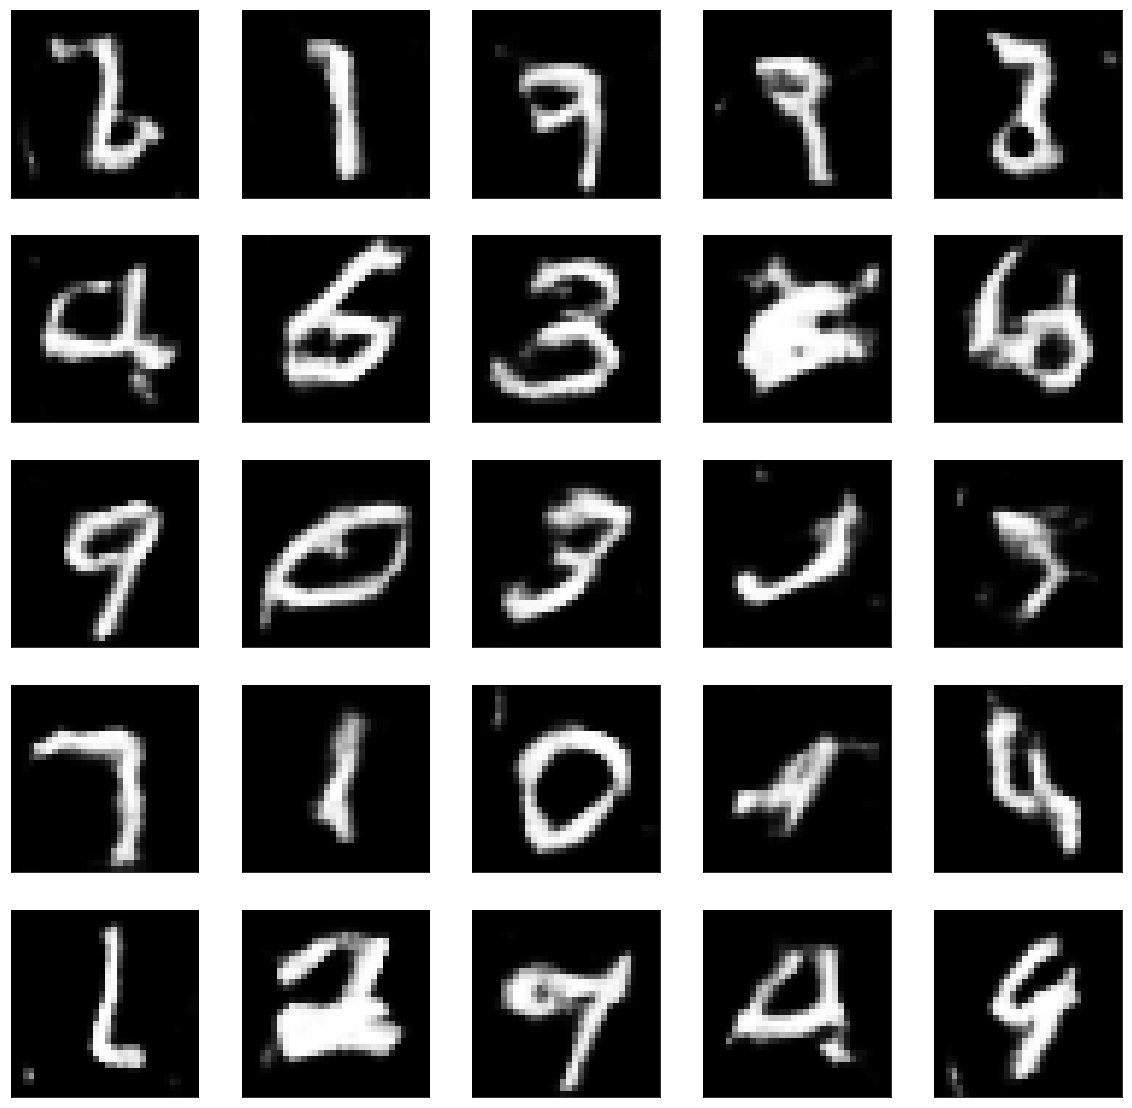

[Epoch 7/10] [Batch 235/938] [Generator loss: 1.494210] [Discriminator loss: 0.548444]
[Epoch 7/10] [Batch 236/938] [Generator loss: 0.806717] [Discriminator loss: 0.487713]
[Epoch 7/10] [Batch 237/938] [Generator loss: 0.402055] [Discriminator loss: 0.703251]
[Epoch 7/10] [Batch 238/938] [Generator loss: 1.053426] [Discriminator loss: 0.433185]
[Epoch 7/10] [Batch 239/938] [Generator loss: 1.436275] [Discriminator loss: 0.329062]
[Epoch 7/10] [Batch 240/938] [Generator loss: 1.880581] [Discriminator loss: 0.414416]
[Epoch 7/10] [Batch 241/938] [Generator loss: 0.984104] [Discriminator loss: 0.417594]
[Epoch 7/10] [Batch 242/938] [Generator loss: 1.187760] [Discriminator loss: 0.504976]
[Epoch 7/10] [Batch 243/938] [Generator loss: 1.108598] [Discriminator loss: 0.372596]
[Epoch 7/10] [Batch 244/938] [Generator loss: 1.120157] [Discriminator loss: 0.555900]
[Epoch 7/10] [Batch 245/938] [Generator loss: 1.206795] [Discriminator loss: 0.565592]
[Epoch 7/10] [Batch 246/938] [Generator los

[Epoch 7/10] [Batch 337/938] [Generator loss: 1.391950] [Discriminator loss: 0.651502]
[Epoch 7/10] [Batch 338/938] [Generator loss: 1.302890] [Discriminator loss: 0.539593]
[Epoch 7/10] [Batch 339/938] [Generator loss: 0.753846] [Discriminator loss: 0.538047]
[Epoch 7/10] [Batch 340/938] [Generator loss: 0.512797] [Discriminator loss: 0.468882]
[Epoch 7/10] [Batch 341/938] [Generator loss: 0.667834] [Discriminator loss: 0.497631]
[Epoch 7/10] [Batch 342/938] [Generator loss: 0.856129] [Discriminator loss: 0.547172]
[Epoch 7/10] [Batch 343/938] [Generator loss: 0.805408] [Discriminator loss: 0.750520]
[Epoch 7/10] [Batch 344/938] [Generator loss: 1.613454] [Discriminator loss: 0.443683]
[Epoch 7/10] [Batch 345/938] [Generator loss: 1.416561] [Discriminator loss: 0.474300]
[Epoch 7/10] [Batch 346/938] [Generator loss: 1.184348] [Discriminator loss: 0.540773]
[Epoch 7/10] [Batch 347/938] [Generator loss: 1.011949] [Discriminator loss: 0.520863]
[Epoch 7/10] [Batch 348/938] [Generator los

[Epoch 7/10] [Batch 433/938] [Generator loss: 0.776754] [Discriminator loss: 0.617629]
[Epoch 7/10] [Batch 434/938] [Generator loss: 1.227420] [Discriminator loss: 0.553565]
[Epoch 7/10] [Batch 435/938] [Generator loss: 1.176703] [Discriminator loss: 0.582468]
[Epoch 7/10] [Batch 436/938] [Generator loss: 1.094830] [Discriminator loss: 0.395637]
[Epoch 7/10] [Batch 437/938] [Generator loss: 0.992115] [Discriminator loss: 0.434032]
[Epoch 7/10] [Batch 438/938] [Generator loss: 0.935045] [Discriminator loss: 0.675456]
[Epoch 7/10] [Batch 439/938] [Generator loss: 1.523736] [Discriminator loss: 0.433136]
[Epoch 7/10] [Batch 440/938] [Generator loss: 1.461212] [Discriminator loss: 0.527506]
[Epoch 7/10] [Batch 441/938] [Generator loss: 1.386223] [Discriminator loss: 0.449088]
[Epoch 7/10] [Batch 442/938] [Generator loss: 1.456281] [Discriminator loss: 0.717895]
[Epoch 7/10] [Batch 443/938] [Generator loss: 0.988966] [Discriminator loss: 0.524333]
[Epoch 7/10] [Batch 444/938] [Generator los

[Epoch 7/10] [Batch 530/938] [Generator loss: 1.051118] [Discriminator loss: 0.635000]
[Epoch 7/10] [Batch 531/938] [Generator loss: 0.574774] [Discriminator loss: 0.564213]
[Epoch 7/10] [Batch 532/938] [Generator loss: 0.825955] [Discriminator loss: 0.459022]
[Epoch 7/10] [Batch 533/938] [Generator loss: 1.359355] [Discriminator loss: 0.357034]
[Epoch 7/10] [Batch 534/938] [Generator loss: 1.324635] [Discriminator loss: 0.614774]
[Epoch 7/10] [Batch 535/938] [Generator loss: 1.373334] [Discriminator loss: 0.600340]
[Epoch 7/10] [Batch 536/938] [Generator loss: 1.115406] [Discriminator loss: 0.650436]
[Epoch 7/10] [Batch 537/938] [Generator loss: 0.838675] [Discriminator loss: 0.467350]
[Epoch 7/10] [Batch 538/938] [Generator loss: 0.415358] [Discriminator loss: 0.604276]
[Epoch 7/10] [Batch 539/938] [Generator loss: 0.744306] [Discriminator loss: 0.435499]
[Epoch 7/10] [Batch 540/938] [Generator loss: 1.283314] [Discriminator loss: 0.353792]
[Epoch 7/10] [Batch 541/938] [Generator los

[Epoch 7/10] [Batch 633/938] [Generator loss: 0.889023] [Discriminator loss: 0.535972]
[Epoch 7/10] [Batch 634/938] [Generator loss: 1.479919] [Discriminator loss: 0.487584]


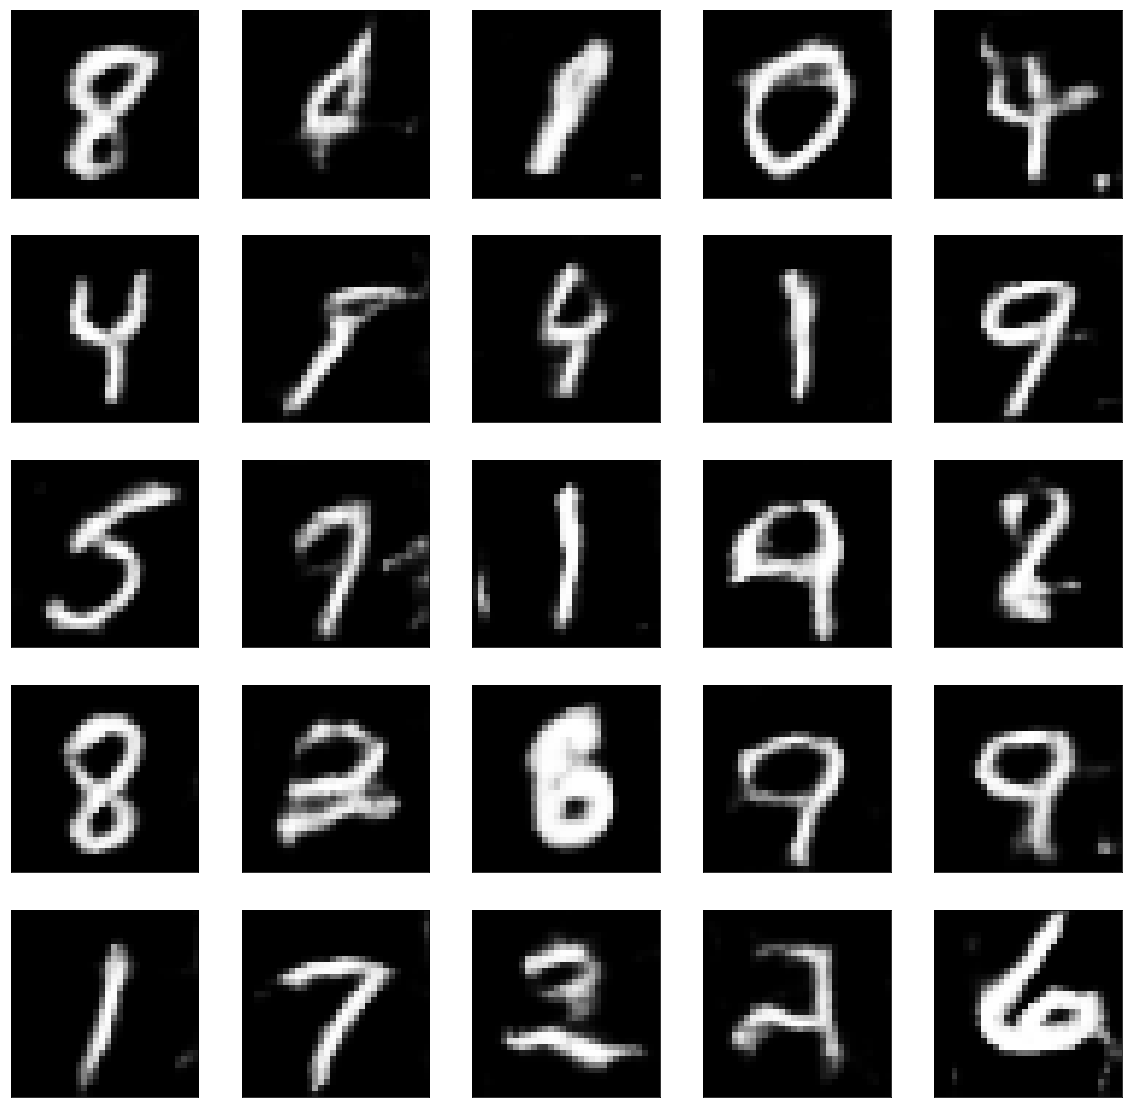

[Epoch 7/10] [Batch 635/938] [Generator loss: 1.517689] [Discriminator loss: 0.563928]
[Epoch 7/10] [Batch 636/938] [Generator loss: 0.742662] [Discriminator loss: 0.522415]
[Epoch 7/10] [Batch 637/938] [Generator loss: 0.866271] [Discriminator loss: 0.680969]
[Epoch 7/10] [Batch 638/938] [Generator loss: 0.697453] [Discriminator loss: 0.493268]
[Epoch 7/10] [Batch 639/938] [Generator loss: 1.477039] [Discriminator loss: 0.556492]
[Epoch 7/10] [Batch 640/938] [Generator loss: 1.104752] [Discriminator loss: 0.514787]
[Epoch 7/10] [Batch 641/938] [Generator loss: 0.520791] [Discriminator loss: 0.432516]
[Epoch 7/10] [Batch 642/938] [Generator loss: 0.314392] [Discriminator loss: 0.677586]
[Epoch 7/10] [Batch 643/938] [Generator loss: 1.388872] [Discriminator loss: 0.506147]
[Epoch 7/10] [Batch 644/938] [Generator loss: 0.963604] [Discriminator loss: 0.362533]
[Epoch 7/10] [Batch 645/938] [Generator loss: 1.063404] [Discriminator loss: 0.546757]
[Epoch 7/10] [Batch 646/938] [Generator los

[Epoch 7/10] [Batch 733/938] [Generator loss: 1.595266] [Discriminator loss: 0.719276]
[Epoch 7/10] [Batch 734/938] [Generator loss: 0.979800] [Discriminator loss: 0.606003]
[Epoch 7/10] [Batch 735/938] [Generator loss: 1.175604] [Discriminator loss: 0.395398]
[Epoch 7/10] [Batch 736/938] [Generator loss: 1.212842] [Discriminator loss: 0.490557]
[Epoch 7/10] [Batch 737/938] [Generator loss: 0.834132] [Discriminator loss: 0.315275]
[Epoch 7/10] [Batch 738/938] [Generator loss: 1.520553] [Discriminator loss: 0.630855]
[Epoch 7/10] [Batch 739/938] [Generator loss: 0.951153] [Discriminator loss: 0.488767]
[Epoch 7/10] [Batch 740/938] [Generator loss: 0.937474] [Discriminator loss: 0.468648]
[Epoch 7/10] [Batch 741/938] [Generator loss: 1.392941] [Discriminator loss: 0.530751]
[Epoch 7/10] [Batch 742/938] [Generator loss: 1.149838] [Discriminator loss: 0.424641]
[Epoch 7/10] [Batch 743/938] [Generator loss: 0.823573] [Discriminator loss: 0.341418]
[Epoch 7/10] [Batch 744/938] [Generator los

[Epoch 7/10] [Batch 836/938] [Generator loss: 1.210032] [Discriminator loss: 0.536685]
[Epoch 7/10] [Batch 837/938] [Generator loss: 0.833759] [Discriminator loss: 0.523571]
[Epoch 7/10] [Batch 838/938] [Generator loss: 1.285535] [Discriminator loss: 0.623349]
[Epoch 7/10] [Batch 839/938] [Generator loss: 1.487130] [Discriminator loss: 0.490933]
[Epoch 7/10] [Batch 840/938] [Generator loss: 1.386146] [Discriminator loss: 0.394243]
[Epoch 7/10] [Batch 841/938] [Generator loss: 1.010264] [Discriminator loss: 0.463818]
[Epoch 7/10] [Batch 842/938] [Generator loss: 1.097038] [Discriminator loss: 0.605135]
[Epoch 7/10] [Batch 843/938] [Generator loss: 1.194066] [Discriminator loss: 0.554508]
[Epoch 7/10] [Batch 844/938] [Generator loss: 0.995000] [Discriminator loss: 0.509712]
[Epoch 7/10] [Batch 845/938] [Generator loss: 1.414587] [Discriminator loss: 0.523746]
[Epoch 7/10] [Batch 846/938] [Generator loss: 0.932395] [Discriminator loss: 0.608308]
[Epoch 7/10] [Batch 847/938] [Generator los

[Epoch 8/10] [Batch 0/938] [Generator loss: 0.399037] [Discriminator loss: 0.478579]
[Epoch 8/10] [Batch 1/938] [Generator loss: 1.191359] [Discriminator loss: 0.467650]
[Epoch 8/10] [Batch 2/938] [Generator loss: 1.459498] [Discriminator loss: 0.417937]
[Epoch 8/10] [Batch 3/938] [Generator loss: 1.281041] [Discriminator loss: 0.558088]
[Epoch 8/10] [Batch 4/938] [Generator loss: 1.151716] [Discriminator loss: 0.369928]
[Epoch 8/10] [Batch 5/938] [Generator loss: 0.999928] [Discriminator loss: 0.343032]
[Epoch 8/10] [Batch 6/938] [Generator loss: 0.849593] [Discriminator loss: 0.395746]
[Epoch 8/10] [Batch 7/938] [Generator loss: 1.127149] [Discriminator loss: 0.505460]
[Epoch 8/10] [Batch 8/938] [Generator loss: 0.915339] [Discriminator loss: 0.576160]
[Epoch 8/10] [Batch 9/938] [Generator loss: 0.575721] [Discriminator loss: 0.500830]
[Epoch 8/10] [Batch 10/938] [Generator loss: 1.272465] [Discriminator loss: 0.530641]
[Epoch 8/10] [Batch 11/938] [Generator loss: 1.246558] [Discrimi

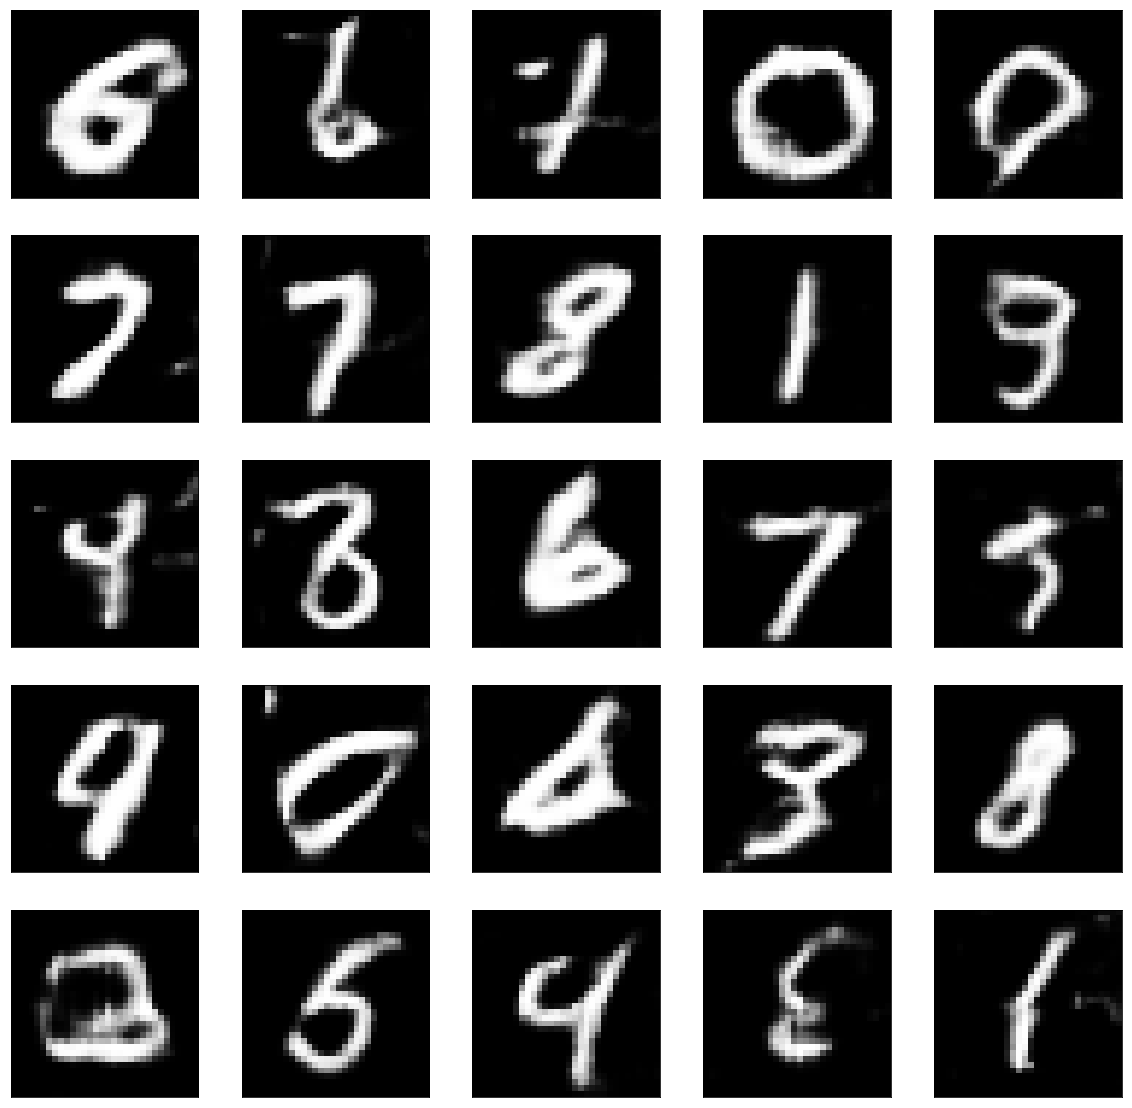

[Epoch 8/10] [Batch 97/938] [Generator loss: 1.325841] [Discriminator loss: 0.631850]
[Epoch 8/10] [Batch 98/938] [Generator loss: 0.769188] [Discriminator loss: 0.562036]
[Epoch 8/10] [Batch 99/938] [Generator loss: 0.851811] [Discriminator loss: 0.650301]
[Epoch 8/10] [Batch 100/938] [Generator loss: 1.438262] [Discriminator loss: 0.595174]
[Epoch 8/10] [Batch 101/938] [Generator loss: 0.620526] [Discriminator loss: 0.588050]
[Epoch 8/10] [Batch 102/938] [Generator loss: 0.743543] [Discriminator loss: 0.361979]
[Epoch 8/10] [Batch 103/938] [Generator loss: 1.504804] [Discriminator loss: 0.388951]
[Epoch 8/10] [Batch 104/938] [Generator loss: 1.503811] [Discriminator loss: 0.557537]
[Epoch 8/10] [Batch 105/938] [Generator loss: 0.640694] [Discriminator loss: 0.773884]
[Epoch 8/10] [Batch 106/938] [Generator loss: 1.111353] [Discriminator loss: 0.545091]
[Epoch 8/10] [Batch 107/938] [Generator loss: 1.069095] [Discriminator loss: 0.335328]
[Epoch 8/10] [Batch 108/938] [Generator loss: 

[Epoch 8/10] [Batch 199/938] [Generator loss: 1.403209] [Discriminator loss: 0.587202]
[Epoch 8/10] [Batch 200/938] [Generator loss: 1.259112] [Discriminator loss: 0.416125]
[Epoch 8/10] [Batch 201/938] [Generator loss: 1.133265] [Discriminator loss: 0.557275]
[Epoch 8/10] [Batch 202/938] [Generator loss: 0.989432] [Discriminator loss: 0.449945]
[Epoch 8/10] [Batch 203/938] [Generator loss: 1.238653] [Discriminator loss: 0.482353]
[Epoch 8/10] [Batch 204/938] [Generator loss: 0.994727] [Discriminator loss: 0.412635]
[Epoch 8/10] [Batch 205/938] [Generator loss: 1.538733] [Discriminator loss: 0.454629]
[Epoch 8/10] [Batch 206/938] [Generator loss: 1.056779] [Discriminator loss: 0.316564]
[Epoch 8/10] [Batch 207/938] [Generator loss: 0.939353] [Discriminator loss: 0.283643]
[Epoch 8/10] [Batch 208/938] [Generator loss: 0.867629] [Discriminator loss: 0.441870]
[Epoch 8/10] [Batch 209/938] [Generator loss: 1.063799] [Discriminator loss: 0.338293]
[Epoch 8/10] [Batch 210/938] [Generator los

[Epoch 8/10] [Batch 297/938] [Generator loss: 0.645774] [Discriminator loss: 0.423604]
[Epoch 8/10] [Batch 298/938] [Generator loss: 1.349547] [Discriminator loss: 0.619419]
[Epoch 8/10] [Batch 299/938] [Generator loss: 0.826150] [Discriminator loss: 0.529391]
[Epoch 8/10] [Batch 300/938] [Generator loss: 1.164715] [Discriminator loss: 0.503006]
[Epoch 8/10] [Batch 301/938] [Generator loss: 0.942610] [Discriminator loss: 0.347735]
[Epoch 8/10] [Batch 302/938] [Generator loss: 0.962083] [Discriminator loss: 0.529384]
[Epoch 8/10] [Batch 303/938] [Generator loss: 1.614780] [Discriminator loss: 0.546072]
[Epoch 8/10] [Batch 304/938] [Generator loss: 0.961589] [Discriminator loss: 0.596812]
[Epoch 8/10] [Batch 305/938] [Generator loss: 1.111434] [Discriminator loss: 0.474479]
[Epoch 8/10] [Batch 306/938] [Generator loss: 0.617761] [Discriminator loss: 0.386195]
[Epoch 8/10] [Batch 307/938] [Generator loss: 0.797494] [Discriminator loss: 0.448284]
[Epoch 8/10] [Batch 308/938] [Generator los

[Epoch 8/10] [Batch 398/938] [Generator loss: 0.647093] [Discriminator loss: 0.484585]
[Epoch 8/10] [Batch 399/938] [Generator loss: 0.726652] [Discriminator loss: 0.428965]
[Epoch 8/10] [Batch 400/938] [Generator loss: 1.154248] [Discriminator loss: 0.593120]
[Epoch 8/10] [Batch 401/938] [Generator loss: 1.021238] [Discriminator loss: 0.347071]
[Epoch 8/10] [Batch 402/938] [Generator loss: 1.000656] [Discriminator loss: 0.281865]
[Epoch 8/10] [Batch 403/938] [Generator loss: 1.009335] [Discriminator loss: 0.527497]
[Epoch 8/10] [Batch 404/938] [Generator loss: 0.759042] [Discriminator loss: 0.448658]
[Epoch 8/10] [Batch 405/938] [Generator loss: 0.600008] [Discriminator loss: 0.549920]
[Epoch 8/10] [Batch 406/938] [Generator loss: 0.985299] [Discriminator loss: 0.786249]
[Epoch 8/10] [Batch 407/938] [Generator loss: 1.031279] [Discriminator loss: 0.403836]
[Epoch 8/10] [Batch 408/938] [Generator loss: 0.694435] [Discriminator loss: 0.396760]
[Epoch 8/10] [Batch 409/938] [Generator los

[Epoch 8/10] [Batch 495/938] [Generator loss: 1.171273] [Discriminator loss: 0.439334]
[Epoch 8/10] [Batch 496/938] [Generator loss: 1.019210] [Discriminator loss: 0.595680]


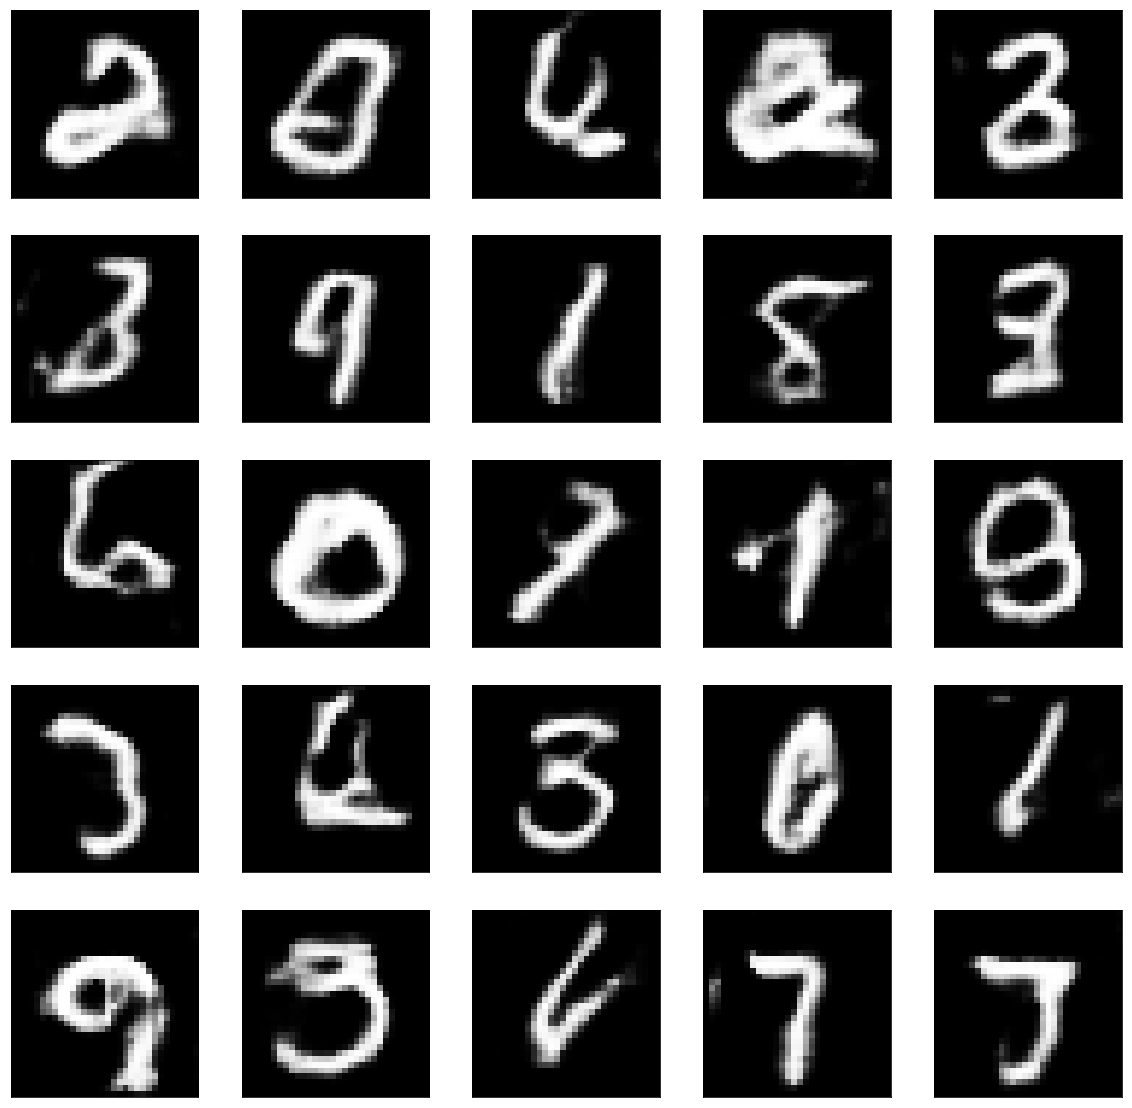

[Epoch 8/10] [Batch 497/938] [Generator loss: 0.935872] [Discriminator loss: 0.609158]
[Epoch 8/10] [Batch 498/938] [Generator loss: 1.366710] [Discriminator loss: 0.519121]
[Epoch 8/10] [Batch 499/938] [Generator loss: 0.827068] [Discriminator loss: 0.561020]
[Epoch 8/10] [Batch 500/938] [Generator loss: 1.135394] [Discriminator loss: 0.418825]
[Epoch 8/10] [Batch 501/938] [Generator loss: 0.905583] [Discriminator loss: 0.567513]
[Epoch 8/10] [Batch 502/938] [Generator loss: 1.273076] [Discriminator loss: 0.572940]
[Epoch 8/10] [Batch 503/938] [Generator loss: 0.994472] [Discriminator loss: 0.519479]
[Epoch 8/10] [Batch 504/938] [Generator loss: 1.361174] [Discriminator loss: 0.443760]
[Epoch 8/10] [Batch 505/938] [Generator loss: 0.992577] [Discriminator loss: 0.314646]
[Epoch 8/10] [Batch 506/938] [Generator loss: 1.146311] [Discriminator loss: 0.363850]
[Epoch 8/10] [Batch 507/938] [Generator loss: 0.801827] [Discriminator loss: 0.703099]
[Epoch 8/10] [Batch 508/938] [Generator los

[Epoch 8/10] [Batch 593/938] [Generator loss: 1.217753] [Discriminator loss: 0.571012]
[Epoch 8/10] [Batch 594/938] [Generator loss: 1.104777] [Discriminator loss: 0.388724]
[Epoch 8/10] [Batch 595/938] [Generator loss: 0.610088] [Discriminator loss: 0.460952]
[Epoch 8/10] [Batch 596/938] [Generator loss: 0.488546] [Discriminator loss: 0.479356]
[Epoch 8/10] [Batch 597/938] [Generator loss: 1.411743] [Discriminator loss: 0.479390]
[Epoch 8/10] [Batch 598/938] [Generator loss: 1.161232] [Discriminator loss: 0.775010]
[Epoch 8/10] [Batch 599/938] [Generator loss: 0.832082] [Discriminator loss: 0.798436]
[Epoch 8/10] [Batch 600/938] [Generator loss: 1.487444] [Discriminator loss: 0.510111]
[Epoch 8/10] [Batch 601/938] [Generator loss: 0.812325] [Discriminator loss: 0.638196]
[Epoch 8/10] [Batch 602/938] [Generator loss: 0.982165] [Discriminator loss: 0.582082]
[Epoch 8/10] [Batch 603/938] [Generator loss: 0.945240] [Discriminator loss: 0.304406]
[Epoch 8/10] [Batch 604/938] [Generator los

[Epoch 8/10] [Batch 694/938] [Generator loss: 1.319713] [Discriminator loss: 0.576299]
[Epoch 8/10] [Batch 695/938] [Generator loss: 0.909534] [Discriminator loss: 0.399138]
[Epoch 8/10] [Batch 696/938] [Generator loss: 0.918167] [Discriminator loss: 0.465959]
[Epoch 8/10] [Batch 697/938] [Generator loss: 1.135323] [Discriminator loss: 0.424247]
[Epoch 8/10] [Batch 698/938] [Generator loss: 1.193860] [Discriminator loss: 0.502105]
[Epoch 8/10] [Batch 699/938] [Generator loss: 1.634681] [Discriminator loss: 0.755575]
[Epoch 8/10] [Batch 700/938] [Generator loss: 1.463422] [Discriminator loss: 0.334053]
[Epoch 8/10] [Batch 701/938] [Generator loss: 0.807385] [Discriminator loss: 0.548055]
[Epoch 8/10] [Batch 702/938] [Generator loss: 1.491744] [Discriminator loss: 0.345066]
[Epoch 8/10] [Batch 703/938] [Generator loss: 1.343573] [Discriminator loss: 0.349022]
[Epoch 8/10] [Batch 704/938] [Generator loss: 1.288974] [Discriminator loss: 0.533326]
[Epoch 8/10] [Batch 705/938] [Generator los

[Epoch 8/10] [Batch 792/938] [Generator loss: 1.086793] [Discriminator loss: 0.689059]
[Epoch 8/10] [Batch 793/938] [Generator loss: 1.107873] [Discriminator loss: 0.342042]
[Epoch 8/10] [Batch 794/938] [Generator loss: 0.909934] [Discriminator loss: 0.773169]
[Epoch 8/10] [Batch 795/938] [Generator loss: 1.354912] [Discriminator loss: 0.477656]
[Epoch 8/10] [Batch 796/938] [Generator loss: 0.867266] [Discriminator loss: 0.692814]
[Epoch 8/10] [Batch 797/938] [Generator loss: 1.196608] [Discriminator loss: 0.329018]
[Epoch 8/10] [Batch 798/938] [Generator loss: 0.670587] [Discriminator loss: 0.520586]
[Epoch 8/10] [Batch 799/938] [Generator loss: 0.846546] [Discriminator loss: 0.671782]
[Epoch 8/10] [Batch 800/938] [Generator loss: 0.867279] [Discriminator loss: 0.573720]
[Epoch 8/10] [Batch 801/938] [Generator loss: 0.979018] [Discriminator loss: 0.553554]
[Epoch 8/10] [Batch 802/938] [Generator loss: 0.823218] [Discriminator loss: 0.308156]
[Epoch 8/10] [Batch 803/938] [Generator los

[Epoch 8/10] [Batch 893/938] [Generator loss: 1.048267] [Discriminator loss: 0.442537]
[Epoch 8/10] [Batch 894/938] [Generator loss: 1.475366] [Discriminator loss: 0.516075]
[Epoch 8/10] [Batch 895/938] [Generator loss: 1.112224] [Discriminator loss: 0.273258]
[Epoch 8/10] [Batch 896/938] [Generator loss: 1.234492] [Discriminator loss: 0.449772]


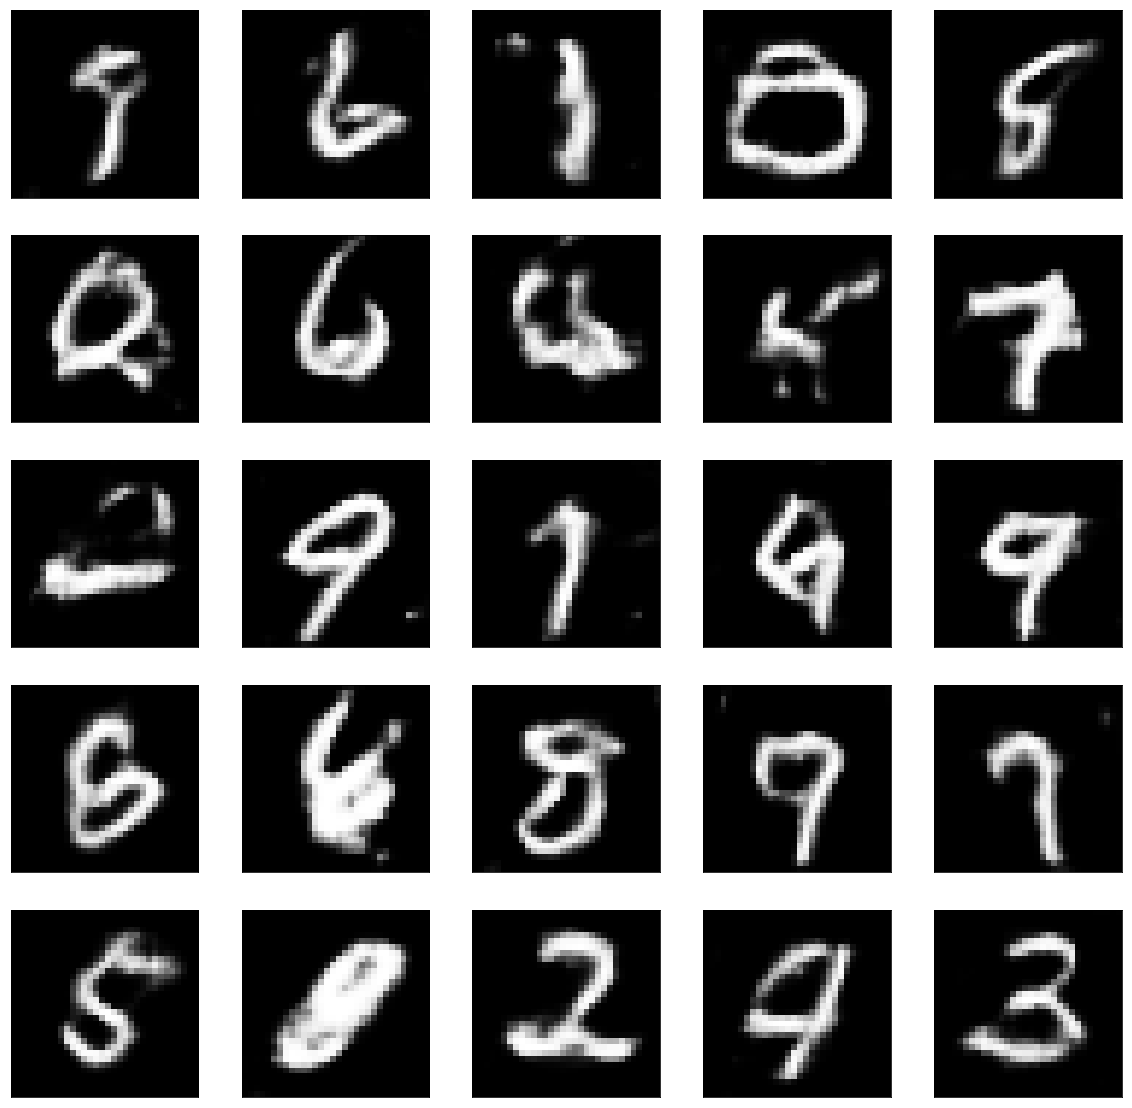

[Epoch 8/10] [Batch 897/938] [Generator loss: 0.559565] [Discriminator loss: 0.443688]
[Epoch 8/10] [Batch 898/938] [Generator loss: 1.508454] [Discriminator loss: 0.518734]
[Epoch 8/10] [Batch 899/938] [Generator loss: 1.641668] [Discriminator loss: 0.345969]
[Epoch 8/10] [Batch 900/938] [Generator loss: 1.161417] [Discriminator loss: 0.561737]
[Epoch 8/10] [Batch 901/938] [Generator loss: 2.020759] [Discriminator loss: 0.394114]
[Epoch 8/10] [Batch 902/938] [Generator loss: 0.961702] [Discriminator loss: 0.448974]
[Epoch 8/10] [Batch 903/938] [Generator loss: 0.749789] [Discriminator loss: 0.566759]
[Epoch 8/10] [Batch 904/938] [Generator loss: 0.692038] [Discriminator loss: 0.358076]
[Epoch 8/10] [Batch 905/938] [Generator loss: 1.679831] [Discriminator loss: 0.469427]
[Epoch 8/10] [Batch 906/938] [Generator loss: 1.103400] [Discriminator loss: 0.491325]
[Epoch 8/10] [Batch 907/938] [Generator loss: 1.544408] [Discriminator loss: 0.410022]
[Epoch 8/10] [Batch 908/938] [Generator los

[Epoch 9/10] [Batch 61/938] [Generator loss: 1.011010] [Discriminator loss: 0.359645]
[Epoch 9/10] [Batch 62/938] [Generator loss: 0.864220] [Discriminator loss: 0.499874]
[Epoch 9/10] [Batch 63/938] [Generator loss: 1.487641] [Discriminator loss: 0.509275]
[Epoch 9/10] [Batch 64/938] [Generator loss: 1.481109] [Discriminator loss: 0.534874]
[Epoch 9/10] [Batch 65/938] [Generator loss: 1.612719] [Discriminator loss: 0.576170]
[Epoch 9/10] [Batch 66/938] [Generator loss: 2.193561] [Discriminator loss: 0.361157]
[Epoch 9/10] [Batch 67/938] [Generator loss: 1.358782] [Discriminator loss: 0.478430]
[Epoch 9/10] [Batch 68/938] [Generator loss: 1.154931] [Discriminator loss: 0.426835]
[Epoch 9/10] [Batch 69/938] [Generator loss: 1.404194] [Discriminator loss: 0.343494]
[Epoch 9/10] [Batch 70/938] [Generator loss: 1.466934] [Discriminator loss: 0.486453]
[Epoch 9/10] [Batch 71/938] [Generator loss: 1.899383] [Discriminator loss: 0.422134]
[Epoch 9/10] [Batch 72/938] [Generator loss: 1.207559]

[Epoch 9/10] [Batch 158/938] [Generator loss: 1.339893] [Discriminator loss: 0.710265]
[Epoch 9/10] [Batch 159/938] [Generator loss: 1.414719] [Discriminator loss: 0.665845]
[Epoch 9/10] [Batch 160/938] [Generator loss: 1.587247] [Discriminator loss: 0.552758]
[Epoch 9/10] [Batch 161/938] [Generator loss: 0.751591] [Discriminator loss: 0.320134]
[Epoch 9/10] [Batch 162/938] [Generator loss: 1.465265] [Discriminator loss: 0.379857]
[Epoch 9/10] [Batch 163/938] [Generator loss: 1.022532] [Discriminator loss: 0.642618]
[Epoch 9/10] [Batch 164/938] [Generator loss: 1.229855] [Discriminator loss: 0.756656]
[Epoch 9/10] [Batch 165/938] [Generator loss: 1.513387] [Discriminator loss: 0.494749]
[Epoch 9/10] [Batch 166/938] [Generator loss: 0.967577] [Discriminator loss: 0.441407]
[Epoch 9/10] [Batch 167/938] [Generator loss: 0.726650] [Discriminator loss: 0.708084]
[Epoch 9/10] [Batch 168/938] [Generator loss: 1.565365] [Discriminator loss: 0.651791]
[Epoch 9/10] [Batch 169/938] [Generator los

[Epoch 9/10] [Batch 254/938] [Generator loss: 1.051863] [Discriminator loss: 0.264121]
[Epoch 9/10] [Batch 255/938] [Generator loss: 1.622117] [Discriminator loss: 0.505606]
[Epoch 9/10] [Batch 256/938] [Generator loss: 1.240817] [Discriminator loss: 0.521722]
[Epoch 9/10] [Batch 257/938] [Generator loss: 0.763037] [Discriminator loss: 0.354770]
[Epoch 9/10] [Batch 258/938] [Generator loss: 0.583870] [Discriminator loss: 0.665508]
[Epoch 9/10] [Batch 259/938] [Generator loss: 0.995462] [Discriminator loss: 0.434308]
[Epoch 9/10] [Batch 260/938] [Generator loss: 1.000262] [Discriminator loss: 0.328582]
[Epoch 9/10] [Batch 261/938] [Generator loss: 1.447707] [Discriminator loss: 0.449122]
[Epoch 9/10] [Batch 262/938] [Generator loss: 1.267191] [Discriminator loss: 0.347786]
[Epoch 9/10] [Batch 263/938] [Generator loss: 1.451318] [Discriminator loss: 0.437254]
[Epoch 9/10] [Batch 264/938] [Generator loss: 1.121820] [Discriminator loss: 0.308095]
[Epoch 9/10] [Batch 265/938] [Generator los

[Epoch 9/10] [Batch 349/938] [Generator loss: 1.099020] [Discriminator loss: 0.775433]
[Epoch 9/10] [Batch 350/938] [Generator loss: 0.906505] [Discriminator loss: 0.572105]
[Epoch 9/10] [Batch 351/938] [Generator loss: 1.121782] [Discriminator loss: 0.709988]
[Epoch 9/10] [Batch 352/938] [Generator loss: 1.542783] [Discriminator loss: 0.399696]
[Epoch 9/10] [Batch 353/938] [Generator loss: 1.045818] [Discriminator loss: 0.423120]
[Epoch 9/10] [Batch 354/938] [Generator loss: 2.167227] [Discriminator loss: 0.356539]
[Epoch 9/10] [Batch 355/938] [Generator loss: 1.377141] [Discriminator loss: 0.557304]
[Epoch 9/10] [Batch 356/938] [Generator loss: 1.611301] [Discriminator loss: 0.432470]
[Epoch 9/10] [Batch 357/938] [Generator loss: 0.752177] [Discriminator loss: 0.680768]
[Epoch 9/10] [Batch 358/938] [Generator loss: 1.255146] [Discriminator loss: 0.591735]


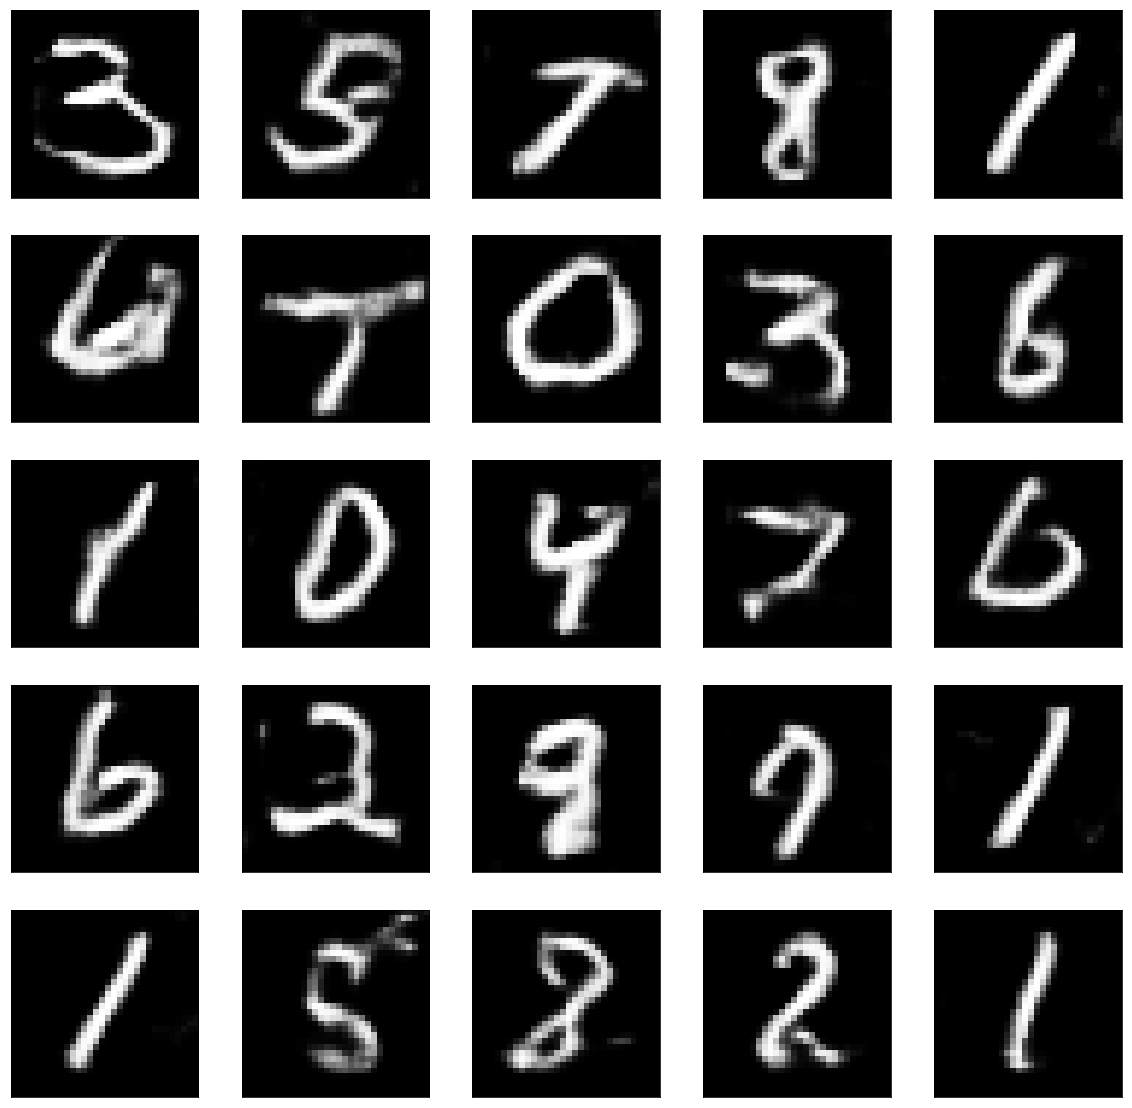

[Epoch 9/10] [Batch 359/938] [Generator loss: 1.302100] [Discriminator loss: 0.556051]
[Epoch 9/10] [Batch 360/938] [Generator loss: 1.122012] [Discriminator loss: 0.617339]
[Epoch 9/10] [Batch 361/938] [Generator loss: 0.448611] [Discriminator loss: 0.687198]
[Epoch 9/10] [Batch 362/938] [Generator loss: 0.908645] [Discriminator loss: 0.424203]
[Epoch 9/10] [Batch 363/938] [Generator loss: 0.565141] [Discriminator loss: 0.394636]
[Epoch 9/10] [Batch 364/938] [Generator loss: 1.200952] [Discriminator loss: 0.440884]
[Epoch 9/10] [Batch 365/938] [Generator loss: 1.418067] [Discriminator loss: 0.542789]
[Epoch 9/10] [Batch 366/938] [Generator loss: 1.102906] [Discriminator loss: 0.409651]
[Epoch 9/10] [Batch 367/938] [Generator loss: 1.938542] [Discriminator loss: 0.724887]
[Epoch 9/10] [Batch 368/938] [Generator loss: 0.692968] [Discriminator loss: 0.360653]
[Epoch 9/10] [Batch 369/938] [Generator loss: 1.053764] [Discriminator loss: 0.462285]
[Epoch 9/10] [Batch 370/938] [Generator los

[Epoch 9/10] [Batch 455/938] [Generator loss: 1.090612] [Discriminator loss: 0.520293]
[Epoch 9/10] [Batch 456/938] [Generator loss: 1.003860] [Discriminator loss: 0.568928]
[Epoch 9/10] [Batch 457/938] [Generator loss: 0.741224] [Discriminator loss: 0.585349]
[Epoch 9/10] [Batch 458/938] [Generator loss: 1.260605] [Discriminator loss: 0.458278]
[Epoch 9/10] [Batch 459/938] [Generator loss: 0.641291] [Discriminator loss: 0.467052]
[Epoch 9/10] [Batch 460/938] [Generator loss: 1.826246] [Discriminator loss: 0.513869]
[Epoch 9/10] [Batch 461/938] [Generator loss: 0.743015] [Discriminator loss: 0.456335]
[Epoch 9/10] [Batch 462/938] [Generator loss: 1.471634] [Discriminator loss: 0.360596]
[Epoch 9/10] [Batch 463/938] [Generator loss: 0.725818] [Discriminator loss: 0.449949]
[Epoch 9/10] [Batch 464/938] [Generator loss: 0.856026] [Discriminator loss: 0.370189]
[Epoch 9/10] [Batch 465/938] [Generator loss: 1.226129] [Discriminator loss: 0.645801]
[Epoch 9/10] [Batch 466/938] [Generator los

[Epoch 9/10] [Batch 554/938] [Generator loss: 0.453227] [Discriminator loss: 0.526230]
[Epoch 9/10] [Batch 555/938] [Generator loss: 1.277985] [Discriminator loss: 0.511618]
[Epoch 9/10] [Batch 556/938] [Generator loss: 1.086812] [Discriminator loss: 0.271937]
[Epoch 9/10] [Batch 557/938] [Generator loss: 1.141803] [Discriminator loss: 0.404225]
[Epoch 9/10] [Batch 558/938] [Generator loss: 0.537012] [Discriminator loss: 0.562607]
[Epoch 9/10] [Batch 559/938] [Generator loss: 0.933272] [Discriminator loss: 0.405865]
[Epoch 9/10] [Batch 560/938] [Generator loss: 1.447219] [Discriminator loss: 0.442893]
[Epoch 9/10] [Batch 561/938] [Generator loss: 2.495547] [Discriminator loss: 0.258154]
[Epoch 9/10] [Batch 562/938] [Generator loss: 1.545703] [Discriminator loss: 0.342636]
[Epoch 9/10] [Batch 563/938] [Generator loss: 1.460953] [Discriminator loss: 0.542175]
[Epoch 9/10] [Batch 564/938] [Generator loss: 1.455089] [Discriminator loss: 0.349938]
[Epoch 9/10] [Batch 565/938] [Generator los

[Epoch 9/10] [Batch 653/938] [Generator loss: 1.202226] [Discriminator loss: 0.317322]
[Epoch 9/10] [Batch 654/938] [Generator loss: 1.062347] [Discriminator loss: 0.768718]
[Epoch 9/10] [Batch 655/938] [Generator loss: 1.458343] [Discriminator loss: 0.679226]
[Epoch 9/10] [Batch 656/938] [Generator loss: 0.801518] [Discriminator loss: 0.316397]
[Epoch 9/10] [Batch 657/938] [Generator loss: 0.685873] [Discriminator loss: 0.323340]
[Epoch 9/10] [Batch 658/938] [Generator loss: 0.459057] [Discriminator loss: 0.444949]
[Epoch 9/10] [Batch 659/938] [Generator loss: 1.388171] [Discriminator loss: 0.410194]
[Epoch 9/10] [Batch 660/938] [Generator loss: 1.990330] [Discriminator loss: 0.541199]
[Epoch 9/10] [Batch 661/938] [Generator loss: 1.999848] [Discriminator loss: 0.313619]
[Epoch 9/10] [Batch 662/938] [Generator loss: 1.498454] [Discriminator loss: 0.327312]
[Epoch 9/10] [Batch 663/938] [Generator loss: 1.462056] [Discriminator loss: 0.445924]
[Epoch 9/10] [Batch 664/938] [Generator los

[Epoch 9/10] [Batch 749/938] [Generator loss: 1.480615] [Discriminator loss: 0.414670]
[Epoch 9/10] [Batch 750/938] [Generator loss: 0.719531] [Discriminator loss: 0.515581]
[Epoch 9/10] [Batch 751/938] [Generator loss: 1.049673] [Discriminator loss: 0.484655]
[Epoch 9/10] [Batch 752/938] [Generator loss: 1.159286] [Discriminator loss: 0.740443]
[Epoch 9/10] [Batch 753/938] [Generator loss: 0.945238] [Discriminator loss: 0.700356]
[Epoch 9/10] [Batch 754/938] [Generator loss: 1.232791] [Discriminator loss: 0.505083]
[Epoch 9/10] [Batch 755/938] [Generator loss: 1.138298] [Discriminator loss: 0.506366]
[Epoch 9/10] [Batch 756/938] [Generator loss: 0.643476] [Discriminator loss: 0.410384]
[Epoch 9/10] [Batch 757/938] [Generator loss: 1.394700] [Discriminator loss: 0.762668]
[Epoch 9/10] [Batch 758/938] [Generator loss: 2.056479] [Discriminator loss: 0.333533]


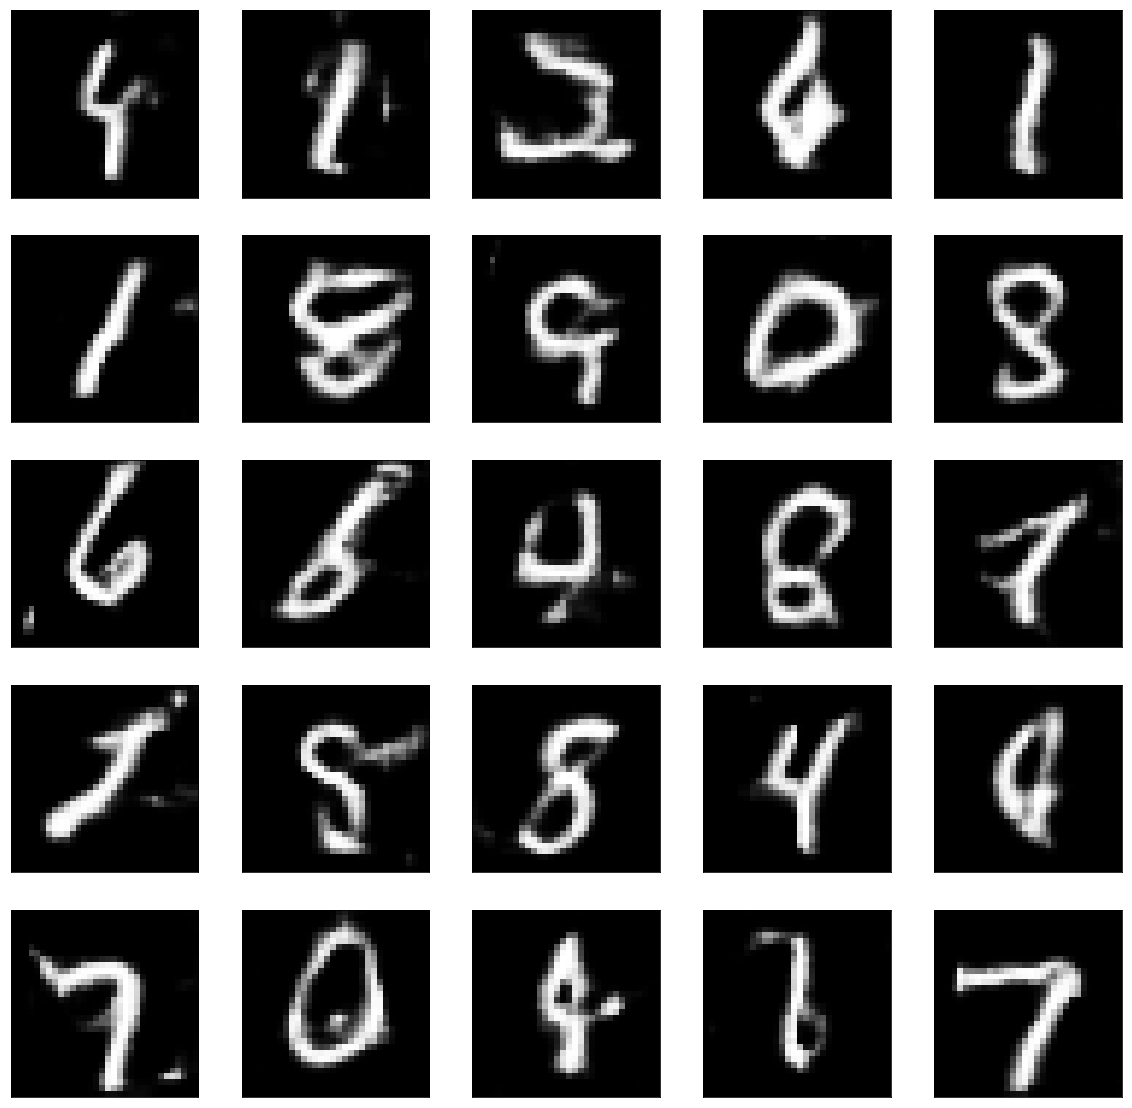

[Epoch 9/10] [Batch 759/938] [Generator loss: 1.614048] [Discriminator loss: 0.579889]
[Epoch 9/10] [Batch 760/938] [Generator loss: 1.411699] [Discriminator loss: 0.341280]
[Epoch 9/10] [Batch 761/938] [Generator loss: 0.756514] [Discriminator loss: 0.382088]
[Epoch 9/10] [Batch 762/938] [Generator loss: 0.733931] [Discriminator loss: 0.425604]
[Epoch 9/10] [Batch 763/938] [Generator loss: 1.193874] [Discriminator loss: 0.861908]
[Epoch 9/10] [Batch 764/938] [Generator loss: 1.487978] [Discriminator loss: 0.667360]
[Epoch 9/10] [Batch 765/938] [Generator loss: 1.664376] [Discriminator loss: 0.440822]
[Epoch 9/10] [Batch 766/938] [Generator loss: 1.131439] [Discriminator loss: 0.399618]
[Epoch 9/10] [Batch 767/938] [Generator loss: 0.859205] [Discriminator loss: 0.511261]
[Epoch 9/10] [Batch 768/938] [Generator loss: 0.785768] [Discriminator loss: 0.768941]
[Epoch 9/10] [Batch 769/938] [Generator loss: 1.635020] [Discriminator loss: 0.443635]
[Epoch 9/10] [Batch 770/938] [Generator los

[Epoch 9/10] [Batch 856/938] [Generator loss: 0.729483] [Discriminator loss: 0.521170]
[Epoch 9/10] [Batch 857/938] [Generator loss: 0.923454] [Discriminator loss: 0.303275]
[Epoch 9/10] [Batch 858/938] [Generator loss: 1.199657] [Discriminator loss: 0.430205]
[Epoch 9/10] [Batch 859/938] [Generator loss: 1.038606] [Discriminator loss: 0.504516]
[Epoch 9/10] [Batch 860/938] [Generator loss: 1.603431] [Discriminator loss: 0.681909]
[Epoch 9/10] [Batch 861/938] [Generator loss: 1.088275] [Discriminator loss: 0.396806]
[Epoch 9/10] [Batch 862/938] [Generator loss: 0.886539] [Discriminator loss: 0.462175]
[Epoch 9/10] [Batch 863/938] [Generator loss: 1.154256] [Discriminator loss: 0.471038]
[Epoch 9/10] [Batch 864/938] [Generator loss: 1.423864] [Discriminator loss: 0.609469]
[Epoch 9/10] [Batch 865/938] [Generator loss: 1.724188] [Discriminator loss: 0.294141]
[Epoch 9/10] [Batch 866/938] [Generator loss: 1.386692] [Discriminator loss: 0.712717]
[Epoch 9/10] [Batch 867/938] [Generator los

In [20]:
g_loss_to_display = []
d_loss_to_display = []
    
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(data_loader):
        
        # adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)
        
        # configure input
        real_imgs = Variable(imgs.type(Tensor))
        
        # ----------------
        # Train Generator
        # ----------------
        
        optimizer_G.zero_grad()
        
        # sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))
        
        # generate a batch of images
        gen_imgs = generator(z)
        
        # loss measures the generator's ability to fool the discriminator
        # print(imgs.shape)
        # print(gen_imgs.shape)
        # break
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        
        optimizer_G.step()
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        
        optimizer_D.zero_grad()
        
        # measure the discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        
        optimizer_D.step()
        
        print(
            "[Epoch %d/%d] [Batch %d/%d] [Generator loss: %f] [Discriminator loss: %f]"
            % (epoch, n_epochs, i, len(data_loader), g_loss.item(), d_loss.item())
        )
        
        # save losses for plotting later
        g_loss_to_display.append(g_loss.item())
        d_loss_to_display.append(d_loss.item())
        
        batches_done = epoch * len(data_loader) + i
        
        if batches_done % sample_interval == 0:
            gen_imgs_to_display = np.transpose(gen_imgs[:25].cpu().detach(), (0, 2, 3, 1))
            
            # display 25 generated images in one batch and save it
            imshow(gen_imgs_to_display)
            save_image(gen_imgs.data[:25], "images/dcgan/%d.png" % batches_done, nrow=5, normalize=True)

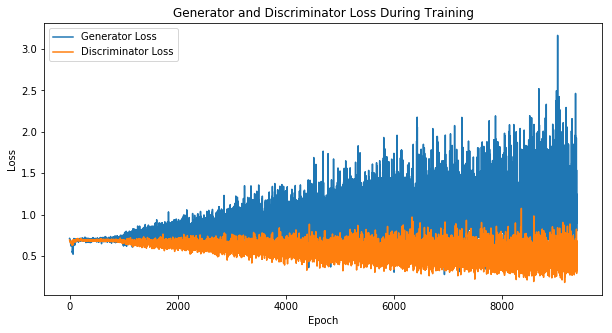

In [21]:
# plot g_loss and d_loss
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_loss_to_display, label='Generator Loss')
plt.plot(d_loss_to_display, label='Discriminator Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('./images/dcgan/final_loss.png')
plt.show()

## Final GAN Images

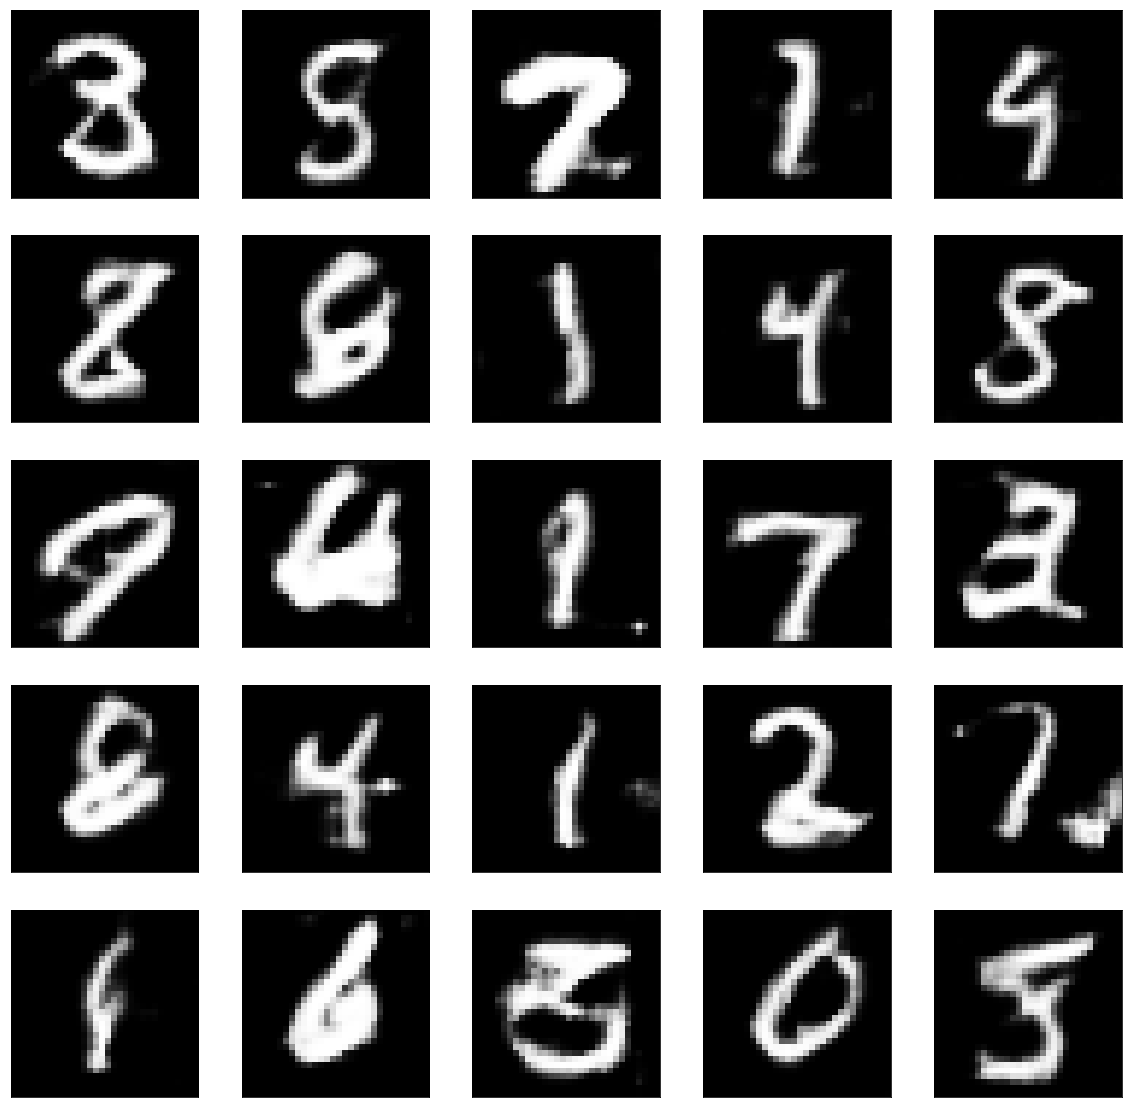

In [22]:
# obtain one batch of test images
dataiter = iter(data_loader)
imgs, _ = dataiter.next()

# sample noise as generator input
z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

# generate a batch of images
gen_imgs = generator(z)
gen_imgs_to_display = np.transpose(gen_imgs[:25].cpu().detach(), (0, 2, 3, 1))

# show and save these final images
imshow(gen_imgs_to_display)

---